In [1]:
import pandas as pd, numpy as np, time
from sklearn.model_selection import train_test_split

In [2]:
% config ZMQInteractiveShell.ast_node_interactivity='all'

In [78]:
# 评价指标
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
def model_performance(y_train, pre_train, pro_train, y_test, pre_test, pro_test, plot=True):
    # 训练集
    print('Train:')
    fpr0, tpr0, th0 = roc_curve(y_train, pro_train)
    roc_auc0 = auc(fpr0, tpr0)
    print('The model accuracy is {}'.format(accuracy_score(y_train, pre_train)))
    print('The model f1 is {}'.format(f1_score(y_train, pre_train)))
    print('The model p is {}'.format(precision_score(y_train, pre_train)))
    print('The model recall is {}'.format(recall_score(y_train, pre_train)))
    print('The confusion matrix is:\n', confusion_matrix(y_train, pre_train))
    if plot:
        plot_roc_auc(fpr0, tpr0, roc_auc0)
    
    # 测试集
    print('Test:')
    fpr, tpr, th = roc_curve(y_test, pro_test)
    roc_auc = auc(fpr, tpr)
    print('The model accuracy is {}'.format(accuracy_score(y_test, pre_test)))
    print('The model f1 is {}'.format(f1_score(y_test, pre_test)))
    print('The model p is {}'.format(precision_score(y_test, pre_test)))
    print('The model recall is {}'.format(recall_score(y_test, pre_test)))
    print('The model KS is {}'.format(max(tpr - fpr)))
    print('The confusion matrix is:\n', confusion_matrix(y_test, pre_test))
    if plot:
        plot_roc_auc(fpr, tpr, roc_auc)
    return fpr, tpr, roc_auc

def plot_roc_auc(fpr, tpr, roc_auc):
    plt.plot(fpr, tpr, label='AUC = {}'.format(roc_auc))
    plt.title('ROC')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.legend()
    plt.plot([0,1],[0,1], c='r')
    plt.show()

In [1]:
# data = pd.read_csv("flights.csv")
# # 随机选取若干行
# data = data.sample(frac = 0.1, random_state=10)#500->50
# data = data.sample(frac = 0.1, random_state=10)#50->5
# data = data[["MONTH","DAY","DAY_OF_WEEK","AIRLINE","FLIGHT_NUMBER","DESTINATION_AIRPORT",
#                  "ORIGIN_AIRPORT","AIR_TIME", "DEPARTURE_TIME","DISTANCE","ARRIVAL_DELAY"]]
# file = pd.DataFrame(data)
# file.to_csv('flights_58191.csv')

In [3]:
# 原始数据500万多，筛选出5万多(已去除缺失值)
data = pd.read_csv("flights_58191.csv")
data.shape

(57140, 12)

In [4]:
data.isnull().sum()

Unnamed: 0             0
MONTH                  0
DAY                    0
DAY_OF_WEEK            0
AIRLINE                0
FLIGHT_NUMBER          0
DESTINATION_AIRPORT    0
ORIGIN_AIRPORT         0
AIR_TIME               0
DEPARTURE_TIME         0
DISTANCE               0
ARRIVAL_DELAY          0
dtype: int64

In [10]:
data.head(2)

,Unnamed: 0,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,DESTINATION_AIRPORT,ORIGIN_AIRPORT,AIR_TIME,DEPARTURE_TIME,DISTANCE,ARRIVAL_DELAY
0,2790857,6,25,4,4,2109,359,402,142.0,846.0,1184,1
1,5203205,11,21,6,13,1912,513,603,60.0,2103.0,414,0


In [8]:
data['MONTH'].max()
data['MONTH'].min()

12

1

In [11]:
data['DAY'].max()
data['DAY'].min()

31

1

In [12]:
data['DAY_OF_WEEK'].max()
data['DAY_OF_WEEK'].min()

7

1

In [14]:
print(list(data))

['Unnamed: 0', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER', 'DESTINATION_AIRPORT', 'ORIGIN_AIRPORT', 'AIR_TIME', 'DEPARTURE_TIME', 'DISTANCE', 'ARRIVAL_DELAY']


In [16]:
data["ARRIVAL_DELAY"].value_counts()

0    44645
1    12495
Name: ARRIVAL_DELAY, dtype: int64

In [28]:
for var in list(data):
    data[var].dtype

dtype('int64')

dtype('int64')

dtype('int64')

dtype('int64')

dtype('int64')

dtype('int64')

dtype('int64')

dtype('int64')

dtype('float64')

dtype('float64')

dtype('int64')

dtype('int64')

In [29]:
cols = ["AIRLINE","FLIGHT_NUMBER","DESTINATION_AIRPORT","ORIGIN_AIRPORT"]
for item in cols:
    data[item] = data[item].astype("category").cat.codes +1

In [36]:
# data.head(1)
data = data.drop('Unnamed: 0',axis=1)
data.shape

(57140, 11)

In [42]:
# 数据划分
x_train, x_test, y_train, y_test = train_test_split(data.drop(["ARRIVAL_DELAY"], axis=1), data["ARRIVAL_DELAY"],
                                                random_state=10, test_size=0.25)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(42855, 10)
(14285, 10)
(42855,)
(14285,)


In [43]:
#### 01.XGBoost ####

In [44]:
import xgboost as xgb
from sklearn.grid_search import GridSearchCV
from sklearn import metrics

In [47]:
# 网格搜索策略
def get_params_init():
    params_init = {
        'base_score':0.5,
        'booster':'gbtree',
        'gamma':0,
        'learning_rate':0.1,
        'max_depth':8,
        'n_estimators':10,
        'objective':'binary:logistic',
        'random_state':0,
        'reg_lambda':1,
        'subsample':0.7,
    }
    return params_init

def get_tree_params():
    params = {
        'n_estimators':[10, 50, 100, 150, 200],
    }
    return params

def get_subsample_params():
    params = {
        'subsample':[0.5,0.6,0.7,0.8],
    }
    return params

def get_learn_params():
    params = {
        'learning_rate':[0.01,0.05,0.1,0.15],
    }
    return params

def get_gr_params():
    params = {
        'gamma':[0.1,0.5,1],
        'reg_lambda':[0.1,0.5,1,2],
    }
    return params

def grid_params_model(model, df, label):
    # 参数组合
    grid_params = [get_tree_params(), get_subsample_params(), get_learn_params(), get_gr_params()]
    for _params_ in grid_params:
        gcv = GridSearchCV(estimator=model, param_grid=_params_, cv=5, iid=False)
        gcv.fit(df, label)
        print(gcv.scorer_, gcv.best_params_, gcv.best_score_)
        # 参数更新
        gcv_params =  model.get_params()
        gcv_params.update(gcv.best_params_)
        model.set_params(**gcv_params)
        print('the other params!')
    return model

def xgb_model_run(df, label):
    params_init = get_params_init()
    # 初始模型
    model_xgb0 = xgb.XGBClassifier(**params_init)
    print(model_xgb0.get_params())
    model_xgb0 = grid_params_model(model_xgb0, df, label)
    return model_xgb0

In [48]:
model_xgb0 = xgb_model_run(x_train, y_train)

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 10, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 0.7, 'verbosity': 1}


C:\Users\Administrator\Anaconda3510\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Administrator\Anaconda3510\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Administrator\Anaconda3510\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Administrator\Anaconda3510\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empt

<function _passthrough_scorer at 0x0000000011148400> {'n_estimators': 100} 0.7901295026147241
the other params!


C:\Users\Administrator\Anaconda3510\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Administrator\Anaconda3510\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Administrator\Anaconda3510\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Administrator\Anaconda3510\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empt

<function _passthrough_scorer at 0x0000000011148400> {'subsample': 0.6} 0.7903860596110543
the other params!


C:\Users\Administrator\Anaconda3510\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Administrator\Anaconda3510\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Administrator\Anaconda3510\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Administrator\Anaconda3510\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empt

<function _passthrough_scorer at 0x0000000011148400> {'learning_rate': 0.1} 0.7903860596110543
the other params!


C:\Users\Administrator\Anaconda3510\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Administrator\Anaconda3510\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Administrator\Anaconda3510\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Administrator\Anaconda3510\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empt

C:\Users\Administrator\Anaconda3510\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Administrator\Anaconda3510\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Administrator\Anaconda3510\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Administrator\Anaconda3510\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empt

C:\Users\Administrator\Anaconda3510\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Administrator\Anaconda3510\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


<function _passthrough_scorer at 0x0000000011148400> {'gamma': 1, 'reg_lambda': 2} 0.7911561580091291
the other params!


In [49]:
model_xgb0.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 1,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 8,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 2,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 0.6,
 'verbosity': 1}

In [50]:
model_xgb0.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=1, learning_rate=0.1,
       max_delta_step=0, max_depth=8, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=2, scale_pos_weight=1, seed=None, silent=None,
       subsample=0.6, verbosity=1)

C:\Users\Administrator\Anaconda3510\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Administrator\Anaconda3510\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Train:
The model accuracy is 0.8304981915762455
The model f1 is 0.3986754966887417
The model p is 0.9282960678488821
The model recall is 0.2538477756694075
The confusion matrix is:
 [[33183   186]
 [ 7078  2408]]


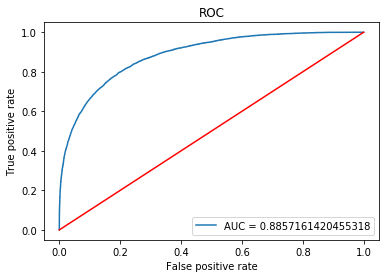

Test:
The model accuracy is 0.7984599229961498
The model f1 is 0.2066685037200331
The model p is 0.6048387096774194
The model recall is 0.12462612163509472
The model KS is 0.3065705921139267
The confusion matrix is:
 [[11031   245]
 [ 2634   375]]


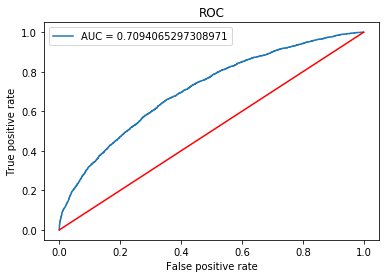

In [79]:
# 训练集
pre_train0_1 = model_xgb0.predict(x_train)
pro_train0_1 = model_xgb0.predict_proba(x_train)[:,1]
# 测试集
pre_test0_1 = model_xgb0.predict(x_test)
pro_test0_1 = model_xgb0.predict_proba(x_test)[:,1]

fpr, tpr, _ = model_performance(y_train, pre_train0_1, pro_train0_1, y_test, pre_test0_1, pro_test0_1)

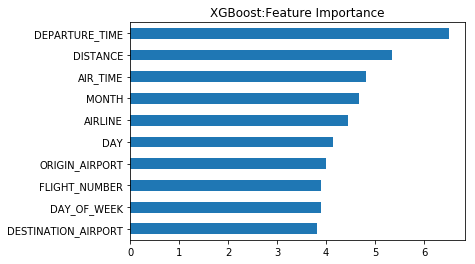

In [82]:
score_f = pd.Series(model_xgb0.get_booster().get_score(importance_type='gain')).sort_values(ascending=True)
score_f.plot(kind='barh', title='XGBoost:Feature Importance')

In [55]:
#### 02.CatBoost ####

In [56]:
import catboost as cb

In [71]:
from sklearn.model_selection import GridSearchCV
# 网格搜索策略
def get_params_init():
    params_init = {
        'iterations':10,
        'cat_features': [0,1,2,3,4,5,6],
        'loss_function':'Logloss',
        'depth':5,
        'subsample':0.7,
        'learning_rate':0.1,
        'l2_leaf_reg':0.1,   
    }
    return params_init

def get_tree_params():
    params = {
        'iterations':[10, 50, 100, 150, 200],
        'depth':[5, 6, 7, 8],
    }
    return params

def get_subsample_params():
    params = {
        'subsample':[0.5,0.6,0.7,0.8],
    }
    return params

def get_learn_params():
    params = {
        'learning_rate':[0.01,0.05,0.1,0.15],
    }
    return params

def get_l2_params():
    params = {
        'l2_leaf_reg':[0.1,0.5,1,2],
    }
    return params

def grid_params_model(model, df, label):
    # 参数组合
    grid_params = [get_tree_params(), get_subsample_params(), get_learn_params(), get_l2_params()]
    for _params_ in grid_params:
        
        gcv = GridSearchCV(estimator=model, param_grid=_params_, cv=5, iid=False)
        gcv.fit(df, label)
        print(gcv.scorer_, gcv.best_params_, gcv.best_score_)
        # 参数更新
        gcv_params =  model.get_params()
        gcv_params.update(gcv.best_params_)
        model.set_params(**gcv_params)
        print('the other params!')
    return model
        
def model_run(df, label):
    params_init = get_params_init()
    # 初始模型
    model_cb0 = cb.CatBoostClassifier(**params_init)
    print(model_cb0.get_params())
    model_cb0 = grid_params_model(model_cb0, df, label)
    return model_cb0

In [72]:
model_cb0 = model_run(x_train, y_train)

{'cat_features': [0, 1, 2, 3, 4, 5, 6], 'subsample': 0.7, 'loss_function': 'Logloss', 'l2_leaf_reg': 0.1, 'depth': 5, 'learning_rate': 0.1, 'iterations': 10}
0:	learn: 0.6621992	total: 27.4ms	remaining: 246ms
1:	learn: 0.6369365	total: 41.9ms	remaining: 167ms
2:	learn: 0.6159544	total: 57.1ms	remaining: 133ms
3:	learn: 0.5981427	total: 78.3ms	remaining: 117ms
4:	learn: 0.5836671	total: 94.2ms	remaining: 94.2ms
5:	learn: 0.5727164	total: 102ms	remaining: 68.2ms
6:	learn: 0.5625352	total: 118ms	remaining: 50.6ms
7:	learn: 0.5541612	total: 130ms	remaining: 32.5ms
8:	learn: 0.5466004	total: 146ms	remaining: 16.2ms
9:	learn: 0.5401706	total: 162ms	remaining: 0us
0:	learn: 0.6618422	total: 32.2ms	remaining: 289ms
1:	learn: 0.6365635	total: 45ms	remaining: 180ms
2:	learn: 0.6154880	total: 69ms	remaining: 161ms
3:	learn: 0.5986633	total: 85ms	remaining: 128ms
4:	learn: 0.5845103	total: 102ms	remaining: 102ms
5:	learn: 0.5723184	total: 120ms	remaining: 79.9ms
6:	learn: 0.5624287	total: 133ms	re

14:	learn: 0.5214849	total: 222ms	remaining: 518ms
15:	learn: 0.5186008	total: 243ms	remaining: 517ms
16:	learn: 0.5160639	total: 265ms	remaining: 515ms
17:	learn: 0.5141886	total: 282ms	remaining: 501ms
18:	learn: 0.5122947	total: 299ms	remaining: 488ms
19:	learn: 0.5109055	total: 316ms	remaining: 473ms
20:	learn: 0.5094411	total: 332ms	remaining: 459ms
21:	learn: 0.5085099	total: 348ms	remaining: 443ms
22:	learn: 0.5073153	total: 364ms	remaining: 427ms
23:	learn: 0.5065740	total: 376ms	remaining: 407ms
24:	learn: 0.5053421	total: 393ms	remaining: 393ms
25:	learn: 0.5045960	total: 409ms	remaining: 378ms
26:	learn: 0.5036094	total: 430ms	remaining: 366ms
27:	learn: 0.5025567	total: 452ms	remaining: 355ms
28:	learn: 0.5018997	total: 474ms	remaining: 343ms
29:	learn: 0.5011235	total: 493ms	remaining: 329ms
30:	learn: 0.5005183	total: 510ms	remaining: 312ms
31:	learn: 0.4999109	total: 526ms	remaining: 296ms
32:	learn: 0.4996538	total: 538ms	remaining: 277ms
33:	learn: 0.4992414	total: 555

32:	learn: 0.5013718	total: 654ms	remaining: 1.33s
33:	learn: 0.5009491	total: 683ms	remaining: 1.33s
34:	learn: 0.5005784	total: 709ms	remaining: 1.32s
35:	learn: 0.4998648	total: 729ms	remaining: 1.3s
36:	learn: 0.4993043	total: 749ms	remaining: 1.27s
37:	learn: 0.4987257	total: 765ms	remaining: 1.25s
38:	learn: 0.4984281	total: 781ms	remaining: 1.22s
39:	learn: 0.4981160	total: 796ms	remaining: 1.19s
40:	learn: 0.4980583	total: 806ms	remaining: 1.16s
41:	learn: 0.4976012	total: 822ms	remaining: 1.14s
42:	learn: 0.4970766	total: 837ms	remaining: 1.11s
43:	learn: 0.4966940	total: 855ms	remaining: 1.09s
44:	learn: 0.4963277	total: 877ms	remaining: 1.07s
45:	learn: 0.4960566	total: 895ms	remaining: 1.05s
46:	learn: 0.4959358	total: 913ms	remaining: 1.03s
47:	learn: 0.4957338	total: 929ms	remaining: 1.01s
48:	learn: 0.4953038	total: 946ms	remaining: 985ms
49:	learn: 0.4951103	total: 963ms	remaining: 963ms
50:	learn: 0.4948901	total: 981ms	remaining: 943ms
51:	learn: 0.4946411	total: 1s	r

0:	learn: 0.6617708	total: 34.2ms	remaining: 3.38s
1:	learn: 0.6364589	total: 47.6ms	remaining: 2.33s
2:	learn: 0.6152795	total: 68.8ms	remaining: 2.22s
3:	learn: 0.5983433	total: 81.9ms	remaining: 1.97s
4:	learn: 0.5841172	total: 98.6ms	remaining: 1.87s
5:	learn: 0.5718835	total: 116ms	remaining: 1.82s
6:	learn: 0.5618928	total: 131ms	remaining: 1.74s
7:	learn: 0.5544159	total: 140ms	remaining: 1.61s
8:	learn: 0.5468642	total: 157ms	remaining: 1.59s
9:	learn: 0.5407375	total: 173ms	remaining: 1.55s
10:	learn: 0.5353048	total: 196ms	remaining: 1.59s
11:	learn: 0.5307445	total: 217ms	remaining: 1.59s
12:	learn: 0.5278559	total: 227ms	remaining: 1.52s
13:	learn: 0.5238268	total: 248ms	remaining: 1.52s
14:	learn: 0.5214849	total: 264ms	remaining: 1.49s
15:	learn: 0.5186008	total: 291ms	remaining: 1.53s
16:	learn: 0.5160639	total: 317ms	remaining: 1.55s
17:	learn: 0.5141886	total: 340ms	remaining: 1.55s
18:	learn: 0.5122947	total: 362ms	remaining: 1.54s
19:	learn: 0.5109055	total: 383ms	re

73:	learn: 0.4898541	total: 1.32s	remaining: 464ms
74:	learn: 0.4897748	total: 1.34s	remaining: 446ms
75:	learn: 0.4896979	total: 1.35s	remaining: 428ms
76:	learn: 0.4893671	total: 1.37s	remaining: 409ms
77:	learn: 0.4891847	total: 1.39s	remaining: 391ms
78:	learn: 0.4890436	total: 1.4s	remaining: 373ms
79:	learn: 0.4887623	total: 1.42s	remaining: 355ms
80:	learn: 0.4886502	total: 1.44s	remaining: 337ms
81:	learn: 0.4884810	total: 1.45s	remaining: 319ms
82:	learn: 0.4884289	total: 1.47s	remaining: 300ms
83:	learn: 0.4882602	total: 1.48s	remaining: 283ms
84:	learn: 0.4879500	total: 1.5s	remaining: 265ms
85:	learn: 0.4878069	total: 1.51s	remaining: 247ms
86:	learn: 0.4875638	total: 1.53s	remaining: 229ms
87:	learn: 0.4873500	total: 1.55s	remaining: 212ms
88:	learn: 0.4871861	total: 1.57s	remaining: 194ms
89:	learn: 0.4869585	total: 1.59s	remaining: 176ms
90:	learn: 0.4867363	total: 1.6s	remaining: 159ms
91:	learn: 0.4865613	total: 1.62s	remaining: 141ms
92:	learn: 0.4863725	total: 1.64s	

45:	learn: 0.4960566	total: 873ms	remaining: 1.97s
46:	learn: 0.4959358	total: 894ms	remaining: 1.96s
47:	learn: 0.4957338	total: 916ms	remaining: 1.95s
48:	learn: 0.4953038	total: 932ms	remaining: 1.92s
49:	learn: 0.4951103	total: 949ms	remaining: 1.9s
50:	learn: 0.4948901	total: 965ms	remaining: 1.87s
51:	learn: 0.4946411	total: 981ms	remaining: 1.85s
52:	learn: 0.4944424	total: 996ms	remaining: 1.82s
53:	learn: 0.4943533	total: 1.01s	remaining: 1.8s
54:	learn: 0.4940325	total: 1.03s	remaining: 1.78s
55:	learn: 0.4937231	total: 1.05s	remaining: 1.76s
56:	learn: 0.4935644	total: 1.06s	remaining: 1.74s
57:	learn: 0.4932219	total: 1.08s	remaining: 1.72s
58:	learn: 0.4930493	total: 1.1s	remaining: 1.7s
59:	learn: 0.4926846	total: 1.12s	remaining: 1.68s
60:	learn: 0.4925463	total: 1.14s	remaining: 1.66s
61:	learn: 0.4922843	total: 1.16s	remaining: 1.64s
62:	learn: 0.4921608	total: 1.18s	remaining: 1.62s
63:	learn: 0.4918722	total: 1.19s	remaining: 1.6s
64:	learn: 0.4917581	total: 1.21s	re

61:	learn: 0.4934258	total: 1.12s	remaining: 1.59s
62:	learn: 0.4934012	total: 1.13s	remaining: 1.56s
63:	learn: 0.4932344	total: 1.15s	remaining: 1.55s
64:	learn: 0.4929381	total: 1.17s	remaining: 1.53s
65:	learn: 0.4927379	total: 1.19s	remaining: 1.51s
66:	learn: 0.4925859	total: 1.2s	remaining: 1.49s
67:	learn: 0.4924737	total: 1.22s	remaining: 1.47s
68:	learn: 0.4923815	total: 1.23s	remaining: 1.45s
69:	learn: 0.4922941	total: 1.25s	remaining: 1.43s
70:	learn: 0.4921122	total: 1.26s	remaining: 1.41s
71:	learn: 0.4919838	total: 1.28s	remaining: 1.39s
72:	learn: 0.4918291	total: 1.3s	remaining: 1.37s
73:	learn: 0.4917417	total: 1.31s	remaining: 1.35s
74:	learn: 0.4916478	total: 1.33s	remaining: 1.33s
75:	learn: 0.4915294	total: 1.35s	remaining: 1.32s
76:	learn: 0.4914823	total: 1.37s	remaining: 1.29s
77:	learn: 0.4913502	total: 1.38s	remaining: 1.28s
78:	learn: 0.4910450	total: 1.4s	remaining: 1.26s
79:	learn: 0.4909053	total: 1.42s	remaining: 1.24s
80:	learn: 0.4906469	total: 1.43s	

81:	learn: 0.4862459	total: 1.99s	remaining: 1.65s
82:	learn: 0.4861581	total: 2.01s	remaining: 1.63s
83:	learn: 0.4859621	total: 2.04s	remaining: 1.6s
84:	learn: 0.4859238	total: 2.06s	remaining: 1.57s
85:	learn: 0.4858209	total: 2.08s	remaining: 1.55s
86:	learn: 0.4855197	total: 2.1s	remaining: 1.52s
87:	learn: 0.4853417	total: 2.12s	remaining: 1.49s
88:	learn: 0.4850714	total: 2.14s	remaining: 1.47s
89:	learn: 0.4847724	total: 2.16s	remaining: 1.44s
90:	learn: 0.4846660	total: 2.18s	remaining: 1.41s
91:	learn: 0.4845803	total: 2.19s	remaining: 1.38s
92:	learn: 0.4844951	total: 2.22s	remaining: 1.36s
93:	learn: 0.4843945	total: 2.24s	remaining: 1.33s
94:	learn: 0.4842519	total: 2.26s	remaining: 1.31s
95:	learn: 0.4841357	total: 2.28s	remaining: 1.28s
96:	learn: 0.4840549	total: 2.29s	remaining: 1.25s
97:	learn: 0.4839414	total: 2.31s	remaining: 1.23s
98:	learn: 0.4838672	total: 2.33s	remaining: 1.2s
99:	learn: 0.4836810	total: 2.34s	remaining: 1.17s
100:	learn: 0.4833412	total: 2.36s

100:	learn: 0.4850012	total: 1.9s	remaining: 924ms
101:	learn: 0.4848185	total: 1.92s	remaining: 906ms
102:	learn: 0.4846818	total: 1.94s	remaining: 886ms
103:	learn: 0.4845647	total: 1.96s	remaining: 866ms
104:	learn: 0.4844383	total: 1.97s	remaining: 846ms
105:	learn: 0.4843009	total: 1.99s	remaining: 826ms
106:	learn: 0.4840662	total: 2s	remaining: 806ms
107:	learn: 0.4839446	total: 2.02s	remaining: 786ms
108:	learn: 0.4836631	total: 2.04s	remaining: 766ms
109:	learn: 0.4834594	total: 2.05s	remaining: 747ms
110:	learn: 0.4832649	total: 2.07s	remaining: 727ms
111:	learn: 0.4830884	total: 2.08s	remaining: 708ms
112:	learn: 0.4829862	total: 2.1s	remaining: 689ms
113:	learn: 0.4828621	total: 2.12s	remaining: 671ms
114:	learn: 0.4826764	total: 2.14s	remaining: 652ms
115:	learn: 0.4825017	total: 2.16s	remaining: 633ms
116:	learn: 0.4823944	total: 2.17s	remaining: 614ms
117:	learn: 0.4822791	total: 2.19s	remaining: 594ms
118:	learn: 0.4821651	total: 2.21s	remaining: 575ms
119:	learn: 0.481

119:	learn: 0.4822475	total: 2.31s	remaining: 578ms
120:	learn: 0.4820734	total: 2.33s	remaining: 560ms
121:	learn: 0.4819680	total: 2.36s	remaining: 542ms
122:	learn: 0.4818284	total: 2.38s	remaining: 523ms
123:	learn: 0.4817283	total: 2.41s	remaining: 505ms
124:	learn: 0.4812643	total: 2.43s	remaining: 486ms
125:	learn: 0.4811508	total: 2.45s	remaining: 466ms
126:	learn: 0.4809029	total: 2.47s	remaining: 448ms
127:	learn: 0.4807680	total: 2.49s	remaining: 429ms
128:	learn: 0.4806522	total: 2.52s	remaining: 411ms
129:	learn: 0.4803897	total: 2.55s	remaining: 392ms
130:	learn: 0.4802317	total: 2.57s	remaining: 373ms
131:	learn: 0.4800461	total: 2.59s	remaining: 353ms
132:	learn: 0.4798861	total: 2.6s	remaining: 333ms
133:	learn: 0.4797454	total: 2.62s	remaining: 313ms
134:	learn: 0.4796191	total: 2.63s	remaining: 293ms
135:	learn: 0.4795479	total: 2.65s	remaining: 273ms
136:	learn: 0.4792962	total: 2.67s	remaining: 253ms
137:	learn: 0.4791107	total: 2.68s	remaining: 233ms
138:	learn: 0

131:	learn: 0.4718599	total: 9.7s	remaining: 5s
132:	learn: 0.4716871	total: 9.77s	remaining: 4.92s
133:	learn: 0.4714995	total: 9.82s	remaining: 4.84s
134:	learn: 0.4711632	total: 9.9s	remaining: 4.77s
135:	learn: 0.4709881	total: 9.98s	remaining: 4.7s
136:	learn: 0.4705961	total: 10.1s	remaining: 4.62s
137:	learn: 0.4704199	total: 10.1s	remaining: 4.55s
138:	learn: 0.4703025	total: 10.2s	remaining: 4.48s
139:	learn: 0.4700727	total: 10.3s	remaining: 4.41s
140:	learn: 0.4697890	total: 10.3s	remaining: 4.33s
141:	learn: 0.4696370	total: 10.4s	remaining: 4.25s
142:	learn: 0.4694731	total: 10.5s	remaining: 4.17s
143:	learn: 0.4691508	total: 10.5s	remaining: 4.09s
144:	learn: 0.4689380	total: 10.6s	remaining: 4.02s
145:	learn: 0.4687727	total: 10.7s	remaining: 3.94s
146:	learn: 0.4686426	total: 10.7s	remaining: 3.87s
147:	learn: 0.4685361	total: 10.8s	remaining: 3.79s
148:	learn: 0.4684294	total: 10.9s	remaining: 3.72s
149:	learn: 0.4683515	total: 11s	remaining: 3.67s
150:	learn: 0.468011

92:	learn: 0.4781264	total: 6.31s	remaining: 7.26s
93:	learn: 0.4778571	total: 6.4s	remaining: 7.21s
94:	learn: 0.4776442	total: 6.47s	remaining: 7.15s
95:	learn: 0.4773907	total: 6.54s	remaining: 7.09s
96:	learn: 0.4771430	total: 6.64s	remaining: 7.06s
97:	learn: 0.4769147	total: 6.75s	remaining: 7.02s
98:	learn: 0.4765820	total: 6.85s	remaining: 6.99s
99:	learn: 0.4763653	total: 6.92s	remaining: 6.92s
100:	learn: 0.4762830	total: 6.98s	remaining: 6.84s
101:	learn: 0.4760462	total: 7.05s	remaining: 6.77s
102:	learn: 0.4758242	total: 7.13s	remaining: 6.71s
103:	learn: 0.4754779	total: 7.2s	remaining: 6.64s
104:	learn: 0.4752586	total: 7.26s	remaining: 6.57s
105:	learn: 0.4750168	total: 7.33s	remaining: 6.5s
106:	learn: 0.4748658	total: 7.41s	remaining: 6.44s
107:	learn: 0.4747781	total: 7.48s	remaining: 6.37s
108:	learn: 0.4745788	total: 7.56s	remaining: 6.31s
109:	learn: 0.4743929	total: 7.63s	remaining: 6.24s
110:	learn: 0.4743295	total: 7.7s	remaining: 6.17s
111:	learn: 0.4742563	to

54:	learn: 0.4840394	total: 3.95s	remaining: 10.4s
55:	learn: 0.4838551	total: 4.05s	remaining: 10.4s
56:	learn: 0.4835561	total: 4.16s	remaining: 10.4s
57:	learn: 0.4833062	total: 4.26s	remaining: 10.4s
58:	learn: 0.4830285	total: 4.33s	remaining: 10.3s
59:	learn: 0.4828838	total: 4.4s	remaining: 10.3s
60:	learn: 0.4826686	total: 4.48s	remaining: 10.2s
61:	learn: 0.4825370	total: 4.55s	remaining: 10.1s
62:	learn: 0.4823509	total: 4.62s	remaining: 10s
63:	learn: 0.4819753	total: 4.69s	remaining: 9.96s
64:	learn: 0.4817517	total: 4.77s	remaining: 9.91s
65:	learn: 0.4815624	total: 4.85s	remaining: 9.84s
66:	learn: 0.4813566	total: 4.92s	remaining: 9.76s
67:	learn: 0.4810283	total: 4.99s	remaining: 9.68s
68:	learn: 0.4808433	total: 5.1s	remaining: 9.69s
69:	learn: 0.4803743	total: 5.21s	remaining: 9.68s
70:	learn: 0.4800952	total: 5.3s	remaining: 9.64s
71:	learn: 0.4799025	total: 5.4s	remaining: 9.59s
72:	learn: 0.4798289	total: 5.47s	remaining: 9.52s
73:	learn: 0.4795959	total: 5.54s	rem

16:	learn: 0.5050344	total: 1.3s	remaining: 14s
17:	learn: 0.5030249	total: 1.36s	remaining: 13.8s
18:	learn: 0.5016584	total: 1.43s	remaining: 13.7s
19:	learn: 0.5003464	total: 1.49s	remaining: 13.4s
20:	learn: 0.4991144	total: 1.55s	remaining: 13.2s
21:	learn: 0.4984401	total: 1.62s	remaining: 13.1s
22:	learn: 0.4971704	total: 1.69s	remaining: 13s
23:	learn: 0.4966206	total: 1.76s	remaining: 12.9s
24:	learn: 0.4961775	total: 1.84s	remaining: 12.9s
25:	learn: 0.4956145	total: 1.9s	remaining: 12.7s
26:	learn: 0.4950798	total: 1.99s	remaining: 12.8s
27:	learn: 0.4947485	total: 2.08s	remaining: 12.8s
28:	learn: 0.4941922	total: 2.16s	remaining: 12.7s
29:	learn: 0.4936715	total: 2.23s	remaining: 12.7s
30:	learn: 0.4930819	total: 2.3s	remaining: 12.5s
31:	learn: 0.4923514	total: 2.38s	remaining: 12.5s
32:	learn: 0.4920279	total: 2.49s	remaining: 12.6s
33:	learn: 0.4916132	total: 2.57s	remaining: 12.5s
34:	learn: 0.4912490	total: 2.64s	remaining: 12.4s
35:	learn: 0.4910178	total: 2.71s	rema

176:	learn: 0.4640752	total: 14.1s	remaining: 1.83s
177:	learn: 0.4639399	total: 14.2s	remaining: 1.75s
178:	learn: 0.4638135	total: 14.3s	remaining: 1.67s
179:	learn: 0.4637098	total: 14.3s	remaining: 1.59s
180:	learn: 0.4635183	total: 14.4s	remaining: 1.51s
181:	learn: 0.4634017	total: 14.5s	remaining: 1.43s
182:	learn: 0.4632380	total: 14.6s	remaining: 1.35s
183:	learn: 0.4630691	total: 14.7s	remaining: 1.27s
184:	learn: 0.4629115	total: 14.8s	remaining: 1.2s
185:	learn: 0.4627500	total: 14.8s	remaining: 1.12s
186:	learn: 0.4626460	total: 14.9s	remaining: 1.04s
187:	learn: 0.4624918	total: 15s	remaining: 957ms
188:	learn: 0.4623525	total: 15.1s	remaining: 878ms
189:	learn: 0.4622420	total: 15.2s	remaining: 798ms
190:	learn: 0.4621915	total: 15.2s	remaining: 718ms
191:	learn: 0.4621366	total: 15.3s	remaining: 638ms
192:	learn: 0.4618295	total: 15.4s	remaining: 558ms
193:	learn: 0.4616612	total: 15.5s	remaining: 479ms
194:	learn: 0.4615277	total: 15.6s	remaining: 399ms
195:	learn: 0.4

139:	learn: 0.4696319	total: 10.4s	remaining: 4.46s
140:	learn: 0.4693141	total: 10.5s	remaining: 4.38s
141:	learn: 0.4692501	total: 10.6s	remaining: 4.31s
142:	learn: 0.4688209	total: 10.6s	remaining: 4.24s
143:	learn: 0.4685492	total: 10.7s	remaining: 4.16s
144:	learn: 0.4684691	total: 10.8s	remaining: 4.08s
145:	learn: 0.4683531	total: 10.8s	remaining: 4.01s
146:	learn: 0.4682226	total: 10.9s	remaining: 3.93s
147:	learn: 0.4678494	total: 11s	remaining: 3.85s
148:	learn: 0.4676349	total: 11.1s	remaining: 3.79s
149:	learn: 0.4673268	total: 11.1s	remaining: 3.71s
150:	learn: 0.4671801	total: 11.2s	remaining: 3.65s
151:	learn: 0.4669780	total: 11.3s	remaining: 3.57s
152:	learn: 0.4668429	total: 11.4s	remaining: 3.5s
153:	learn: 0.4666795	total: 11.5s	remaining: 3.42s
154:	learn: 0.4664212	total: 11.5s	remaining: 3.35s
155:	learn: 0.4662314	total: 11.6s	remaining: 3.28s
156:	learn: 0.4661608	total: 11.7s	remaining: 3.2s
157:	learn: 0.4660657	total: 11.8s	remaining: 3.13s
158:	learn: 0.46

0:	learn: 0.6614770	total: 29.2ms	remaining: 1.43s
1:	learn: 0.6374887	total: 37.8ms	remaining: 907ms
2:	learn: 0.6178827	total: 46ms	remaining: 720ms
3:	learn: 0.5997349	total: 71.5ms	remaining: 822ms
4:	learn: 0.5851362	total: 93.1ms	remaining: 838ms
5:	learn: 0.5726535	total: 111ms	remaining: 815ms
6:	learn: 0.5621834	total: 131ms	remaining: 807ms
7:	learn: 0.5538844	total: 143ms	remaining: 748ms
8:	learn: 0.5463044	total: 161ms	remaining: 735ms
9:	learn: 0.5409678	total: 171ms	remaining: 685ms
10:	learn: 0.5359912	total: 183ms	remaining: 650ms
11:	learn: 0.5318801	total: 195ms	remaining: 618ms
12:	learn: 0.5283399	total: 211ms	remaining: 602ms
13:	learn: 0.5246455	total: 232ms	remaining: 597ms
14:	learn: 0.5226838	total: 243ms	remaining: 567ms
15:	learn: 0.5202353	total: 264ms	remaining: 561ms
16:	learn: 0.5172867	total: 283ms	remaining: 549ms
17:	learn: 0.5148457	total: 301ms	remaining: 536ms
18:	learn: 0.5132237	total: 320ms	remaining: 522ms
19:	learn: 0.5114622	total: 338ms	rema

12:	learn: 0.5263414	total: 226ms	remaining: 642ms
13:	learn: 0.5229401	total: 248ms	remaining: 638ms
14:	learn: 0.5200146	total: 266ms	remaining: 621ms
15:	learn: 0.5168725	total: 285ms	remaining: 606ms
16:	learn: 0.5151983	total: 297ms	remaining: 577ms
17:	learn: 0.5130957	total: 319ms	remaining: 566ms
18:	learn: 0.5112134	total: 339ms	remaining: 552ms
19:	learn: 0.5095445	total: 358ms	remaining: 538ms
20:	learn: 0.5079612	total: 380ms	remaining: 525ms
21:	learn: 0.5069305	total: 401ms	remaining: 511ms
22:	learn: 0.5055381	total: 427ms	remaining: 501ms
23:	learn: 0.5049989	total: 443ms	remaining: 479ms
24:	learn: 0.5039488	total: 463ms	remaining: 463ms
25:	learn: 0.5034378	total: 475ms	remaining: 439ms
26:	learn: 0.5026673	total: 494ms	remaining: 421ms
27:	learn: 0.5017048	total: 513ms	remaining: 403ms
28:	learn: 0.5014714	total: 525ms	remaining: 380ms
29:	learn: 0.5013011	total: 534ms	remaining: 356ms
30:	learn: 0.5004492	total: 553ms	remaining: 339ms
31:	learn: 0.4999690	total: 571

32:	learn: 0.5001506	total: 644ms	remaining: 1.31s
33:	learn: 0.4999145	total: 664ms	remaining: 1.29s
34:	learn: 0.4998172	total: 680ms	remaining: 1.26s
35:	learn: 0.4992388	total: 708ms	remaining: 1.26s
36:	learn: 0.4984987	total: 732ms	remaining: 1.25s
37:	learn: 0.4978323	total: 755ms	remaining: 1.23s
38:	learn: 0.4977793	total: 765ms	remaining: 1.2s
39:	learn: 0.4973927	total: 785ms	remaining: 1.18s
40:	learn: 0.4970994	total: 808ms	remaining: 1.16s
41:	learn: 0.4965457	total: 832ms	remaining: 1.15s
42:	learn: 0.4960566	total: 857ms	remaining: 1.14s
43:	learn: 0.4956752	total: 878ms	remaining: 1.12s
44:	learn: 0.4951796	total: 897ms	remaining: 1.1s
45:	learn: 0.4948311	total: 915ms	remaining: 1.07s
46:	learn: 0.4943213	total: 935ms	remaining: 1.05s
47:	learn: 0.4938787	total: 958ms	remaining: 1.04s
48:	learn: 0.4936273	total: 977ms	remaining: 1.02s
49:	learn: 0.4933584	total: 996ms	remaining: 996ms
50:	learn: 0.4931863	total: 1.01s	remaining: 974ms
51:	learn: 0.4928483	total: 1.03s

0:	learn: 0.6614485	total: 36.6ms	remaining: 3.62s
1:	learn: 0.6355307	total: 66.4ms	remaining: 3.25s
2:	learn: 0.6147648	total: 87.2ms	remaining: 2.82s
3:	learn: 0.5974773	total: 111ms	remaining: 2.67s
4:	learn: 0.5830297	total: 144ms	remaining: 2.74s
5:	learn: 0.5711050	total: 168ms	remaining: 2.63s
6:	learn: 0.5620149	total: 186ms	remaining: 2.47s
7:	learn: 0.5533914	total: 208ms	remaining: 2.4s
8:	learn: 0.5457673	total: 228ms	remaining: 2.31s
9:	learn: 0.5391173	total: 252ms	remaining: 2.27s
10:	learn: 0.5336393	total: 276ms	remaining: 2.23s
11:	learn: 0.5293886	total: 289ms	remaining: 2.12s
12:	learn: 0.5254103	total: 309ms	remaining: 2.06s
13:	learn: 0.5220322	total: 327ms	remaining: 2.01s
14:	learn: 0.5196542	total: 344ms	remaining: 1.95s
15:	learn: 0.5171571	total: 371ms	remaining: 1.95s
16:	learn: 0.5158211	total: 382ms	remaining: 1.86s
17:	learn: 0.5142292	total: 399ms	remaining: 1.82s
18:	learn: 0.5127367	total: 419ms	remaining: 1.78s
19:	learn: 0.5111894	total: 444ms	remai

62:	learn: 0.4890371	total: 1.5s	remaining: 879ms
63:	learn: 0.4886659	total: 1.52s	remaining: 855ms
64:	learn: 0.4885324	total: 1.54s	remaining: 829ms
65:	learn: 0.4884621	total: 1.56s	remaining: 804ms
66:	learn: 0.4880014	total: 1.58s	remaining: 778ms
67:	learn: 0.4877791	total: 1.6s	remaining: 752ms
68:	learn: 0.4876578	total: 1.62s	remaining: 727ms
69:	learn: 0.4872387	total: 1.64s	remaining: 701ms
70:	learn: 0.4869499	total: 1.65s	remaining: 675ms
71:	learn: 0.4867468	total: 1.67s	remaining: 650ms
72:	learn: 0.4866678	total: 1.69s	remaining: 625ms
73:	learn: 0.4866219	total: 1.71s	remaining: 602ms
74:	learn: 0.4864435	total: 1.74s	remaining: 578ms
75:	learn: 0.4863730	total: 1.76s	remaining: 555ms
76:	learn: 0.4862277	total: 1.78s	remaining: 531ms
77:	learn: 0.4860167	total: 1.8s	remaining: 507ms
78:	learn: 0.4858171	total: 1.82s	remaining: 483ms
79:	learn: 0.4856693	total: 1.84s	remaining: 459ms
80:	learn: 0.4853645	total: 1.85s	remaining: 435ms
81:	learn: 0.4851764	total: 1.88s	

123:	learn: 0.4761696	total: 2.6s	remaining: 546ms
124:	learn: 0.4759783	total: 2.63s	remaining: 526ms
125:	learn: 0.4758707	total: 2.65s	remaining: 505ms
126:	learn: 0.4756749	total: 2.67s	remaining: 485ms
127:	learn: 0.4753841	total: 2.7s	remaining: 464ms
128:	learn: 0.4751398	total: 2.73s	remaining: 445ms
129:	learn: 0.4750116	total: 2.76s	remaining: 425ms
130:	learn: 0.4748468	total: 2.79s	remaining: 404ms
131:	learn: 0.4746468	total: 2.81s	remaining: 383ms
132:	learn: 0.4744537	total: 2.83s	remaining: 362ms
133:	learn: 0.4742473	total: 2.85s	remaining: 340ms
134:	learn: 0.4740641	total: 2.87s	remaining: 319ms
135:	learn: 0.4738549	total: 2.89s	remaining: 298ms
136:	learn: 0.4735375	total: 2.91s	remaining: 276ms
137:	learn: 0.4733444	total: 2.93s	remaining: 255ms
138:	learn: 0.4730711	total: 2.95s	remaining: 233ms
139:	learn: 0.4728580	total: 2.97s	remaining: 212ms
140:	learn: 0.4725070	total: 2.99s	remaining: 191ms
141:	learn: 0.4724085	total: 3.01s	remaining: 169ms
142:	learn: 0.

140:	learn: 0.4733535	total: 2.79s	remaining: 178ms
141:	learn: 0.4731638	total: 2.81s	remaining: 159ms
142:	learn: 0.4729594	total: 2.83s	remaining: 139ms
143:	learn: 0.4726908	total: 2.85s	remaining: 119ms
144:	learn: 0.4724995	total: 2.87s	remaining: 99.1ms
145:	learn: 0.4723416	total: 2.89s	remaining: 79.3ms
146:	learn: 0.4722036	total: 2.91s	remaining: 59.4ms
147:	learn: 0.4721255	total: 2.93s	remaining: 39.6ms
148:	learn: 0.4718523	total: 2.95s	remaining: 19.8ms
149:	learn: 0.4716264	total: 2.97s	remaining: 0us
0:	learn: 0.6613482	total: 40ms	remaining: 5.96s
1:	learn: 0.6352270	total: 68.5ms	remaining: 5.07s
2:	learn: 0.6144827	total: 83.1ms	remaining: 4.07s
3:	learn: 0.5970924	total: 106ms	remaining: 3.87s
4:	learn: 0.5826089	total: 138ms	remaining: 4.01s
5:	learn: 0.5707442	total: 160ms	remaining: 3.85s
6:	learn: 0.5616503	total: 179ms	remaining: 3.65s
7:	learn: 0.5529418	total: 205ms	remaining: 3.63s
8:	learn: 0.5454706	total: 234ms	remaining: 3.66s
9:	learn: 0.5403517	total:

0:	learn: 0.6614485	total: 31.1ms	remaining: 4.63s
1:	learn: 0.6355307	total: 52.9ms	remaining: 3.91s
2:	learn: 0.6147648	total: 62.6ms	remaining: 3.07s
3:	learn: 0.5974773	total: 77.6ms	remaining: 2.83s
4:	learn: 0.5830297	total: 103ms	remaining: 2.99s
5:	learn: 0.5711050	total: 123ms	remaining: 2.95s
6:	learn: 0.5620149	total: 142ms	remaining: 2.9s
7:	learn: 0.5533914	total: 159ms	remaining: 2.82s
8:	learn: 0.5457673	total: 181ms	remaining: 2.83s
9:	learn: 0.5391173	total: 202ms	remaining: 2.83s
10:	learn: 0.5336393	total: 222ms	remaining: 2.8s
11:	learn: 0.5293886	total: 238ms	remaining: 2.73s
12:	learn: 0.5254103	total: 261ms	remaining: 2.75s
13:	learn: 0.5220322	total: 283ms	remaining: 2.75s
14:	learn: 0.5196542	total: 303ms	remaining: 2.73s
15:	learn: 0.5171571	total: 326ms	remaining: 2.73s
16:	learn: 0.5158211	total: 336ms	remaining: 2.63s
17:	learn: 0.5142292	total: 352ms	remaining: 2.58s
18:	learn: 0.5127367	total: 372ms	remaining: 2.56s
19:	learn: 0.5111894	total: 400ms	remai

12:	learn: 0.5263414	total: 244ms	remaining: 2.57s
13:	learn: 0.5229401	total: 277ms	remaining: 2.69s
14:	learn: 0.5200146	total: 310ms	remaining: 2.79s
15:	learn: 0.5168725	total: 341ms	remaining: 2.85s
16:	learn: 0.5151983	total: 355ms	remaining: 2.78s
17:	learn: 0.5130957	total: 377ms	remaining: 2.76s
18:	learn: 0.5112134	total: 400ms	remaining: 2.76s
19:	learn: 0.5095445	total: 421ms	remaining: 2.73s
20:	learn: 0.5079612	total: 445ms	remaining: 2.73s
21:	learn: 0.5069305	total: 468ms	remaining: 2.73s
22:	learn: 0.5055381	total: 488ms	remaining: 2.69s
23:	learn: 0.5049989	total: 500ms	remaining: 2.62s
24:	learn: 0.5039488	total: 519ms	remaining: 2.59s
25:	learn: 0.5034378	total: 531ms	remaining: 2.53s
26:	learn: 0.5026673	total: 550ms	remaining: 2.51s
27:	learn: 0.5017048	total: 575ms	remaining: 2.5s
28:	learn: 0.5014714	total: 589ms	remaining: 2.46s
29:	learn: 0.5013011	total: 603ms	remaining: 2.41s
30:	learn: 0.5004492	total: 626ms	remaining: 2.4s
31:	learn: 0.4999690	total: 652ms

23:	learn: 0.4977238	total: 1.91s	remaining: 14s
24:	learn: 0.4970066	total: 2.02s	remaining: 14.1s
25:	learn: 0.4961428	total: 2.12s	remaining: 14.2s
26:	learn: 0.4953243	total: 2.21s	remaining: 14.2s
27:	learn: 0.4945454	total: 2.31s	remaining: 14.2s
28:	learn: 0.4938546	total: 2.44s	remaining: 14.4s
29:	learn: 0.4931051	total: 2.53s	remaining: 14.3s
30:	learn: 0.4925652	total: 2.63s	remaining: 14.4s
31:	learn: 0.4918807	total: 2.73s	remaining: 14.3s
32:	learn: 0.4913108	total: 2.79s	remaining: 14.1s
33:	learn: 0.4907756	total: 2.87s	remaining: 14s
34:	learn: 0.4901082	total: 2.96s	remaining: 14s
35:	learn: 0.4896604	total: 3.06s	remaining: 13.9s
36:	learn: 0.4892329	total: 3.14s	remaining: 13.8s
37:	learn: 0.4888968	total: 3.23s	remaining: 13.8s
38:	learn: 0.4881950	total: 3.31s	remaining: 13.7s
39:	learn: 0.4874760	total: 3.39s	remaining: 13.6s
40:	learn: 0.4872017	total: 3.47s	remaining: 13.5s
41:	learn: 0.4867660	total: 3.55s	remaining: 13.4s
42:	learn: 0.4863544	total: 3.63s	rem

185:	learn: 0.4531314	total: 17.6s	remaining: 1.32s
186:	learn: 0.4530586	total: 17.7s	remaining: 1.23s
187:	learn: 0.4528607	total: 17.8s	remaining: 1.13s
188:	learn: 0.4527395	total: 17.9s	remaining: 1.04s
189:	learn: 0.4525723	total: 17.9s	remaining: 943ms
190:	learn: 0.4523675	total: 18s	remaining: 849ms
191:	learn: 0.4521203	total: 18.1s	remaining: 755ms
192:	learn: 0.4517471	total: 18.2s	remaining: 661ms
193:	learn: 0.4514829	total: 18.3s	remaining: 567ms
194:	learn: 0.4513084	total: 18.5s	remaining: 473ms
195:	learn: 0.4511355	total: 18.6s	remaining: 379ms
196:	learn: 0.4509537	total: 18.7s	remaining: 285ms
197:	learn: 0.4508214	total: 18.8s	remaining: 190ms
198:	learn: 0.4506244	total: 18.9s	remaining: 95ms
199:	learn: 0.4504649	total: 19s	remaining: 0us
0:	learn: 0.6564153	total: 76.9ms	remaining: 15.3s
1:	learn: 0.6263494	total: 169ms	remaining: 16.7s
2:	learn: 0.6032777	total: 247ms	remaining: 16.2s
3:	learn: 0.5836114	total: 363ms	remaining: 17.8s
4:	learn: 0.5706874	total:

147:	learn: 0.4601357	total: 14.4s	remaining: 5.05s
148:	learn: 0.4599612	total: 14.4s	remaining: 4.94s
149:	learn: 0.4597631	total: 14.5s	remaining: 4.85s
150:	learn: 0.4596510	total: 14.6s	remaining: 4.75s
151:	learn: 0.4592576	total: 14.7s	remaining: 4.64s
152:	learn: 0.4589701	total: 14.8s	remaining: 4.54s
153:	learn: 0.4587825	total: 14.9s	remaining: 4.45s
154:	learn: 0.4585770	total: 15s	remaining: 4.34s
155:	learn: 0.4583908	total: 15.1s	remaining: 4.25s
156:	learn: 0.4581607	total: 15.1s	remaining: 4.14s
157:	learn: 0.4579788	total: 15.2s	remaining: 4.04s
158:	learn: 0.4576540	total: 15.3s	remaining: 3.94s
159:	learn: 0.4574066	total: 15.4s	remaining: 3.85s
160:	learn: 0.4572193	total: 15.5s	remaining: 3.75s
161:	learn: 0.4569445	total: 15.6s	remaining: 3.65s
162:	learn: 0.4565609	total: 15.6s	remaining: 3.55s
163:	learn: 0.4562037	total: 15.7s	remaining: 3.45s
164:	learn: 0.4560352	total: 15.8s	remaining: 3.35s
165:	learn: 0.4558433	total: 15.9s	remaining: 3.26s
166:	learn: 0.

109:	learn: 0.4651764	total: 9.87s	remaining: 8.07s
110:	learn: 0.4647891	total: 9.95s	remaining: 7.98s
111:	learn: 0.4646686	total: 10s	remaining: 7.89s
112:	learn: 0.4644571	total: 10.1s	remaining: 7.8s
113:	learn: 0.4642733	total: 10.2s	remaining: 7.71s
114:	learn: 0.4641090	total: 10.3s	remaining: 7.62s
115:	learn: 0.4639576	total: 10.4s	remaining: 7.54s
116:	learn: 0.4637818	total: 10.5s	remaining: 7.46s
117:	learn: 0.4635627	total: 10.6s	remaining: 7.37s
118:	learn: 0.4635222	total: 10.7s	remaining: 7.29s
119:	learn: 0.4633010	total: 10.8s	remaining: 7.2s
120:	learn: 0.4630922	total: 10.9s	remaining: 7.12s
121:	learn: 0.4628006	total: 11s	remaining: 7.03s
122:	learn: 0.4625163	total: 11.1s	remaining: 6.95s
123:	learn: 0.4621541	total: 11.2s	remaining: 6.86s
124:	learn: 0.4620969	total: 11.3s	remaining: 6.78s
125:	learn: 0.4619393	total: 11.4s	remaining: 6.69s
126:	learn: 0.4616922	total: 11.5s	remaining: 6.61s
127:	learn: 0.4615195	total: 11.6s	remaining: 6.52s
128:	learn: 0.4612

71:	learn: 0.4768789	total: 5.92s	remaining: 10.5s
72:	learn: 0.4765852	total: 6.01s	remaining: 10.4s
73:	learn: 0.4764375	total: 6.1s	remaining: 10.4s
74:	learn: 0.4762285	total: 6.21s	remaining: 10.3s
75:	learn: 0.4760546	total: 6.32s	remaining: 10.3s
76:	learn: 0.4757666	total: 6.41s	remaining: 10.2s
77:	learn: 0.4757393	total: 6.44s	remaining: 10.1s
78:	learn: 0.4754917	total: 6.52s	remaining: 9.99s
79:	learn: 0.4752307	total: 6.61s	remaining: 9.91s
80:	learn: 0.4752251	total: 6.64s	remaining: 9.76s
81:	learn: 0.4749214	total: 6.75s	remaining: 9.71s
82:	learn: 0.4745896	total: 6.84s	remaining: 9.65s
83:	learn: 0.4745190	total: 6.93s	remaining: 9.57s
84:	learn: 0.4743269	total: 7s	remaining: 9.48s
85:	learn: 0.4741432	total: 7.09s	remaining: 9.41s
86:	learn: 0.4740272	total: 7.18s	remaining: 9.33s
87:	learn: 0.4737217	total: 7.28s	remaining: 9.26s
88:	learn: 0.4735425	total: 7.37s	remaining: 9.2s
89:	learn: 0.4734045	total: 7.45s	remaining: 9.1s
90:	learn: 0.4732033	total: 7.57s	rem

32:	learn: 0.4901751	total: 3.22s	remaining: 16.3s
33:	learn: 0.4896537	total: 3.34s	remaining: 16.3s
34:	learn: 0.4889158	total: 3.45s	remaining: 16.3s
35:	learn: 0.4885966	total: 3.51s	remaining: 16s
36:	learn: 0.4881157	total: 3.62s	remaining: 16s
37:	learn: 0.4877990	total: 3.72s	remaining: 15.9s
38:	learn: 0.4874080	total: 3.81s	remaining: 15.7s
39:	learn: 0.4871442	total: 3.92s	remaining: 15.7s
40:	learn: 0.4866520	total: 4.05s	remaining: 15.7s
41:	learn: 0.4865016	total: 4.11s	remaining: 15.4s
42:	learn: 0.4859509	total: 4.21s	remaining: 15.4s
43:	learn: 0.4856043	total: 4.32s	remaining: 15.3s
44:	learn: 0.4849158	total: 4.41s	remaining: 15.2s
45:	learn: 0.4846053	total: 4.51s	remaining: 15.1s
46:	learn: 0.4842864	total: 4.61s	remaining: 15s
47:	learn: 0.4839223	total: 4.71s	remaining: 14.9s
48:	learn: 0.4836918	total: 4.8s	remaining: 14.8s
49:	learn: 0.4833680	total: 4.88s	remaining: 14.6s
50:	learn: 0.4829154	total: 4.96s	remaining: 14.5s
51:	learn: 0.4825182	total: 5.04s	rema

194:	learn: 0.4488673	total: 19.4s	remaining: 497ms
195:	learn: 0.4486592	total: 19.5s	remaining: 398ms
196:	learn: 0.4485560	total: 19.6s	remaining: 299ms
197:	learn: 0.4483615	total: 19.7s	remaining: 199ms
198:	learn: 0.4481970	total: 19.8s	remaining: 99.6ms
199:	learn: 0.4480966	total: 19.9s	remaining: 0us
0:	learn: 0.6621997	total: 32.8ms	remaining: 295ms
1:	learn: 0.6370593	total: 46ms	remaining: 184ms
2:	learn: 0.6162470	total: 59.5ms	remaining: 139ms
3:	learn: 0.5985646	total: 80.9ms	remaining: 121ms
4:	learn: 0.5844089	total: 90.7ms	remaining: 90.7ms
5:	learn: 0.5728305	total: 100ms	remaining: 66.9ms
6:	learn: 0.5625458	total: 117ms	remaining: 50.1ms
7:	learn: 0.5538082	total: 138ms	remaining: 34.6ms
8:	learn: 0.5472742	total: 148ms	remaining: 16.5ms
9:	learn: 0.5408686	total: 171ms	remaining: 0us
0:	learn: 0.6614770	total: 36.4ms	remaining: 327ms
1:	learn: 0.6362606	total: 68.4ms	remaining: 274ms
2:	learn: 0.6153215	total: 95.8ms	remaining: 223ms
3:	learn: 0.5982685	total: 108

11:	learn: 0.5299679	total: 245ms	remaining: 775ms
12:	learn: 0.5256516	total: 269ms	remaining: 765ms
13:	learn: 0.5225148	total: 284ms	remaining: 731ms
14:	learn: 0.5205444	total: 292ms	remaining: 682ms
15:	learn: 0.5189242	total: 303ms	remaining: 643ms
16:	learn: 0.5160511	total: 324ms	remaining: 629ms
17:	learn: 0.5136596	total: 348ms	remaining: 619ms
18:	learn: 0.5111991	total: 369ms	remaining: 603ms
19:	learn: 0.5089338	total: 393ms	remaining: 589ms
20:	learn: 0.5078025	total: 409ms	remaining: 564ms
21:	learn: 0.5066165	total: 429ms	remaining: 546ms
22:	learn: 0.5051901	total: 457ms	remaining: 536ms
23:	learn: 0.5039765	total: 482ms	remaining: 522ms
24:	learn: 0.5030369	total: 506ms	remaining: 506ms
25:	learn: 0.5019160	total: 527ms	remaining: 487ms
26:	learn: 0.5007863	total: 550ms	remaining: 469ms
27:	learn: 0.4996530	total: 572ms	remaining: 450ms
28:	learn: 0.4987298	total: 596ms	remaining: 432ms
29:	learn: 0.4977098	total: 618ms	remaining: 412ms
30:	learn: 0.4971225	total: 641

32:	learn: 0.4988450	total: 722ms	remaining: 1.47s
33:	learn: 0.4987149	total: 739ms	remaining: 1.43s
34:	learn: 0.4986164	total: 750ms	remaining: 1.39s
35:	learn: 0.4981897	total: 772ms	remaining: 1.37s
36:	learn: 0.4973642	total: 799ms	remaining: 1.36s
37:	learn: 0.4968530	total: 822ms	remaining: 1.34s
38:	learn: 0.4962144	total: 845ms	remaining: 1.32s
39:	learn: 0.4960031	total: 866ms	remaining: 1.3s
40:	learn: 0.4955398	total: 888ms	remaining: 1.28s
41:	learn: 0.4950244	total: 910ms	remaining: 1.26s
42:	learn: 0.4947901	total: 935ms	remaining: 1.24s
43:	learn: 0.4943292	total: 960ms	remaining: 1.22s
44:	learn: 0.4937998	total: 986ms	remaining: 1.21s
45:	learn: 0.4936557	total: 1.01s	remaining: 1.18s
46:	learn: 0.4932418	total: 1.03s	remaining: 1.17s
47:	learn: 0.4929906	total: 1.06s	remaining: 1.15s
48:	learn: 0.4929579	total: 1.08s	remaining: 1.13s
49:	learn: 0.4923665	total: 1.11s	remaining: 1.11s
50:	learn: 0.4918147	total: 1.13s	remaining: 1.09s
51:	learn: 0.4913188	total: 1.16

98:	learn: 0.4776138	total: 2.2s	remaining: 22.2ms
99:	learn: 0.4773511	total: 2.23s	remaining: 0us
0:	learn: 0.6613482	total: 31.2ms	remaining: 3.09s
1:	learn: 0.6360903	total: 59ms	remaining: 2.89s
2:	learn: 0.6150972	total: 84.7ms	remaining: 2.74s
3:	learn: 0.5980470	total: 96.5ms	remaining: 2.31s
4:	learn: 0.5834850	total: 108ms	remaining: 2.05s
5:	learn: 0.5719486	total: 120ms	remaining: 1.89s
6:	learn: 0.5617194	total: 138ms	remaining: 1.83s
7:	learn: 0.5525610	total: 159ms	remaining: 1.83s
8:	learn: 0.5446192	total: 181ms	remaining: 1.83s
9:	learn: 0.5389894	total: 192ms	remaining: 1.72s
10:	learn: 0.5340939	total: 209ms	remaining: 1.69s
11:	learn: 0.5299679	total: 222ms	remaining: 1.63s
12:	learn: 0.5256516	total: 249ms	remaining: 1.67s
13:	learn: 0.5225148	total: 264ms	remaining: 1.62s
14:	learn: 0.5205444	total: 273ms	remaining: 1.55s
15:	learn: 0.5189242	total: 282ms	remaining: 1.48s
16:	learn: 0.5160511	total: 307ms	remaining: 1.5s
17:	learn: 0.5136596	total: 337ms	remainin

64:	learn: 0.4858743	total: 1.54s	remaining: 829ms
65:	learn: 0.4858408	total: 1.55s	remaining: 801ms
66:	learn: 0.4856650	total: 1.58s	remaining: 778ms
67:	learn: 0.4852241	total: 1.61s	remaining: 757ms
68:	learn: 0.4847596	total: 1.63s	remaining: 734ms
69:	learn: 0.4843703	total: 1.66s	remaining: 710ms
70:	learn: 0.4841552	total: 1.68s	remaining: 685ms
71:	learn: 0.4840534	total: 1.7s	remaining: 661ms
72:	learn: 0.4838557	total: 1.72s	remaining: 637ms
73:	learn: 0.4836641	total: 1.75s	remaining: 614ms
74:	learn: 0.4836037	total: 1.77s	remaining: 592ms
75:	learn: 0.4831469	total: 1.8s	remaining: 569ms
76:	learn: 0.4829568	total: 1.82s	remaining: 545ms
77:	learn: 0.4825686	total: 1.85s	remaining: 522ms
78:	learn: 0.4823095	total: 1.87s	remaining: 497ms
79:	learn: 0.4818907	total: 1.89s	remaining: 473ms
80:	learn: 0.4816316	total: 1.92s	remaining: 449ms
81:	learn: 0.4815147	total: 1.94s	remaining: 426ms
82:	learn: 0.4813749	total: 1.97s	remaining: 403ms
83:	learn: 0.4812884	total: 1.99s

35:	learn: 0.4981897	total: 675ms	remaining: 2.14s
36:	learn: 0.4973642	total: 705ms	remaining: 2.15s
37:	learn: 0.4968530	total: 731ms	remaining: 2.15s
38:	learn: 0.4962144	total: 755ms	remaining: 2.15s
39:	learn: 0.4960031	total: 778ms	remaining: 2.14s
40:	learn: 0.4955398	total: 801ms	remaining: 2.13s
41:	learn: 0.4950244	total: 823ms	remaining: 2.12s
42:	learn: 0.4947901	total: 846ms	remaining: 2.1s
43:	learn: 0.4943292	total: 870ms	remaining: 2.09s
44:	learn: 0.4937998	total: 896ms	remaining: 2.09s
45:	learn: 0.4936557	total: 913ms	remaining: 2.06s
46:	learn: 0.4932418	total: 935ms	remaining: 2.05s
47:	learn: 0.4929906	total: 956ms	remaining: 2.03s
48:	learn: 0.4929579	total: 970ms	remaining: 2s
49:	learn: 0.4923665	total: 998ms	remaining: 2s
50:	learn: 0.4918147	total: 1.03s	remaining: 1.99s
51:	learn: 0.4913188	total: 1.05s	remaining: 1.99s
52:	learn: 0.4912596	total: 1.07s	remaining: 1.96s
53:	learn: 0.4910388	total: 1.1s	remaining: 1.96s
54:	learn: 0.4906305	total: 1.13s	remai

46:	learn: 0.4923870	total: 921ms	remaining: 2.02s
47:	learn: 0.4923221	total: 936ms	remaining: 1.99s
48:	learn: 0.4919227	total: 957ms	remaining: 1.97s
49:	learn: 0.4913169	total: 981ms	remaining: 1.96s
50:	learn: 0.4906842	total: 1.01s	remaining: 1.96s
51:	learn: 0.4904146	total: 1.03s	remaining: 1.95s
52:	learn: 0.4901262	total: 1.06s	remaining: 1.95s
53:	learn: 0.4897223	total: 1.09s	remaining: 1.94s
54:	learn: 0.4893711	total: 1.12s	remaining: 1.93s
55:	learn: 0.4890296	total: 1.15s	remaining: 1.92s
56:	learn: 0.4887358	total: 1.17s	remaining: 1.91s
57:	learn: 0.4884262	total: 1.19s	remaining: 1.89s
58:	learn: 0.4882447	total: 1.21s	remaining: 1.87s
59:	learn: 0.4879519	total: 1.24s	remaining: 1.86s
60:	learn: 0.4875056	total: 1.26s	remaining: 1.84s
61:	learn: 0.4873425	total: 1.29s	remaining: 1.83s
62:	learn: 0.4868858	total: 1.32s	remaining: 1.82s
63:	learn: 0.4864204	total: 1.34s	remaining: 1.81s
64:	learn: 0.4862384	total: 1.38s	remaining: 1.8s
65:	learn: 0.4859047	total: 1.4s

60:	learn: 0.4846648	total: 1.37s	remaining: 1.99s
61:	learn: 0.4844311	total: 1.38s	remaining: 1.96s
62:	learn: 0.4841450	total: 1.4s	remaining: 1.94s
63:	learn: 0.4839932	total: 1.43s	remaining: 1.92s
64:	learn: 0.4836622	total: 1.45s	remaining: 1.9s
65:	learn: 0.4834932	total: 1.47s	remaining: 1.88s
66:	learn: 0.4831013	total: 1.5s	remaining: 1.85s
67:	learn: 0.4828932	total: 1.52s	remaining: 1.83s
68:	learn: 0.4826751	total: 1.54s	remaining: 1.81s
69:	learn: 0.4820848	total: 1.57s	remaining: 1.8s
70:	learn: 0.4818575	total: 1.61s	remaining: 1.8s
71:	learn: 0.4815134	total: 1.65s	remaining: 1.79s
72:	learn: 0.4811124	total: 1.68s	remaining: 1.77s
73:	learn: 0.4807597	total: 1.72s	remaining: 1.76s
74:	learn: 0.4807466	total: 1.73s	remaining: 1.73s
75:	learn: 0.4802535	total: 1.76s	remaining: 1.71s
76:	learn: 0.4798765	total: 1.78s	remaining: 1.69s
77:	learn: 0.4798758	total: 1.79s	remaining: 1.65s
78:	learn: 0.4795504	total: 1.84s	remaining: 1.66s
79:	learn: 0.4791790	total: 1.87s	re

77:	learn: 0.4825686	total: 1.75s	remaining: 1.62s
78:	learn: 0.4823095	total: 1.77s	remaining: 1.59s
79:	learn: 0.4818907	total: 1.8s	remaining: 1.57s
80:	learn: 0.4816316	total: 1.82s	remaining: 1.55s
81:	learn: 0.4815147	total: 1.84s	remaining: 1.52s
82:	learn: 0.4813749	total: 1.86s	remaining: 1.5s
83:	learn: 0.4812884	total: 1.88s	remaining: 1.48s
84:	learn: 0.4810793	total: 1.9s	remaining: 1.46s
85:	learn: 0.4808324	total: 1.93s	remaining: 1.43s
86:	learn: 0.4807723	total: 1.94s	remaining: 1.41s
87:	learn: 0.4804172	total: 1.97s	remaining: 1.39s
88:	learn: 0.4800437	total: 1.99s	remaining: 1.37s
89:	learn: 0.4798661	total: 2.01s	remaining: 1.34s
90:	learn: 0.4794070	total: 2.04s	remaining: 1.32s
91:	learn: 0.4792684	total: 2.06s	remaining: 1.3s
92:	learn: 0.4789432	total: 2.08s	remaining: 1.27s
93:	learn: 0.4784651	total: 2.1s	remaining: 1.25s
94:	learn: 0.4783160	total: 2.12s	remaining: 1.23s
95:	learn: 0.4779099	total: 2.14s	remaining: 1.2s
96:	learn: 0.4774011	total: 2.16s	rem

89:	learn: 0.4777315	total: 2.21s	remaining: 1.47s
90:	learn: 0.4774245	total: 2.23s	remaining: 1.45s
91:	learn: 0.4773129	total: 2.25s	remaining: 1.42s
92:	learn: 0.4771362	total: 2.28s	remaining: 1.4s
93:	learn: 0.4769965	total: 2.3s	remaining: 1.37s
94:	learn: 0.4768617	total: 2.32s	remaining: 1.34s
95:	learn: 0.4766695	total: 2.34s	remaining: 1.32s
96:	learn: 0.4764328	total: 2.36s	remaining: 1.29s
97:	learn: 0.4761951	total: 2.39s	remaining: 1.27s
98:	learn: 0.4760496	total: 2.42s	remaining: 1.25s
99:	learn: 0.4758072	total: 2.44s	remaining: 1.22s
100:	learn: 0.4754739	total: 2.47s	remaining: 1.2s
101:	learn: 0.4750152	total: 2.49s	remaining: 1.17s
102:	learn: 0.4746710	total: 2.53s	remaining: 1.15s
103:	learn: 0.4743756	total: 2.56s	remaining: 1.13s
104:	learn: 0.4741398	total: 2.58s	remaining: 1.11s
105:	learn: 0.4739670	total: 2.61s	remaining: 1.08s
106:	learn: 0.4738039	total: 2.64s	remaining: 1.06s
107:	learn: 0.4735748	total: 2.66s	remaining: 1.03s
108:	learn: 0.4733264	tota

101:	learn: 0.4626775	total: 11.2s	remaining: 10.8s
102:	learn: 0.4621543	total: 11.4s	remaining: 10.7s
103:	learn: 0.4620221	total: 11.5s	remaining: 10.6s
104:	learn: 0.4616960	total: 11.7s	remaining: 10.6s
105:	learn: 0.4614096	total: 11.8s	remaining: 10.5s
106:	learn: 0.4612159	total: 12s	remaining: 10.4s
107:	learn: 0.4610630	total: 12.1s	remaining: 10.3s
108:	learn: 0.4607665	total: 12.2s	remaining: 10.2s
109:	learn: 0.4604314	total: 12.3s	remaining: 10.1s
110:	learn: 0.4601552	total: 12.5s	remaining: 10s
111:	learn: 0.4599548	total: 12.7s	remaining: 9.94s
112:	learn: 0.4596524	total: 12.8s	remaining: 9.85s
113:	learn: 0.4591596	total: 12.9s	remaining: 9.74s
114:	learn: 0.4585683	total: 13s	remaining: 9.63s
115:	learn: 0.4582533	total: 13.2s	remaining: 9.52s
116:	learn: 0.4577671	total: 13.3s	remaining: 9.44s
117:	learn: 0.4572032	total: 13.4s	remaining: 9.34s
118:	learn: 0.4569744	total: 13.6s	remaining: 9.27s
119:	learn: 0.4566949	total: 13.7s	remaining: 9.16s
120:	learn: 0.4563

61:	learn: 0.4734877	total: 7.59s	remaining: 16.9s
62:	learn: 0.4732119	total: 7.7s	remaining: 16.8s
63:	learn: 0.4726717	total: 7.82s	remaining: 16.6s
64:	learn: 0.4721614	total: 7.93s	remaining: 16.5s
65:	learn: 0.4718237	total: 8.04s	remaining: 16.3s
66:	learn: 0.4713620	total: 8.15s	remaining: 16.2s
67:	learn: 0.4709347	total: 8.27s	remaining: 16.1s
68:	learn: 0.4706184	total: 8.36s	remaining: 15.9s
69:	learn: 0.4703278	total: 8.46s	remaining: 15.7s
70:	learn: 0.4701958	total: 8.58s	remaining: 15.6s
71:	learn: 0.4696364	total: 8.69s	remaining: 15.4s
72:	learn: 0.4692204	total: 8.78s	remaining: 15.3s
73:	learn: 0.4690698	total: 8.88s	remaining: 15.1s
74:	learn: 0.4689992	total: 8.92s	remaining: 14.9s
75:	learn: 0.4685019	total: 9.07s	remaining: 14.8s
76:	learn: 0.4679412	total: 9.22s	remaining: 14.7s
77:	learn: 0.4676551	total: 9.36s	remaining: 14.6s
78:	learn: 0.4674096	total: 9.54s	remaining: 14.6s
79:	learn: 0.4670973	total: 9.66s	remaining: 14.5s
80:	learn: 0.4668322	total: 9.81

23:	learn: 0.4911455	total: 2.26s	remaining: 16.6s
24:	learn: 0.4902763	total: 2.35s	remaining: 16.5s
25:	learn: 0.4895122	total: 2.47s	remaining: 16.5s
26:	learn: 0.4885709	total: 2.58s	remaining: 16.6s
27:	learn: 0.4874680	total: 2.69s	remaining: 16.5s
28:	learn: 0.4865726	total: 2.77s	remaining: 16.4s
29:	learn: 0.4856009	total: 2.88s	remaining: 16.3s
30:	learn: 0.4848577	total: 2.97s	remaining: 16.2s
31:	learn: 0.4844492	total: 3.08s	remaining: 16.2s
32:	learn: 0.4841057	total: 3.16s	remaining: 16s
33:	learn: 0.4835270	total: 3.26s	remaining: 15.9s
34:	learn: 0.4828965	total: 3.37s	remaining: 15.9s
35:	learn: 0.4827385	total: 3.41s	remaining: 15.5s
36:	learn: 0.4819650	total: 3.52s	remaining: 15.5s
37:	learn: 0.4815128	total: 3.63s	remaining: 15.5s
38:	learn: 0.4808611	total: 3.74s	remaining: 15.4s
39:	learn: 0.4800671	total: 3.85s	remaining: 15.4s
40:	learn: 0.4795610	total: 3.93s	remaining: 15.2s
41:	learn: 0.4790949	total: 4.04s	remaining: 15.2s
42:	learn: 0.4785401	total: 4.16s

184:	learn: 0.4321079	total: 18.8s	remaining: 1.53s
185:	learn: 0.4319356	total: 19s	remaining: 1.43s
186:	learn: 0.4318082	total: 19.1s	remaining: 1.32s
187:	learn: 0.4314079	total: 19.2s	remaining: 1.22s
188:	learn: 0.4311192	total: 19.3s	remaining: 1.12s
189:	learn: 0.4307469	total: 19.4s	remaining: 1.02s
190:	learn: 0.4302954	total: 19.5s	remaining: 920ms
191:	learn: 0.4299820	total: 19.7s	remaining: 819ms
192:	learn: 0.4296896	total: 19.8s	remaining: 718ms
193:	learn: 0.4294692	total: 19.9s	remaining: 616ms
194:	learn: 0.4292147	total: 20s	remaining: 513ms
195:	learn: 0.4288832	total: 20.1s	remaining: 411ms
196:	learn: 0.4286467	total: 20.2s	remaining: 308ms
197:	learn: 0.4284025	total: 20.4s	remaining: 206ms
198:	learn: 0.4281016	total: 20.5s	remaining: 103ms
199:	learn: 0.4279310	total: 20.6s	remaining: 0us
0:	learn: 0.6556701	total: 104ms	remaining: 20.6s
1:	learn: 0.6250562	total: 183ms	remaining: 18.1s
2:	learn: 0.5997976	total: 298ms	remaining: 19.6s
3:	learn: 0.5816642	tota

145:	learn: 0.4458566	total: 15.4s	remaining: 5.71s
146:	learn: 0.4454496	total: 15.6s	remaining: 5.61s
147:	learn: 0.4450068	total: 15.7s	remaining: 5.51s
148:	learn: 0.4446522	total: 15.8s	remaining: 5.41s
149:	learn: 0.4443601	total: 15.9s	remaining: 5.32s
150:	learn: 0.4441167	total: 16.1s	remaining: 5.21s
151:	learn: 0.4437823	total: 16.2s	remaining: 5.1s
152:	learn: 0.4432520	total: 16.3s	remaining: 5s
153:	learn: 0.4430320	total: 16.4s	remaining: 4.9s
154:	learn: 0.4427145	total: 16.5s	remaining: 4.8s
155:	learn: 0.4423839	total: 16.6s	remaining: 4.69s
156:	learn: 0.4421482	total: 16.8s	remaining: 4.59s
157:	learn: 0.4418505	total: 16.9s	remaining: 4.49s
158:	learn: 0.4415235	total: 17s	remaining: 4.39s
159:	learn: 0.4413630	total: 17.2s	remaining: 4.29s
160:	learn: 0.4411018	total: 17.3s	remaining: 4.18s
161:	learn: 0.4410003	total: 17.4s	remaining: 4.08s
162:	learn: 0.4405703	total: 17.5s	remaining: 3.97s
163:	learn: 0.4403228	total: 17.6s	remaining: 3.86s
164:	learn: 0.439984

107:	learn: 0.4586293	total: 10.9s	remaining: 9.28s
108:	learn: 0.4583778	total: 11s	remaining: 9.2s
109:	learn: 0.4578483	total: 11.1s	remaining: 9.09s
110:	learn: 0.4576007	total: 11.2s	remaining: 9s
111:	learn: 0.4573383	total: 11.3s	remaining: 8.91s
112:	learn: 0.4568670	total: 11.4s	remaining: 8.81s
113:	learn: 0.4566252	total: 11.6s	remaining: 8.72s
114:	learn: 0.4563416	total: 11.7s	remaining: 8.63s
115:	learn: 0.4561132	total: 11.8s	remaining: 8.55s
116:	learn: 0.4556596	total: 11.9s	remaining: 8.43s
117:	learn: 0.4553683	total: 12s	remaining: 8.33s
118:	learn: 0.4548432	total: 12.1s	remaining: 8.23s
119:	learn: 0.4543840	total: 12.2s	remaining: 8.12s
120:	learn: 0.4540368	total: 12.3s	remaining: 8.03s
121:	learn: 0.4534833	total: 12.4s	remaining: 7.93s
122:	learn: 0.4532912	total: 12.5s	remaining: 7.85s
123:	learn: 0.4529004	total: 12.7s	remaining: 7.79s
124:	learn: 0.4526670	total: 12.9s	remaining: 7.72s
125:	learn: 0.4522510	total: 13s	remaining: 7.64s
126:	learn: 0.4518585	

22:	learn: 0.5065196	total: 459ms	remaining: 539ms
23:	learn: 0.5060085	total: 476ms	remaining: 516ms
24:	learn: 0.5055953	total: 500ms	remaining: 500ms
25:	learn: 0.5038682	total: 546ms	remaining: 504ms
26:	learn: 0.5026627	total: 579ms	remaining: 493ms
27:	learn: 0.5014539	total: 614ms	remaining: 482ms
28:	learn: 0.5005186	total: 644ms	remaining: 466ms
29:	learn: 0.4996439	total: 674ms	remaining: 449ms
30:	learn: 0.4988237	total: 701ms	remaining: 430ms
31:	learn: 0.4978052	total: 730ms	remaining: 411ms
32:	learn: 0.4969789	total: 759ms	remaining: 391ms
33:	learn: 0.4962301	total: 789ms	remaining: 371ms
34:	learn: 0.4955294	total: 819ms	remaining: 351ms
35:	learn: 0.4948659	total: 848ms	remaining: 330ms
36:	learn: 0.4942055	total: 879ms	remaining: 309ms
37:	learn: 0.4933793	total: 912ms	remaining: 288ms
38:	learn: 0.4929458	total: 939ms	remaining: 265ms
39:	learn: 0.4924608	total: 968ms	remaining: 242ms
40:	learn: 0.4919772	total: 1s	remaining: 221ms
41:	learn: 0.4919331	total: 1.03s	

36:	learn: 0.4927182	total: 1.44s	remaining: 506ms
37:	learn: 0.4925940	total: 1.46s	remaining: 461ms
38:	learn: 0.4918010	total: 1.5s	remaining: 423ms
39:	learn: 0.4911616	total: 1.55s	remaining: 388ms
40:	learn: 0.4903654	total: 1.6s	remaining: 351ms
41:	learn: 0.4899839	total: 1.64s	remaining: 312ms
42:	learn: 0.4895658	total: 1.69s	remaining: 275ms
43:	learn: 0.4889102	total: 1.73s	remaining: 236ms
44:	learn: 0.4886010	total: 1.77s	remaining: 197ms
45:	learn: 0.4881654	total: 1.83s	remaining: 159ms
46:	learn: 0.4877005	total: 1.88s	remaining: 120ms
47:	learn: 0.4871247	total: 1.93s	remaining: 80.6ms
48:	learn: 0.4867641	total: 1.96s	remaining: 40.1ms
49:	learn: 0.4864183	total: 1.99s	remaining: 0us
0:	learn: 0.6618607	total: 26.2ms	remaining: 1.28s
1:	learn: 0.6359997	total: 56.1ms	remaining: 1.35s
2:	learn: 0.6145250	total: 109ms	remaining: 1.71s
3:	learn: 0.5965274	total: 166ms	remaining: 1.91s
4:	learn: 0.5832439	total: 190ms	remaining: 1.71s
5:	learn: 0.5722965	total: 205ms	rem

0:	learn: 0.6614770	total: 68.3ms	remaining: 6.76s
1:	learn: 0.6362606	total: 108ms	remaining: 5.29s
2:	learn: 0.6150868	total: 160ms	remaining: 5.17s
3:	learn: 0.5978423	total: 181ms	remaining: 4.34s
4:	learn: 0.5831111	total: 204ms	remaining: 3.87s
5:	learn: 0.5721581	total: 215ms	remaining: 3.36s
6:	learn: 0.5612221	total: 247ms	remaining: 3.28s
7:	learn: 0.5518419	total: 283ms	remaining: 3.25s
8:	learn: 0.5438335	total: 324ms	remaining: 3.28s
9:	learn: 0.5387090	total: 335ms	remaining: 3.02s
10:	learn: 0.5344785	total: 346ms	remaining: 2.8s
11:	learn: 0.5302012	total: 362ms	remaining: 2.65s
12:	learn: 0.5264763	total: 402ms	remaining: 2.69s
13:	learn: 0.5236393	total: 415ms	remaining: 2.55s
14:	learn: 0.5203708	total: 443ms	remaining: 2.51s
15:	learn: 0.5175365	total: 476ms	remaining: 2.5s
16:	learn: 0.5153587	total: 507ms	remaining: 2.48s
17:	learn: 0.5127601	total: 543ms	remaining: 2.47s
18:	learn: 0.5113725	total: 563ms	remaining: 2.4s
19:	learn: 0.5092285	total: 599ms	remaining

68:	learn: 0.4779216	total: 1.98s	remaining: 891ms
69:	learn: 0.4774373	total: 2.01s	remaining: 863ms
70:	learn: 0.4769499	total: 2.05s	remaining: 836ms
71:	learn: 0.4764236	total: 2.08s	remaining: 808ms
72:	learn: 0.4760128	total: 2.11s	remaining: 779ms
73:	learn: 0.4756009	total: 2.14s	remaining: 752ms
74:	learn: 0.4753295	total: 2.17s	remaining: 724ms
75:	learn: 0.4751144	total: 2.21s	remaining: 699ms
76:	learn: 0.4749100	total: 2.24s	remaining: 668ms
77:	learn: 0.4745671	total: 2.27s	remaining: 640ms
78:	learn: 0.4739933	total: 2.31s	remaining: 613ms
79:	learn: 0.4736139	total: 2.34s	remaining: 584ms
80:	learn: 0.4732080	total: 2.37s	remaining: 556ms
81:	learn: 0.4728132	total: 2.4s	remaining: 528ms
82:	learn: 0.4724908	total: 2.43s	remaining: 498ms
83:	learn: 0.4722146	total: 2.47s	remaining: 471ms
84:	learn: 0.4720843	total: 2.51s	remaining: 443ms
85:	learn: 0.4717348	total: 2.55s	remaining: 414ms
86:	learn: 0.4714221	total: 2.58s	remaining: 386ms
87:	learn: 0.4714221	total: 2.59

34:	learn: 0.4945985	total: 1.17s	remaining: 2.17s
35:	learn: 0.4936310	total: 1.21s	remaining: 2.15s
36:	learn: 0.4936069	total: 1.22s	remaining: 2.08s
37:	learn: 0.4926421	total: 1.26s	remaining: 2.05s
38:	learn: 0.4921180	total: 1.29s	remaining: 2.01s
39:	learn: 0.4912977	total: 1.31s	remaining: 1.97s
40:	learn: 0.4903845	total: 1.34s	remaining: 1.94s
41:	learn: 0.4901723	total: 1.36s	remaining: 1.89s
42:	learn: 0.4892669	total: 1.4s	remaining: 1.85s
43:	learn: 0.4885286	total: 1.43s	remaining: 1.82s
44:	learn: 0.4880018	total: 1.47s	remaining: 1.8s
45:	learn: 0.4875584	total: 1.51s	remaining: 1.77s
46:	learn: 0.4868134	total: 1.54s	remaining: 1.74s
47:	learn: 0.4862945	total: 1.57s	remaining: 1.7s
48:	learn: 0.4857026	total: 1.6s	remaining: 1.67s
49:	learn: 0.4855761	total: 1.62s	remaining: 1.62s
50:	learn: 0.4849897	total: 1.65s	remaining: 1.58s
51:	learn: 0.4849810	total: 1.66s	remaining: 1.53s
52:	learn: 0.4849659	total: 1.67s	remaining: 1.48s
53:	learn: 0.4846227	total: 1.7s	re

102:	learn: 0.4693602	total: 3.06s	remaining: 1.4s
103:	learn: 0.4689321	total: 3.09s	remaining: 1.37s
104:	learn: 0.4683937	total: 3.12s	remaining: 1.34s
105:	learn: 0.4680791	total: 3.15s	remaining: 1.31s
106:	learn: 0.4680728	total: 3.17s	remaining: 1.27s
107:	learn: 0.4676650	total: 3.2s	remaining: 1.24s
108:	learn: 0.4673897	total: 3.23s	remaining: 1.21s
109:	learn: 0.4670566	total: 3.26s	remaining: 1.18s
110:	learn: 0.4665040	total: 3.29s	remaining: 1.16s
111:	learn: 0.4660452	total: 3.32s	remaining: 1.13s
112:	learn: 0.4656491	total: 3.35s	remaining: 1.1s
113:	learn: 0.4651683	total: 3.38s	remaining: 1.07s
114:	learn: 0.4649450	total: 3.41s	remaining: 1.04s
115:	learn: 0.4646678	total: 3.44s	remaining: 1.01s
116:	learn: 0.4642359	total: 3.48s	remaining: 980ms
117:	learn: 0.4638471	total: 3.51s	remaining: 951ms
118:	learn: 0.4635099	total: 3.54s	remaining: 922ms
119:	learn: 0.4630131	total: 3.57s	remaining: 892ms
120:	learn: 0.4624913	total: 3.6s	remaining: 863ms
121:	learn: 0.46

116:	learn: 0.4631411	total: 3.28s	remaining: 925ms
117:	learn: 0.4628974	total: 3.31s	remaining: 897ms
118:	learn: 0.4623952	total: 3.34s	remaining: 871ms
119:	learn: 0.4619577	total: 3.38s	remaining: 846ms
120:	learn: 0.4614639	total: 3.42s	remaining: 819ms
121:	learn: 0.4611758	total: 3.47s	remaining: 797ms
122:	learn: 0.4607801	total: 3.52s	remaining: 773ms
123:	learn: 0.4604715	total: 3.58s	remaining: 750ms
124:	learn: 0.4600779	total: 3.62s	remaining: 723ms
125:	learn: 0.4595445	total: 3.65s	remaining: 696ms
126:	learn: 0.4589315	total: 3.69s	remaining: 668ms
127:	learn: 0.4587142	total: 3.73s	remaining: 641ms
128:	learn: 0.4584261	total: 3.76s	remaining: 613ms
129:	learn: 0.4580058	total: 3.79s	remaining: 584ms
130:	learn: 0.4574408	total: 3.83s	remaining: 555ms
131:	learn: 0.4570985	total: 3.86s	remaining: 527ms
132:	learn: 0.4566509	total: 3.89s	remaining: 498ms
133:	learn: 0.4561674	total: 3.92s	remaining: 468ms
134:	learn: 0.4558523	total: 3.95s	remaining: 439ms
135:	learn: 

132:	learn: 0.4543004	total: 3.95s	remaining: 504ms
133:	learn: 0.4539783	total: 3.98s	remaining: 475ms
134:	learn: 0.4535372	total: 4.01s	remaining: 445ms
135:	learn: 0.4533258	total: 4.04s	remaining: 416ms
136:	learn: 0.4527208	total: 4.07s	remaining: 386ms
137:	learn: 0.4522808	total: 4.1s	remaining: 357ms
138:	learn: 0.4520836	total: 4.13s	remaining: 327ms
139:	learn: 0.4516065	total: 4.17s	remaining: 298ms
140:	learn: 0.4512944	total: 4.2s	remaining: 268ms
141:	learn: 0.4511765	total: 4.23s	remaining: 238ms
142:	learn: 0.4508219	total: 4.26s	remaining: 208ms
143:	learn: 0.4505081	total: 4.29s	remaining: 179ms
144:	learn: 0.4501191	total: 4.32s	remaining: 149ms
145:	learn: 0.4497304	total: 4.35s	remaining: 119ms
146:	learn: 0.4493414	total: 4.38s	remaining: 89.5ms
147:	learn: 0.4488107	total: 4.42s	remaining: 59.7ms
148:	learn: 0.4484992	total: 4.44s	remaining: 29.8ms
149:	learn: 0.4483537	total: 4.47s	remaining: 0us
0:	learn: 0.6614485	total: 34.4ms	remaining: 5.13s
1:	learn: 0.63

144:	learn: 0.4531831	total: 4.6s	remaining: 159ms
145:	learn: 0.4529101	total: 4.63s	remaining: 127ms
146:	learn: 0.4525459	total: 4.66s	remaining: 95.1ms
147:	learn: 0.4521917	total: 4.69s	remaining: 63.3ms
148:	learn: 0.4518714	total: 4.72s	remaining: 31.7ms
149:	learn: 0.4515985	total: 4.75s	remaining: 0us
0:	learn: 0.6618607	total: 27.9ms	remaining: 4.15s
1:	learn: 0.6359997	total: 52.3ms	remaining: 3.87s
2:	learn: 0.6145250	total: 88.6ms	remaining: 4.34s
3:	learn: 0.5965274	total: 125ms	remaining: 4.56s
4:	learn: 0.5832439	total: 139ms	remaining: 4.02s
5:	learn: 0.5722965	total: 148ms	remaining: 3.54s
6:	learn: 0.5632612	total: 156ms	remaining: 3.19s
7:	learn: 0.5544269	total: 187ms	remaining: 3.33s
8:	learn: 0.5466269	total: 219ms	remaining: 3.42s
9:	learn: 0.5407648	total: 234ms	remaining: 3.27s
10:	learn: 0.5347846	total: 263ms	remaining: 3.33s
11:	learn: 0.5303998	total: 288ms	remaining: 3.31s
12:	learn: 0.5256056	total: 319ms	remaining: 3.36s
13:	learn: 0.5218073	total: 366m

5:	learn: 0.5546828	total: 1.11s	remaining: 36s
6:	learn: 0.5452564	total: 1.27s	remaining: 35s
7:	learn: 0.5373642	total: 1.32s	remaining: 31.8s
8:	learn: 0.5302947	total: 1.46s	remaining: 30.9s
9:	learn: 0.5242404	total: 1.67s	remaining: 31.7s
10:	learn: 0.5200802	total: 1.74s	remaining: 30s
11:	learn: 0.5158012	total: 1.88s	remaining: 29.4s
12:	learn: 0.5130741	total: 1.95s	remaining: 28.1s
13:	learn: 0.5114862	total: 1.99s	remaining: 26.4s
14:	learn: 0.5076520	total: 2.14s	remaining: 26.4s
15:	learn: 0.5055930	total: 2.27s	remaining: 26.1s
16:	learn: 0.5030439	total: 2.43s	remaining: 26.1s
17:	learn: 0.5011914	total: 2.59s	remaining: 26.2s
18:	learn: 0.4987959	total: 2.74s	remaining: 26.1s
19:	learn: 0.4972524	total: 2.9s	remaining: 26.1s
20:	learn: 0.4958478	total: 3.06s	remaining: 26.1s
21:	learn: 0.4946195	total: 3.23s	remaining: 26.2s
22:	learn: 0.4933420	total: 3.4s	remaining: 26.2s
23:	learn: 0.4920457	total: 3.58s	remaining: 26.3s
24:	learn: 0.4904162	total: 3.71s	remaining:

167:	learn: 0.4162418	total: 22s	remaining: 4.2s
168:	learn: 0.4158434	total: 22.2s	remaining: 4.07s
169:	learn: 0.4154400	total: 22.3s	remaining: 3.94s
170:	learn: 0.4151836	total: 22.5s	remaining: 3.81s
171:	learn: 0.4149088	total: 22.6s	remaining: 3.68s
172:	learn: 0.4141481	total: 22.7s	remaining: 3.55s
173:	learn: 0.4135748	total: 22.9s	remaining: 3.42s
174:	learn: 0.4129660	total: 23s	remaining: 3.29s
175:	learn: 0.4126790	total: 23.2s	remaining: 3.16s
176:	learn: 0.4120673	total: 23.3s	remaining: 3.03s
177:	learn: 0.4116815	total: 23.4s	remaining: 2.9s
178:	learn: 0.4113266	total: 23.6s	remaining: 2.77s
179:	learn: 0.4108217	total: 23.8s	remaining: 2.64s
180:	learn: 0.4105170	total: 23.9s	remaining: 2.51s
181:	learn: 0.4102360	total: 24s	remaining: 2.37s
182:	learn: 0.4098877	total: 24.2s	remaining: 2.24s
183:	learn: 0.4095026	total: 24.3s	remaining: 2.11s
184:	learn: 0.4089480	total: 24.5s	remaining: 1.99s
185:	learn: 0.4087208	total: 24.6s	remaining: 1.85s
186:	learn: 0.408189

129:	learn: 0.4332208	total: 15.8s	remaining: 8.53s
130:	learn: 0.4325446	total: 16s	remaining: 8.41s
131:	learn: 0.4319576	total: 16.1s	remaining: 8.3s
132:	learn: 0.4314316	total: 16.2s	remaining: 8.18s
133:	learn: 0.4309076	total: 16.4s	remaining: 8.06s
134:	learn: 0.4303094	total: 16.5s	remaining: 7.95s
135:	learn: 0.4296106	total: 16.6s	remaining: 7.83s
136:	learn: 0.4293989	total: 16.8s	remaining: 7.73s
137:	learn: 0.4288465	total: 16.9s	remaining: 7.61s
138:	learn: 0.4284433	total: 17.1s	remaining: 7.49s
139:	learn: 0.4278785	total: 17.2s	remaining: 7.37s
140:	learn: 0.4273681	total: 17.3s	remaining: 7.25s
141:	learn: 0.4266769	total: 17.5s	remaining: 7.13s
142:	learn: 0.4261855	total: 17.6s	remaining: 7.02s
143:	learn: 0.4257958	total: 17.7s	remaining: 6.89s
144:	learn: 0.4253048	total: 17.9s	remaining: 6.77s
145:	learn: 0.4248296	total: 18s	remaining: 6.65s
146:	learn: 0.4244828	total: 18.1s	remaining: 6.54s
147:	learn: 0.4241494	total: 18.3s	remaining: 6.42s
148:	learn: 0.423

91:	learn: 0.4483863	total: 10.9s	remaining: 12.8s
92:	learn: 0.4480191	total: 11s	remaining: 12.7s
93:	learn: 0.4477221	total: 11.1s	remaining: 12.6s
94:	learn: 0.4471827	total: 11.3s	remaining: 12.5s
95:	learn: 0.4468396	total: 11.4s	remaining: 12.3s
96:	learn: 0.4463431	total: 11.5s	remaining: 12.2s
97:	learn: 0.4453975	total: 11.7s	remaining: 12.1s
98:	learn: 0.4449394	total: 11.8s	remaining: 12s
99:	learn: 0.4444337	total: 11.9s	remaining: 11.9s
100:	learn: 0.4438003	total: 12s	remaining: 11.8s
101:	learn: 0.4432640	total: 12.1s	remaining: 11.7s
102:	learn: 0.4425927	total: 12.3s	remaining: 11.5s
103:	learn: 0.4422576	total: 12.4s	remaining: 11.4s
104:	learn: 0.4420294	total: 12.5s	remaining: 11.3s
105:	learn: 0.4418388	total: 12.7s	remaining: 11.2s
106:	learn: 0.4414611	total: 12.8s	remaining: 11.1s
107:	learn: 0.4407818	total: 12.9s	remaining: 11s
108:	learn: 0.4401785	total: 13.1s	remaining: 10.9s
109:	learn: 0.4396718	total: 13.2s	remaining: 10.8s
110:	learn: 0.4393746	total: 

54:	learn: 0.4682537	total: 6.19s	remaining: 16.3s
55:	learn: 0.4679485	total: 6.3s	remaining: 16.2s
56:	learn: 0.4675447	total: 6.42s	remaining: 16.1s
57:	learn: 0.4667097	total: 6.53s	remaining: 16s
58:	learn: 0.4663050	total: 6.67s	remaining: 15.9s
59:	learn: 0.4658799	total: 6.8s	remaining: 15.9s
60:	learn: 0.4654470	total: 6.93s	remaining: 15.8s
61:	learn: 0.4649302	total: 7.08s	remaining: 15.8s
62:	learn: 0.4641323	total: 7.22s	remaining: 15.7s
63:	learn: 0.4636412	total: 7.35s	remaining: 15.6s
64:	learn: 0.4636408	total: 7.37s	remaining: 15.3s
65:	learn: 0.4629950	total: 7.5s	remaining: 15.2s
66:	learn: 0.4623648	total: 7.62s	remaining: 15.1s
67:	learn: 0.4618978	total: 7.74s	remaining: 15s
68:	learn: 0.4615103	total: 7.85s	remaining: 14.9s
69:	learn: 0.4611546	total: 7.95s	remaining: 14.8s
70:	learn: 0.4609470	total: 8.09s	remaining: 14.7s
71:	learn: 0.4608182	total: 8.15s	remaining: 14.5s
72:	learn: 0.4604398	total: 8.27s	remaining: 14.4s
73:	learn: 0.4600747	total: 8.41s	rema

15:	learn: 0.5042642	total: 1.46s	remaining: 16.7s
16:	learn: 0.5019945	total: 1.59s	remaining: 17.1s
17:	learn: 0.4998421	total: 1.72s	remaining: 17.4s
18:	learn: 0.4978945	total: 1.83s	remaining: 17.5s
19:	learn: 0.4953627	total: 1.96s	remaining: 17.6s
20:	learn: 0.4934889	total: 2.12s	remaining: 18s
21:	learn: 0.4918691	total: 2.26s	remaining: 18.3s
22:	learn: 0.4902130	total: 2.38s	remaining: 18.3s
23:	learn: 0.4893549	total: 2.5s	remaining: 18.3s
24:	learn: 0.4880831	total: 2.63s	remaining: 18.4s
25:	learn: 0.4869535	total: 2.76s	remaining: 18.5s
26:	learn: 0.4859334	total: 2.88s	remaining: 18.4s
27:	learn: 0.4852948	total: 3.01s	remaining: 18.5s
28:	learn: 0.4843797	total: 3.14s	remaining: 18.5s
29:	learn: 0.4834199	total: 3.27s	remaining: 18.6s
30:	learn: 0.4828245	total: 3.4s	remaining: 18.5s
31:	learn: 0.4816810	total: 3.52s	remaining: 18.5s
32:	learn: 0.4811847	total: 3.65s	remaining: 18.5s
33:	learn: 0.4806912	total: 3.79s	remaining: 18.5s
34:	learn: 0.4806349	total: 3.82s	r

176:	learn: 0.4132300	total: 21.8s	remaining: 2.84s
177:	learn: 0.4128207	total: 21.9s	remaining: 2.71s
178:	learn: 0.4121467	total: 22.1s	remaining: 2.59s
179:	learn: 0.4117106	total: 22.2s	remaining: 2.47s
180:	learn: 0.4110554	total: 22.4s	remaining: 2.35s
181:	learn: 0.4105078	total: 22.5s	remaining: 2.22s
182:	learn: 0.4100898	total: 22.6s	remaining: 2.1s
183:	learn: 0.4096932	total: 22.8s	remaining: 1.98s
184:	learn: 0.4090315	total: 22.9s	remaining: 1.85s
185:	learn: 0.4086853	total: 23s	remaining: 1.73s
186:	learn: 0.4082627	total: 23.1s	remaining: 1.61s
187:	learn: 0.4079311	total: 23.3s	remaining: 1.49s
188:	learn: 0.4074882	total: 23.4s	remaining: 1.36s
189:	learn: 0.4069526	total: 23.5s	remaining: 1.24s
190:	learn: 0.4066067	total: 23.7s	remaining: 1.11s
191:	learn: 0.4062557	total: 23.8s	remaining: 992ms
192:	learn: 0.4058555	total: 23.9s	remaining: 868ms
193:	learn: 0.4053072	total: 24.1s	remaining: 744ms
194:	learn: 0.4050648	total: 24.2s	remaining: 620ms
195:	learn: 0.4

137:	learn: 0.4373918	total: 19.8s	remaining: 8.9s
138:	learn: 0.4368389	total: 20s	remaining: 8.76s
139:	learn: 0.4362345	total: 20.1s	remaining: 8.62s
140:	learn: 0.4358604	total: 20.3s	remaining: 8.48s
141:	learn: 0.4356179	total: 20.4s	remaining: 8.35s
142:	learn: 0.4352722	total: 20.6s	remaining: 8.2s
143:	learn: 0.4347849	total: 20.7s	remaining: 8.06s
144:	learn: 0.4345428	total: 20.9s	remaining: 7.93s
145:	learn: 0.4341400	total: 21.1s	remaining: 7.79s
146:	learn: 0.4339883	total: 21.2s	remaining: 7.66s
147:	learn: 0.4337433	total: 21.4s	remaining: 7.52s
148:	learn: 0.4333496	total: 21.6s	remaining: 7.38s
149:	learn: 0.4329282	total: 21.7s	remaining: 7.25s
150:	learn: 0.4325796	total: 21.9s	remaining: 7.1s
151:	learn: 0.4320306	total: 22s	remaining: 6.96s
152:	learn: 0.4315847	total: 22.2s	remaining: 6.82s
153:	learn: 0.4311839	total: 22.4s	remaining: 6.68s
154:	learn: 0.4306205	total: 22.5s	remaining: 6.54s
155:	learn: 0.4300559	total: 22.7s	remaining: 6.4s
156:	learn: 0.429646

96:	learn: 0.4513241	total: 10.6s	remaining: 11.2s
97:	learn: 0.4507577	total: 10.7s	remaining: 11.2s
98:	learn: 0.4505327	total: 10.8s	remaining: 11s
99:	learn: 0.4501920	total: 11s	remaining: 11s
100:	learn: 0.4494059	total: 11.1s	remaining: 10.9s
101:	learn: 0.4488692	total: 11.2s	remaining: 10.8s
102:	learn: 0.4484949	total: 11.3s	remaining: 10.7s
103:	learn: 0.4480087	total: 11.5s	remaining: 10.6s
104:	learn: 0.4476214	total: 11.6s	remaining: 10.5s
105:	learn: 0.4469956	total: 11.7s	remaining: 10.4s
106:	learn: 0.4464220	total: 11.8s	remaining: 10.3s
107:	learn: 0.4460355	total: 12s	remaining: 10.2s
108:	learn: 0.4452980	total: 12.1s	remaining: 10.1s
109:	learn: 0.4447607	total: 12.2s	remaining: 9.99s
110:	learn: 0.4442485	total: 12.3s	remaining: 9.88s
111:	learn: 0.4438061	total: 12.5s	remaining: 9.79s
112:	learn: 0.4435141	total: 12.6s	remaining: 9.68s
113:	learn: 0.4430801	total: 12.7s	remaining: 9.58s
114:	learn: 0.4427453	total: 12.8s	remaining: 9.48s
115:	learn: 0.4420395	to

56:	learn: 0.4686092	total: 6.42s	remaining: 16.1s
57:	learn: 0.4681457	total: 6.53s	remaining: 16s
58:	learn: 0.4677199	total: 6.64s	remaining: 15.9s
59:	learn: 0.4674015	total: 6.76s	remaining: 15.8s
60:	learn: 0.4667853	total: 6.89s	remaining: 15.7s
61:	learn: 0.4667687	total: 6.95s	remaining: 15.5s
62:	learn: 0.4660376	total: 7.07s	remaining: 15.4s
63:	learn: 0.4652610	total: 7.18s	remaining: 15.3s
64:	learn: 0.4646024	total: 7.29s	remaining: 15.1s
65:	learn: 0.4643928	total: 7.42s	remaining: 15.1s
66:	learn: 0.4639020	total: 7.55s	remaining: 15s
67:	learn: 0.4633190	total: 7.67s	remaining: 14.9s
68:	learn: 0.4627259	total: 7.8s	remaining: 14.8s
69:	learn: 0.4623554	total: 7.91s	remaining: 14.7s
70:	learn: 0.4616152	total: 8.04s	remaining: 14.6s
71:	learn: 0.4610269	total: 8.16s	remaining: 14.5s
72:	learn: 0.4609195	total: 8.27s	remaining: 14.4s
73:	learn: 0.4607043	total: 8.39s	remaining: 14.3s
74:	learn: 0.4603394	total: 8.52s	remaining: 14.2s
75:	learn: 0.4596805	total: 8.64s	re

18:	learn: 0.4951101	total: 1.85s	remaining: 17.6s
19:	learn: 0.4943589	total: 1.88s	remaining: 16.9s
20:	learn: 0.4926575	total: 2s	remaining: 17s
21:	learn: 0.4924208	total: 2.01s	remaining: 16.3s
22:	learn: 0.4907213	total: 2.14s	remaining: 16.5s
23:	learn: 0.4892811	total: 2.27s	remaining: 16.6s
24:	learn: 0.4881308	total: 2.38s	remaining: 16.7s
25:	learn: 0.4868420	total: 2.5s	remaining: 16.8s
26:	learn: 0.4856928	total: 2.63s	remaining: 16.9s
27:	learn: 0.4848921	total: 2.74s	remaining: 16.9s
28:	learn: 0.4839923	total: 2.87s	remaining: 16.9s
29:	learn: 0.4834637	total: 2.95s	remaining: 16.7s
30:	learn: 0.4827500	total: 3.08s	remaining: 16.8s
31:	learn: 0.4814815	total: 3.21s	remaining: 16.9s
32:	learn: 0.4806558	total: 3.33s	remaining: 16.8s
33:	learn: 0.4794659	total: 3.46s	remaining: 16.9s
34:	learn: 0.4783416	total: 3.58s	remaining: 16.9s
35:	learn: 0.4771820	total: 3.71s	remaining: 16.9s
36:	learn: 0.4765189	total: 3.85s	remaining: 16.9s
37:	learn: 0.4757091	total: 3.96s	rem

179:	learn: 0.4100820	total: 21.5s	remaining: 2.38s
180:	learn: 0.4095273	total: 21.6s	remaining: 2.27s
181:	learn: 0.4091262	total: 21.7s	remaining: 2.15s
182:	learn: 0.4087679	total: 21.9s	remaining: 2.03s
183:	learn: 0.4083536	total: 22s	remaining: 1.91s
184:	learn: 0.4079997	total: 22.2s	remaining: 1.8s
185:	learn: 0.4076831	total: 22.3s	remaining: 1.68s
186:	learn: 0.4072499	total: 22.4s	remaining: 1.56s
187:	learn: 0.4069089	total: 22.6s	remaining: 1.44s
188:	learn: 0.4063188	total: 22.7s	remaining: 1.32s
189:	learn: 0.4060309	total: 22.8s	remaining: 1.2s
190:	learn: 0.4055027	total: 22.9s	remaining: 1.08s
191:	learn: 0.4053713	total: 23s	remaining: 960ms
192:	learn: 0.4051713	total: 23.2s	remaining: 841ms
193:	learn: 0.4049967	total: 23.3s	remaining: 721ms
194:	learn: 0.4046335	total: 23.4s	remaining: 600ms
195:	learn: 0.4041800	total: 23.5s	remaining: 481ms
196:	learn: 0.4036283	total: 23.7s	remaining: 361ms
197:	learn: 0.4032022	total: 23.8s	remaining: 240ms
198:	learn: 0.4028

140:	learn: 0.4287451	total: 18.4s	remaining: 7.68s
141:	learn: 0.4282793	total: 18.5s	remaining: 7.57s
142:	learn: 0.4275093	total: 18.7s	remaining: 7.45s
143:	learn: 0.4271883	total: 18.9s	remaining: 7.33s
144:	learn: 0.4266850	total: 19s	remaining: 7.21s
145:	learn: 0.4258239	total: 19.2s	remaining: 7.09s
146:	learn: 0.4254821	total: 19.3s	remaining: 6.95s
147:	learn: 0.4251512	total: 19.4s	remaining: 6.82s
148:	learn: 0.4247692	total: 19.6s	remaining: 6.7s
149:	learn: 0.4243070	total: 19.7s	remaining: 6.57s
150:	learn: 0.4238457	total: 19.8s	remaining: 6.44s
151:	learn: 0.4236159	total: 20s	remaining: 6.31s
152:	learn: 0.4232061	total: 20.1s	remaining: 6.19s
153:	learn: 0.4228847	total: 20.3s	remaining: 6.06s
154:	learn: 0.4224113	total: 20.4s	remaining: 5.93s
155:	learn: 0.4219421	total: 20.6s	remaining: 5.8s
156:	learn: 0.4214193	total: 20.8s	remaining: 5.69s
157:	learn: 0.4210290	total: 20.9s	remaining: 5.56s
158:	learn: 0.4206062	total: 21.1s	remaining: 5.43s
159:	learn: 0.4203

101:	learn: 0.4441726	total: 13.9s	remaining: 13.3s
102:	learn: 0.4437588	total: 14s	remaining: 13.2s
103:	learn: 0.4435474	total: 14.1s	remaining: 13s
104:	learn: 0.4432847	total: 14.2s	remaining: 12.9s
105:	learn: 0.4426496	total: 14.4s	remaining: 12.8s
106:	learn: 0.4421741	total: 14.5s	remaining: 12.6s
107:	learn: 0.4418489	total: 14.7s	remaining: 12.5s
108:	learn: 0.4413432	total: 14.8s	remaining: 12.4s
109:	learn: 0.4410148	total: 14.9s	remaining: 12.2s
110:	learn: 0.4406548	total: 15.1s	remaining: 12.1s
111:	learn: 0.4402120	total: 15.2s	remaining: 12s
112:	learn: 0.4398394	total: 15.4s	remaining: 11.8s
113:	learn: 0.4395284	total: 15.5s	remaining: 11.7s
114:	learn: 0.4390349	total: 15.7s	remaining: 11.6s
115:	learn: 0.4382645	total: 15.8s	remaining: 11.5s
116:	learn: 0.4375421	total: 16s	remaining: 11.3s
117:	learn: 0.4370644	total: 16.1s	remaining: 11.2s
118:	learn: 0.4366979	total: 16.3s	remaining: 11.1s
119:	learn: 0.4362397	total: 16.4s	remaining: 10.9s
120:	learn: 0.435812

63:	learn: 0.4638592	total: 8.73s	remaining: 18.6s
64:	learn: 0.4635638	total: 8.85s	remaining: 18.4s
65:	learn: 0.4630127	total: 9s	remaining: 18.3s
66:	learn: 0.4622256	total: 9.12s	remaining: 18.1s
67:	learn: 0.4619405	total: 9.28s	remaining: 18s
68:	learn: 0.4616259	total: 9.44s	remaining: 17.9s
69:	learn: 0.4612021	total: 9.59s	remaining: 17.8s
70:	learn: 0.4607320	total: 9.74s	remaining: 17.7s
71:	learn: 0.4604648	total: 9.9s	remaining: 17.6s
72:	learn: 0.4600657	total: 10s	remaining: 17.5s
73:	learn: 0.4596724	total: 10.2s	remaining: 17.3s
74:	learn: 0.4596363	total: 10.2s	remaining: 17s
75:	learn: 0.4593960	total: 10.3s	remaining: 16.9s
76:	learn: 0.4588317	total: 10.5s	remaining: 16.8s
77:	learn: 0.4582707	total: 10.7s	remaining: 16.7s
78:	learn: 0.4577210	total: 10.8s	remaining: 16.5s
79:	learn: 0.4574837	total: 10.9s	remaining: 16.4s
80:	learn: 0.4574602	total: 11s	remaining: 16.1s
81:	learn: 0.4572760	total: 11.1s	remaining: 15.9s
82:	learn: 0.4566489	total: 11.2s	remaining

25:	learn: 0.4869572	total: 3.11s	remaining: 20.8s
26:	learn: 0.4861977	total: 3.25s	remaining: 20.8s
27:	learn: 0.4850369	total: 3.4s	remaining: 20.9s
28:	learn: 0.4840373	total: 3.55s	remaining: 20.9s
29:	learn: 0.4833363	total: 3.68s	remaining: 20.9s
30:	learn: 0.4824109	total: 3.82s	remaining: 20.8s
31:	learn: 0.4813427	total: 3.98s	remaining: 20.9s
32:	learn: 0.4808704	total: 4.13s	remaining: 20.9s
33:	learn: 0.4800601	total: 4.27s	remaining: 20.9s
34:	learn: 0.4799751	total: 4.32s	remaining: 20.4s
35:	learn: 0.4789268	total: 4.48s	remaining: 20.4s
36:	learn: 0.4781112	total: 4.65s	remaining: 20.5s
37:	learn: 0.4773929	total: 4.77s	remaining: 20.3s
38:	learn: 0.4765902	total: 4.93s	remaining: 20.4s
39:	learn: 0.4760103	total: 5.09s	remaining: 20.3s
40:	learn: 0.4749155	total: 5.22s	remaining: 20.3s
41:	learn: 0.4746536	total: 5.28s	remaining: 19.9s
42:	learn: 0.4740474	total: 5.4s	remaining: 19.7s
43:	learn: 0.4729545	total: 5.55s	remaining: 19.7s
44:	learn: 0.4722281	total: 5.7s	

187:	learn: 0.4065185	total: 27.6s	remaining: 1.76s
188:	learn: 0.4059058	total: 27.7s	remaining: 1.61s
189:	learn: 0.4054418	total: 27.9s	remaining: 1.47s
190:	learn: 0.4051132	total: 28s	remaining: 1.32s
191:	learn: 0.4046407	total: 28.2s	remaining: 1.17s
192:	learn: 0.4042495	total: 28.3s	remaining: 1.03s
193:	learn: 0.4039981	total: 28.5s	remaining: 880ms
194:	learn: 0.4038810	total: 28.6s	remaining: 732ms
195:	learn: 0.4035252	total: 28.7s	remaining: 585ms
196:	learn: 0.4031330	total: 28.8s	remaining: 439ms
197:	learn: 0.4028456	total: 29s	remaining: 293ms
198:	learn: 0.4024932	total: 29.2s	remaining: 147ms
199:	learn: 0.4021854	total: 29.4s	remaining: 0us
0:	learn: 0.6561745	total: 78ms	remaining: 15.5s
1:	learn: 0.6260234	total: 238ms	remaining: 23.6s
2:	learn: 0.6030414	total: 287ms	remaining: 18.9s
3:	learn: 0.5829576	total: 405ms	remaining: 19.8s
4:	learn: 0.5670117	total: 552ms	remaining: 21.5s
5:	learn: 0.5554758	total: 581ms	remaining: 18.8s
6:	learn: 0.5452083	total: 657m

148:	learn: 0.4203359	total: 20.8s	remaining: 7.13s
149:	learn: 0.4199317	total: 21s	remaining: 6.99s
150:	learn: 0.4192637	total: 21.1s	remaining: 6.86s
151:	learn: 0.4185406	total: 21.3s	remaining: 6.72s
152:	learn: 0.4181508	total: 21.4s	remaining: 6.58s
153:	learn: 0.4177126	total: 21.6s	remaining: 6.44s
154:	learn: 0.4170253	total: 21.7s	remaining: 6.3s
155:	learn: 0.4163838	total: 21.9s	remaining: 6.17s
156:	learn: 0.4159178	total: 22s	remaining: 6.03s
157:	learn: 0.4156410	total: 22.1s	remaining: 5.88s
158:	learn: 0.4151453	total: 22.3s	remaining: 5.74s
159:	learn: 0.4147456	total: 22.4s	remaining: 5.61s
160:	learn: 0.4144823	total: 22.6s	remaining: 5.46s
161:	learn: 0.4139600	total: 22.7s	remaining: 5.32s
162:	learn: 0.4134544	total: 22.8s	remaining: 5.17s
163:	learn: 0.4128573	total: 22.9s	remaining: 5.03s
164:	learn: 0.4125029	total: 23.1s	remaining: 4.89s
165:	learn: 0.4121785	total: 23.2s	remaining: 4.75s
166:	learn: 0.4117956	total: 23.3s	remaining: 4.61s
167:	learn: 0.411

110:	learn: 0.4439377	total: 15.5s	remaining: 12.4s
111:	learn: 0.4435154	total: 15.7s	remaining: 12.3s
112:	learn: 0.4432552	total: 15.8s	remaining: 12.2s
113:	learn: 0.4427336	total: 16s	remaining: 12.1s
114:	learn: 0.4420423	total: 16.2s	remaining: 12s
115:	learn: 0.4416036	total: 16.4s	remaining: 11.9s
116:	learn: 0.4409037	total: 16.6s	remaining: 11.8s
117:	learn: 0.4404365	total: 16.8s	remaining: 11.7s
118:	learn: 0.4398424	total: 17s	remaining: 11.5s
119:	learn: 0.4394645	total: 17.2s	remaining: 11.4s
120:	learn: 0.4391707	total: 17.4s	remaining: 11.3s
121:	learn: 0.4389665	total: 17.6s	remaining: 11.2s
122:	learn: 0.4383295	total: 17.8s	remaining: 11.1s
123:	learn: 0.4378492	total: 17.9s	remaining: 11s
124:	learn: 0.4375553	total: 18.1s	remaining: 10.8s
125:	learn: 0.4370230	total: 18.2s	remaining: 10.7s
126:	learn: 0.4361720	total: 18.4s	remaining: 10.6s
127:	learn: 0.4356661	total: 18.5s	remaining: 10.4s
128:	learn: 0.4350258	total: 18.7s	remaining: 10.3s
129:	learn: 0.434472

71:	learn: 0.4624657	total: 10.3s	remaining: 18.2s
72:	learn: 0.4618065	total: 10.4s	remaining: 18.1s
73:	learn: 0.4614832	total: 10.5s	remaining: 17.9s
74:	learn: 0.4608648	total: 10.7s	remaining: 17.8s
75:	learn: 0.4599818	total: 10.9s	remaining: 17.7s
76:	learn: 0.4596354	total: 11s	remaining: 17.6s
77:	learn: 0.4591573	total: 11.1s	remaining: 17.4s
78:	learn: 0.4587644	total: 11.3s	remaining: 17.2s
79:	learn: 0.4580412	total: 11.4s	remaining: 17.1s
80:	learn: 0.4573533	total: 11.5s	remaining: 17s
81:	learn: 0.4570355	total: 11.7s	remaining: 16.9s
82:	learn: 0.4565805	total: 12s	remaining: 16.9s
83:	learn: 0.4560183	total: 12.1s	remaining: 16.8s
84:	learn: 0.4557275	total: 12.3s	remaining: 16.7s
85:	learn: 0.4550959	total: 12.7s	remaining: 16.8s
86:	learn: 0.4547272	total: 12.9s	remaining: 16.7s
87:	learn: 0.4543650	total: 13s	remaining: 16.6s
88:	learn: 0.4539397	total: 13.2s	remaining: 16.4s
89:	learn: 0.4532791	total: 13.3s	remaining: 16.3s
90:	learn: 0.4530999	total: 13.4s	remai

32:	learn: 0.4828882	total: 5.14s	remaining: 26s
33:	learn: 0.4820667	total: 5.28s	remaining: 25.8s
34:	learn: 0.4815665	total: 5.45s	remaining: 25.7s
35:	learn: 0.4808573	total: 5.61s	remaining: 25.6s
36:	learn: 0.4800887	total: 5.77s	remaining: 25.4s
37:	learn: 0.4789461	total: 5.92s	remaining: 25.3s
38:	learn: 0.4783235	total: 6.09s	remaining: 25.2s
39:	learn: 0.4777244	total: 6.24s	remaining: 25s
40:	learn: 0.4770861	total: 6.4s	remaining: 24.8s
41:	learn: 0.4769028	total: 6.46s	remaining: 24.3s
42:	learn: 0.4762294	total: 6.66s	remaining: 24.3s
43:	learn: 0.4754512	total: 6.82s	remaining: 24.2s
44:	learn: 0.4753346	total: 6.88s	remaining: 23.7s
45:	learn: 0.4747250	total: 7.02s	remaining: 23.5s
46:	learn: 0.4737282	total: 7.2s	remaining: 23.4s
47:	learn: 0.4730010	total: 7.41s	remaining: 23.5s
48:	learn: 0.4723617	total: 7.58s	remaining: 23.4s
49:	learn: 0.4717232	total: 7.77s	remaining: 23.3s
50:	learn: 0.4710974	total: 7.91s	remaining: 23.1s
51:	learn: 0.4704835	total: 8.1s	rema

193:	learn: 0.4052515	total: 32.9s	remaining: 1.01s
194:	learn: 0.4047027	total: 33.1s	remaining: 848ms
195:	learn: 0.4044836	total: 33.5s	remaining: 683ms
196:	learn: 0.4041912	total: 33.8s	remaining: 514ms
197:	learn: 0.4038243	total: 34s	remaining: 344ms
198:	learn: 0.4033467	total: 34.2s	remaining: 172ms
199:	learn: 0.4029140	total: 34.4s	remaining: 0us
0:	learn: 0.6564153	total: 107ms	remaining: 21.4s
1:	learn: 0.6251649	total: 272ms	remaining: 26.9s
2:	learn: 0.6001824	total: 417ms	remaining: 27.4s
3:	learn: 0.5805454	total: 545ms	remaining: 26.7s
4:	learn: 0.5653631	total: 588ms	remaining: 22.9s
5:	learn: 0.5534074	total: 686ms	remaining: 22.2s
6:	learn: 0.5432578	total: 853ms	remaining: 23.5s
7:	learn: 0.5361873	total: 886ms	remaining: 21.3s
8:	learn: 0.5297748	total: 1.01s	remaining: 21.4s
9:	learn: 0.5255711	total: 1.03s	remaining: 19.7s
10:	learn: 0.5207621	total: 1.13s	remaining: 19.5s
11:	learn: 0.5164682	total: 1.29s	remaining: 20.2s
12:	learn: 0.5128290	total: 1.47s	rema

154:	learn: 0.4210557	total: 21.5s	remaining: 6.25s
155:	learn: 0.4204219	total: 21.7s	remaining: 6.11s
156:	learn: 0.4198131	total: 21.8s	remaining: 5.97s
157:	learn: 0.4194216	total: 21.9s	remaining: 5.82s
158:	learn: 0.4187714	total: 22s	remaining: 5.68s
159:	learn: 0.4183959	total: 22.2s	remaining: 5.54s
160:	learn: 0.4176493	total: 22.3s	remaining: 5.41s
161:	learn: 0.4171506	total: 22.4s	remaining: 5.26s
162:	learn: 0.4166176	total: 22.6s	remaining: 5.12s
163:	learn: 0.4161503	total: 22.7s	remaining: 4.98s
164:	learn: 0.4155365	total: 22.9s	remaining: 4.85s
165:	learn: 0.4152884	total: 23s	remaining: 4.71s
166:	learn: 0.4148604	total: 23.1s	remaining: 4.57s
167:	learn: 0.4143585	total: 23.3s	remaining: 4.43s
168:	learn: 0.4139051	total: 23.4s	remaining: 4.29s
169:	learn: 0.4134194	total: 23.5s	remaining: 4.15s
170:	learn: 0.4130397	total: 23.7s	remaining: 4.01s
171:	learn: 0.4128286	total: 23.9s	remaining: 3.88s
172:	learn: 0.4121532	total: 24s	remaining: 3.75s
173:	learn: 0.4116

115:	learn: 0.4367002	total: 15.7s	remaining: 11.4s
116:	learn: 0.4364524	total: 15.8s	remaining: 11.2s
117:	learn: 0.4361226	total: 15.9s	remaining: 11.1s
118:	learn: 0.4354816	total: 16.1s	remaining: 10.9s
119:	learn: 0.4349864	total: 16.2s	remaining: 10.8s
120:	learn: 0.4345171	total: 16.3s	remaining: 10.7s
121:	learn: 0.4341226	total: 16.5s	remaining: 10.5s
122:	learn: 0.4334620	total: 16.6s	remaining: 10.4s
123:	learn: 0.4331168	total: 16.8s	remaining: 10.3s
124:	learn: 0.4325800	total: 16.9s	remaining: 10.1s
125:	learn: 0.4318944	total: 17s	remaining: 10s
126:	learn: 0.4313378	total: 17.2s	remaining: 9.86s
127:	learn: 0.4306501	total: 17.3s	remaining: 9.73s
128:	learn: 0.4302256	total: 17.4s	remaining: 9.59s
129:	learn: 0.4299818	total: 17.6s	remaining: 9.47s
130:	learn: 0.4293486	total: 17.7s	remaining: 9.33s
131:	learn: 0.4291304	total: 17.9s	remaining: 9.2s
132:	learn: 0.4287320	total: 18s	remaining: 9.04s
133:	learn: 0.4282841	total: 18.1s	remaining: 8.91s
134:	learn: 0.42768

77:	learn: 0.4581325	total: 9.24s	remaining: 14.5s
78:	learn: 0.4575497	total: 9.36s	remaining: 14.3s
79:	learn: 0.4572408	total: 9.52s	remaining: 14.3s
80:	learn: 0.4572076	total: 9.59s	remaining: 14.1s
81:	learn: 0.4564238	total: 9.77s	remaining: 14.1s
82:	learn: 0.4561226	total: 9.89s	remaining: 13.9s
83:	learn: 0.4557350	total: 10s	remaining: 13.9s
84:	learn: 0.4552142	total: 10.2s	remaining: 13.8s
85:	learn: 0.4551938	total: 10.2s	remaining: 13.5s
86:	learn: 0.4551710	total: 10.2s	remaining: 13.3s
87:	learn: 0.4547921	total: 10.4s	remaining: 13.2s
88:	learn: 0.4544014	total: 10.5s	remaining: 13.1s
89:	learn: 0.4538004	total: 10.6s	remaining: 13s
90:	learn: 0.4534274	total: 10.8s	remaining: 12.9s
91:	learn: 0.4532986	total: 10.9s	remaining: 12.8s
92:	learn: 0.4528588	total: 11s	remaining: 12.7s
93:	learn: 0.4521791	total: 11.2s	remaining: 12.6s
94:	learn: 0.4515693	total: 11.4s	remaining: 12.6s
95:	learn: 0.4510915	total: 11.6s	remaining: 12.5s
96:	learn: 0.4505653	total: 11.7s	rem

39:	learn: 0.4771710	total: 4.81s	remaining: 19.2s
40:	learn: 0.4764767	total: 5.03s	remaining: 19.5s
41:	learn: 0.4756849	total: 5.19s	remaining: 19.5s
42:	learn: 0.4749131	total: 5.33s	remaining: 19.4s
43:	learn: 0.4744722	total: 5.45s	remaining: 19.3s
44:	learn: 0.4736858	total: 5.58s	remaining: 19.2s
45:	learn: 0.4732763	total: 5.76s	remaining: 19.3s
46:	learn: 0.4721670	total: 5.94s	remaining: 19.4s
47:	learn: 0.4721449	total: 6.01s	remaining: 19s
48:	learn: 0.4717133	total: 6.16s	remaining: 19s
49:	learn: 0.4708718	total: 6.32s	remaining: 19s
50:	learn: 0.4701679	total: 6.44s	remaining: 18.8s
51:	learn: 0.4696028	total: 6.58s	remaining: 18.7s
52:	learn: 0.4691125	total: 6.71s	remaining: 18.6s
53:	learn: 0.4687036	total: 6.84s	remaining: 18.5s
54:	learn: 0.4684207	total: 6.92s	remaining: 18.2s
55:	learn: 0.4675644	total: 7.05s	remaining: 18.1s
56:	learn: 0.4669715	total: 7.18s	remaining: 18s
57:	learn: 0.4664041	total: 7.32s	remaining: 17.9s
58:	learn: 0.4657402	total: 7.46s	remai

0:	learn: 0.6556757	total: 130ms	remaining: 25.8s
1:	learn: 0.6258195	total: 355ms	remaining: 35.2s
2:	learn: 0.6010456	total: 555ms	remaining: 36.4s
3:	learn: 0.5812297	total: 743ms	remaining: 36.4s
4:	learn: 0.5654482	total: 922ms	remaining: 36s
5:	learn: 0.5541538	total: 977ms	remaining: 31.6s
6:	learn: 0.5447428	total: 1.11s	remaining: 30.7s
7:	learn: 0.5368631	total: 1.16s	remaining: 27.9s
8:	learn: 0.5288207	total: 1.3s	remaining: 27.6s
9:	learn: 0.5228679	total: 1.43s	remaining: 27.2s
10:	learn: 0.5189940	total: 1.48s	remaining: 25.4s
11:	learn: 0.5155822	total: 1.56s	remaining: 24.5s
12:	learn: 0.5120852	total: 1.7s	remaining: 24.4s
13:	learn: 0.5089238	total: 1.84s	remaining: 24.4s
14:	learn: 0.5059371	total: 1.96s	remaining: 24.1s
15:	learn: 0.5034468	total: 2.08s	remaining: 23.9s
16:	learn: 0.5026678	total: 2.11s	remaining: 22.7s
17:	learn: 0.5005922	total: 2.24s	remaining: 22.7s
18:	learn: 0.5000981	total: 2.26s	remaining: 21.5s
19:	learn: 0.4980803	total: 2.41s	remaining: 

161:	learn: 0.4233969	total: 22.1s	remaining: 5.19s
162:	learn: 0.4229124	total: 22.3s	remaining: 5.06s
163:	learn: 0.4226227	total: 22.4s	remaining: 4.92s
164:	learn: 0.4218564	total: 22.6s	remaining: 4.8s
165:	learn: 0.4213851	total: 22.8s	remaining: 4.67s
166:	learn: 0.4209403	total: 22.9s	remaining: 4.53s
167:	learn: 0.4207182	total: 23.1s	remaining: 4.39s
168:	learn: 0.4204851	total: 23.2s	remaining: 4.26s
169:	learn: 0.4201698	total: 23.4s	remaining: 4.12s
170:	learn: 0.4198943	total: 23.5s	remaining: 3.98s
171:	learn: 0.4190940	total: 23.6s	remaining: 3.85s
172:	learn: 0.4186281	total: 23.8s	remaining: 3.71s
173:	learn: 0.4183248	total: 23.9s	remaining: 3.57s
174:	learn: 0.4180306	total: 24.1s	remaining: 3.44s
175:	learn: 0.4174491	total: 24.2s	remaining: 3.3s
176:	learn: 0.4171703	total: 24.4s	remaining: 3.16s
177:	learn: 0.4166303	total: 24.5s	remaining: 3.03s
178:	learn: 0.4159052	total: 24.7s	remaining: 2.89s
179:	learn: 0.4153324	total: 24.8s	remaining: 2.76s
180:	learn: 0.

123:	learn: 0.4379904	total: 16s	remaining: 9.78s
124:	learn: 0.4374398	total: 16.1s	remaining: 9.66s
125:	learn: 0.4369270	total: 16.2s	remaining: 9.54s
126:	learn: 0.4365297	total: 16.4s	remaining: 9.41s
127:	learn: 0.4360656	total: 16.5s	remaining: 9.27s
128:	learn: 0.4357383	total: 16.6s	remaining: 9.15s
129:	learn: 0.4348770	total: 16.8s	remaining: 9.04s
130:	learn: 0.4342728	total: 16.9s	remaining: 8.92s
131:	learn: 0.4337769	total: 17.1s	remaining: 8.8s
132:	learn: 0.4333121	total: 17.3s	remaining: 8.7s
133:	learn: 0.4328832	total: 17.4s	remaining: 8.58s
134:	learn: 0.4321746	total: 17.5s	remaining: 8.44s
135:	learn: 0.4316783	total: 17.7s	remaining: 8.31s
136:	learn: 0.4311701	total: 17.8s	remaining: 8.19s
137:	learn: 0.4306388	total: 18s	remaining: 8.08s
138:	learn: 0.4299401	total: 18.1s	remaining: 7.96s
139:	learn: 0.4293098	total: 18.3s	remaining: 7.84s
140:	learn: 0.4289459	total: 18.5s	remaining: 7.72s
141:	learn: 0.4285661	total: 18.6s	remaining: 7.61s
142:	learn: 0.4280

84:	learn: 0.4514429	total: 11s	remaining: 14.9s
85:	learn: 0.4511222	total: 11.1s	remaining: 14.7s
86:	learn: 0.4503786	total: 11.3s	remaining: 14.6s
87:	learn: 0.4500646	total: 11.4s	remaining: 14.5s
88:	learn: 0.4497532	total: 11.5s	remaining: 14.3s
89:	learn: 0.4495287	total: 11.6s	remaining: 14.2s
90:	learn: 0.4491267	total: 11.7s	remaining: 14.1s
91:	learn: 0.4490285	total: 11.8s	remaining: 13.9s
92:	learn: 0.4487913	total: 12s	remaining: 13.8s
93:	learn: 0.4479776	total: 12.1s	remaining: 13.7s
94:	learn: 0.4476113	total: 12.3s	remaining: 13.6s
95:	learn: 0.4468608	total: 12.5s	remaining: 13.5s
96:	learn: 0.4464687	total: 12.6s	remaining: 13.4s
97:	learn: 0.4460497	total: 12.8s	remaining: 13.3s
98:	learn: 0.4457701	total: 12.9s	remaining: 13.1s
99:	learn: 0.4455044	total: 13s	remaining: 13s
100:	learn: 0.4450845	total: 13.1s	remaining: 12.9s
101:	learn: 0.4446529	total: 13.3s	remaining: 12.7s
102:	learn: 0.4439230	total: 13.4s	remaining: 12.6s
103:	learn: 0.4431490	total: 13.5s	r

45:	learn: 0.4737890	total: 5.58s	remaining: 18.7s
46:	learn: 0.4730887	total: 5.72s	remaining: 18.6s
47:	learn: 0.4728017	total: 5.89s	remaining: 18.6s
48:	learn: 0.4723609	total: 6.04s	remaining: 18.6s
49:	learn: 0.4716647	total: 6.18s	remaining: 18.6s
50:	learn: 0.4712164	total: 6.31s	remaining: 18.4s
51:	learn: 0.4705940	total: 6.46s	remaining: 18.4s
52:	learn: 0.4701563	total: 6.59s	remaining: 18.3s
53:	learn: 0.4696853	total: 6.71s	remaining: 18.1s
54:	learn: 0.4692823	total: 6.84s	remaining: 18s
55:	learn: 0.4687263	total: 7.04s	remaining: 18.1s
56:	learn: 0.4682229	total: 7.23s	remaining: 18.1s
57:	learn: 0.4673751	total: 7.45s	remaining: 18.2s
58:	learn: 0.4673113	total: 7.55s	remaining: 18s
59:	learn: 0.4669454	total: 7.71s	remaining: 18s
60:	learn: 0.4665337	total: 7.85s	remaining: 17.9s
61:	learn: 0.4660297	total: 8.03s	remaining: 17.9s
62:	learn: 0.4652082	total: 8.19s	remaining: 17.8s
63:	learn: 0.4645671	total: 8.35s	remaining: 17.8s
64:	learn: 0.4636043	total: 8.49s	rem

6:	learn: 0.5448742	total: 640ms	remaining: 17.7s
7:	learn: 0.5385058	total: 658ms	remaining: 15.8s
8:	learn: 0.5301388	total: 790ms	remaining: 16.8s
9:	learn: 0.5234655	total: 945ms	remaining: 18s
10:	learn: 0.5185156	total: 1.18s	remaining: 20.2s
11:	learn: 0.5135509	total: 1.35s	remaining: 21.1s
12:	learn: 0.5096722	total: 1.48s	remaining: 21.3s
13:	learn: 0.5081048	total: 1.51s	remaining: 20.1s
14:	learn: 0.5049934	total: 1.63s	remaining: 20.1s
15:	learn: 0.5027297	total: 1.75s	remaining: 20.1s
16:	learn: 0.5016730	total: 1.78s	remaining: 19.2s
17:	learn: 0.4988952	total: 1.92s	remaining: 19.4s
18:	learn: 0.4970779	total: 2.05s	remaining: 19.6s
19:	learn: 0.4955535	total: 2.18s	remaining: 19.6s
20:	learn: 0.4938505	total: 2.34s	remaining: 20s
21:	learn: 0.4920914	total: 2.48s	remaining: 20.1s
22:	learn: 0.4907538	total: 2.6s	remaining: 20.1s
23:	learn: 0.4899138	total: 2.73s	remaining: 20s
24:	learn: 0.4887797	total: 2.85s	remaining: 20s
25:	learn: 0.4873003	total: 2.99s	remaining:

168:	learn: 0.4134222	total: 22.6s	remaining: 4.15s
169:	learn: 0.4130761	total: 22.8s	remaining: 4.02s
170:	learn: 0.4124870	total: 23s	remaining: 3.89s
171:	learn: 0.4118372	total: 23.1s	remaining: 3.77s
172:	learn: 0.4111997	total: 23.3s	remaining: 3.63s
173:	learn: 0.4107783	total: 23.5s	remaining: 3.5s
174:	learn: 0.4104117	total: 23.6s	remaining: 3.38s
175:	learn: 0.4099209	total: 23.8s	remaining: 3.24s
176:	learn: 0.4096610	total: 24s	remaining: 3.11s
177:	learn: 0.4091891	total: 24.1s	remaining: 2.98s
178:	learn: 0.4085453	total: 24.3s	remaining: 2.85s
179:	learn: 0.4081416	total: 24.4s	remaining: 2.72s
180:	learn: 0.4077335	total: 24.6s	remaining: 2.58s
181:	learn: 0.4072419	total: 24.7s	remaining: 2.44s
182:	learn: 0.4066994	total: 24.9s	remaining: 2.31s
183:	learn: 0.4064139	total: 25.1s	remaining: 2.18s
184:	learn: 0.4060106	total: 25.2s	remaining: 2.04s
185:	learn: 0.4054857	total: 25.4s	remaining: 1.91s
186:	learn: 0.4051490	total: 25.5s	remaining: 1.77s
187:	learn: 0.404

130:	learn: 0.4399300	total: 19.7s	remaining: 10.4s
131:	learn: 0.4397439	total: 19.8s	remaining: 10.2s
132:	learn: 0.4395311	total: 20s	remaining: 10.1s
133:	learn: 0.4389905	total: 20.2s	remaining: 9.93s
134:	learn: 0.4386248	total: 20.3s	remaining: 9.79s
135:	learn: 0.4382897	total: 20.5s	remaining: 9.64s
136:	learn: 0.4379396	total: 20.7s	remaining: 9.51s
137:	learn: 0.4373918	total: 20.9s	remaining: 9.38s
138:	learn: 0.4368389	total: 21.1s	remaining: 9.24s
139:	learn: 0.4362345	total: 21.2s	remaining: 9.1s
140:	learn: 0.4358604	total: 21.4s	remaining: 8.96s
141:	learn: 0.4356179	total: 21.6s	remaining: 8.82s
142:	learn: 0.4352722	total: 21.7s	remaining: 8.66s
143:	learn: 0.4347849	total: 21.9s	remaining: 8.52s
144:	learn: 0.4345428	total: 22.1s	remaining: 8.39s
145:	learn: 0.4341400	total: 22.3s	remaining: 8.27s
146:	learn: 0.4339883	total: 22.5s	remaining: 8.12s
147:	learn: 0.4337433	total: 22.7s	remaining: 7.97s
148:	learn: 0.4333496	total: 22.9s	remaining: 7.82s
149:	learn: 0.4

90:	learn: 0.5327190	total: 8.19s	remaining: 9.81s
91:	learn: 0.5321108	total: 8.26s	remaining: 9.7s
92:	learn: 0.5313456	total: 8.37s	remaining: 9.63s
93:	learn: 0.5306115	total: 8.48s	remaining: 9.57s
94:	learn: 0.5301882	total: 8.51s	remaining: 9.4s
95:	learn: 0.5297725	total: 8.54s	remaining: 9.25s
96:	learn: 0.5290956	total: 8.64s	remaining: 9.18s
97:	learn: 0.5285696	total: 8.69s	remaining: 9.04s
98:	learn: 0.5278959	total: 8.79s	remaining: 8.97s
99:	learn: 0.5273741	total: 8.87s	remaining: 8.87s
100:	learn: 0.5270033	total: 8.89s	remaining: 8.71s
101:	learn: 0.5264576	total: 8.99s	remaining: 8.64s
102:	learn: 0.5261007	total: 9.03s	remaining: 8.5s
103:	learn: 0.5255655	total: 9.15s	remaining: 8.45s
104:	learn: 0.5252257	total: 9.17s	remaining: 8.3s
105:	learn: 0.5246944	total: 9.32s	remaining: 8.27s
106:	learn: 0.5241704	total: 9.43s	remaining: 8.2s
107:	learn: 0.5235773	total: 9.56s	remaining: 8.14s
108:	learn: 0.5232667	total: 9.57s	remaining: 7.99s
109:	learn: 0.5227736	total

53:	learn: 0.5652731	total: 4.35s	remaining: 11.8s
54:	learn: 0.5638738	total: 4.48s	remaining: 11.8s
55:	learn: 0.5626189	total: 4.6s	remaining: 11.8s
56:	learn: 0.5616286	total: 4.63s	remaining: 11.6s
57:	learn: 0.5604367	total: 4.69s	remaining: 11.5s
58:	learn: 0.5592471	total: 4.76s	remaining: 11.4s
59:	learn: 0.5581493	total: 4.82s	remaining: 11.2s
60:	learn: 0.5571325	total: 4.85s	remaining: 11.1s
61:	learn: 0.5559802	total: 4.98s	remaining: 11.1s
62:	learn: 0.5548443	total: 5.09s	remaining: 11.1s
63:	learn: 0.5537845	total: 5.2s	remaining: 11.1s
64:	learn: 0.5527500	total: 5.29s	remaining: 11s
65:	learn: 0.5519384	total: 5.32s	remaining: 10.8s
66:	learn: 0.5508949	total: 5.43s	remaining: 10.8s
67:	learn: 0.5501189	total: 5.46s	remaining: 10.6s
68:	learn: 0.5492222	total: 5.55s	remaining: 10.5s
69:	learn: 0.5482701	total: 5.65s	remaining: 10.5s
70:	learn: 0.5472483	total: 5.79s	remaining: 10.5s
71:	learn: 0.5462395	total: 5.89s	remaining: 10.5s
72:	learn: 0.5454450	total: 5.94s	r

13:	learn: 0.6435194	total: 1.59s	remaining: 21.1s
14:	learn: 0.6406271	total: 1.66s	remaining: 20.5s
15:	learn: 0.6377810	total: 1.8s	remaining: 20.7s
16:	learn: 0.6351324	total: 1.84s	remaining: 19.9s
17:	learn: 0.6327583	total: 1.88s	remaining: 19s
18:	learn: 0.6301252	total: 1.98s	remaining: 18.8s
19:	learn: 0.6276620	total: 2.06s	remaining: 18.5s
20:	learn: 0.6250437	total: 2.22s	remaining: 18.9s
21:	learn: 0.6225724	total: 2.29s	remaining: 18.5s
22:	learn: 0.6201673	total: 2.39s	remaining: 18.4s
23:	learn: 0.6178486	total: 2.44s	remaining: 17.9s
24:	learn: 0.6154883	total: 2.56s	remaining: 17.9s
25:	learn: 0.6132705	total: 2.61s	remaining: 17.5s
26:	learn: 0.6108334	total: 2.75s	remaining: 17.6s
27:	learn: 0.6086941	total: 2.79s	remaining: 17.1s
28:	learn: 0.6064456	total: 2.86s	remaining: 16.9s
29:	learn: 0.6042574	total: 3.01s	remaining: 17.1s
30:	learn: 0.6019873	total: 3.18s	remaining: 17.4s
31:	learn: 0.6002540	total: 3.23s	remaining: 17s
32:	learn: 0.5982976	total: 3.37s	re

174:	learn: 0.4997194	total: 16.6s	remaining: 2.37s
175:	learn: 0.4995576	total: 16.8s	remaining: 2.29s
176:	learn: 0.4993332	total: 17s	remaining: 2.2s
177:	learn: 0.4991720	total: 17s	remaining: 2.11s
178:	learn: 0.4989278	total: 17.2s	remaining: 2.02s
179:	learn: 0.4986597	total: 17.3s	remaining: 1.93s
180:	learn: 0.4984574	total: 17.5s	remaining: 1.83s
181:	learn: 0.4982627	total: 17.6s	remaining: 1.74s
182:	learn: 0.4980403	total: 17.8s	remaining: 1.65s
183:	learn: 0.4978623	total: 17.9s	remaining: 1.56s
184:	learn: 0.4977773	total: 18s	remaining: 1.46s
185:	learn: 0.4975276	total: 18.1s	remaining: 1.36s
186:	learn: 0.4973268	total: 18.3s	remaining: 1.27s
187:	learn: 0.4970644	total: 18.5s	remaining: 1.18s
188:	learn: 0.4968617	total: 18.6s	remaining: 1.08s
189:	learn: 0.4966651	total: 18.8s	remaining: 988ms
190:	learn: 0.4964356	total: 19s	remaining: 893ms
191:	learn: 0.4963849	total: 19s	remaining: 792ms
192:	learn: 0.4961425	total: 19.2s	remaining: 696ms
193:	learn: 0.4959742	t

135:	learn: 0.5113647	total: 13.2s	remaining: 6.19s
136:	learn: 0.5109771	total: 13.3s	remaining: 6.13s
137:	learn: 0.5106829	total: 13.5s	remaining: 6.06s
138:	learn: 0.5103952	total: 13.6s	remaining: 5.98s
139:	learn: 0.5100632	total: 13.8s	remaining: 5.91s
140:	learn: 0.5096930	total: 13.9s	remaining: 5.82s
141:	learn: 0.5094344	total: 14s	remaining: 5.72s
142:	learn: 0.5092905	total: 14s	remaining: 5.59s
143:	learn: 0.5089032	total: 14.2s	remaining: 5.52s
144:	learn: 0.5086637	total: 14.3s	remaining: 5.42s
145:	learn: 0.5083252	total: 14.4s	remaining: 5.34s
146:	learn: 0.5080257	total: 14.6s	remaining: 5.28s
147:	learn: 0.5078971	total: 14.7s	remaining: 5.15s
148:	learn: 0.5075861	total: 14.8s	remaining: 5.08s
149:	learn: 0.5072371	total: 15s	remaining: 4.99s
150:	learn: 0.5069300	total: 15.1s	remaining: 4.91s
151:	learn: 0.5066291	total: 15.3s	remaining: 4.83s
152:	learn: 0.5063080	total: 15.5s	remaining: 4.75s
153:	learn: 0.5059833	total: 15.7s	remaining: 4.68s
154:	learn: 0.5056

98:	learn: 0.5257402	total: 9s	remaining: 9.19s
99:	learn: 0.5250177	total: 9.13s	remaining: 9.13s
100:	learn: 0.5244351	total: 9.29s	remaining: 9.1s
101:	learn: 0.5240629	total: 9.32s	remaining: 8.96s
102:	learn: 0.5234917	total: 9.47s	remaining: 8.92s
103:	learn: 0.5229239	total: 9.61s	remaining: 8.87s
104:	learn: 0.5223475	total: 9.74s	remaining: 8.81s
105:	learn: 0.5218587	total: 9.8s	remaining: 8.69s
106:	learn: 0.5212388	total: 9.96s	remaining: 8.66s
107:	learn: 0.5207898	total: 10.1s	remaining: 8.61s
108:	learn: 0.5202910	total: 10.2s	remaining: 8.51s
109:	learn: 0.5197367	total: 10.3s	remaining: 8.44s
110:	learn: 0.5193063	total: 10.5s	remaining: 8.38s
111:	learn: 0.5188043	total: 10.6s	remaining: 8.34s
112:	learn: 0.5182787	total: 10.7s	remaining: 8.27s
113:	learn: 0.5177120	total: 10.8s	remaining: 8.18s
114:	learn: 0.5173617	total: 10.9s	remaining: 8.04s
115:	learn: 0.5168573	total: 11s	remaining: 7.97s
116:	learn: 0.5164691	total: 11.1s	remaining: 7.88s
117:	learn: 0.5159260

59:	learn: 0.4862140	total: 6.88s	remaining: 16.1s
60:	learn: 0.4857034	total: 7.01s	remaining: 16s
61:	learn: 0.4853223	total: 7.19s	remaining: 16s
62:	learn: 0.4848781	total: 7.36s	remaining: 16s
63:	learn: 0.4844486	total: 7.48s	remaining: 15.9s
64:	learn: 0.4839760	total: 7.6s	remaining: 15.8s
65:	learn: 0.4837022	total: 7.77s	remaining: 15.8s
66:	learn: 0.4832644	total: 7.89s	remaining: 15.7s
67:	learn: 0.4829255	total: 8.02s	remaining: 15.6s
68:	learn: 0.4825776	total: 8.14s	remaining: 15.5s
69:	learn: 0.4819847	total: 8.26s	remaining: 15.3s
70:	learn: 0.4816747	total: 8.4s	remaining: 15.3s
71:	learn: 0.4812428	total: 8.54s	remaining: 15.2s
72:	learn: 0.4807227	total: 8.67s	remaining: 15.1s
73:	learn: 0.4801864	total: 8.8s	remaining: 15s
74:	learn: 0.4801334	total: 8.85s	remaining: 14.7s
75:	learn: 0.4798171	total: 8.99s	remaining: 14.7s
76:	learn: 0.4795356	total: 9.11s	remaining: 14.6s
77:	learn: 0.4793255	total: 9.23s	remaining: 14.4s
78:	learn: 0.4790034	total: 9.37s	remainin

20:	learn: 0.5225729	total: 1.89s	remaining: 16.1s
21:	learn: 0.5197173	total: 2.02s	remaining: 16.3s
22:	learn: 0.5173023	total: 2.17s	remaining: 16.7s
23:	learn: 0.5149709	total: 2.3s	remaining: 16.8s
24:	learn: 0.5130298	total: 2.44s	remaining: 17.1s
25:	learn: 0.5110596	total: 2.6s	remaining: 17.4s
26:	learn: 0.5101938	total: 2.62s	remaining: 16.8s
27:	learn: 0.5086076	total: 2.76s	remaining: 16.9s
28:	learn: 0.5068754	total: 2.9s	remaining: 17.1s
29:	learn: 0.5055042	total: 3.06s	remaining: 17.3s
30:	learn: 0.5042388	total: 3.16s	remaining: 17.2s
31:	learn: 0.5033067	total: 3.25s	remaining: 17.1s
32:	learn: 0.5021726	total: 3.36s	remaining: 17s
33:	learn: 0.5012684	total: 3.44s	remaining: 16.8s
34:	learn: 0.4999989	total: 3.56s	remaining: 16.8s
35:	learn: 0.4987558	total: 3.68s	remaining: 16.8s
36:	learn: 0.4982515	total: 3.76s	remaining: 16.6s
37:	learn: 0.4980030	total: 3.78s	remaining: 16.1s
38:	learn: 0.4977281	total: 3.84s	remaining: 15.8s
39:	learn: 0.4966652	total: 4s	remai

181:	learn: 0.4525133	total: 23.1s	remaining: 2.29s
182:	learn: 0.4523083	total: 23.3s	remaining: 2.16s
183:	learn: 0.4521017	total: 23.4s	remaining: 2.04s
184:	learn: 0.4519931	total: 23.5s	remaining: 1.91s
185:	learn: 0.4517905	total: 23.7s	remaining: 1.78s
186:	learn: 0.4516448	total: 23.8s	remaining: 1.65s
187:	learn: 0.4514470	total: 23.9s	remaining: 1.53s
188:	learn: 0.4512099	total: 24.1s	remaining: 1.4s
189:	learn: 0.4509416	total: 24.2s	remaining: 1.27s
190:	learn: 0.4507061	total: 24.4s	remaining: 1.15s
191:	learn: 0.4502330	total: 24.5s	remaining: 1.02s
192:	learn: 0.4498796	total: 24.7s	remaining: 894ms
193:	learn: 0.4497035	total: 24.8s	remaining: 767ms
194:	learn: 0.4493265	total: 25s	remaining: 640ms
195:	learn: 0.4491079	total: 25.1s	remaining: 512ms
196:	learn: 0.4489580	total: 25.2s	remaining: 384ms
197:	learn: 0.4486925	total: 25.3s	remaining: 256ms
198:	learn: 0.4484449	total: 25.4s	remaining: 128ms
199:	learn: 0.4483403	total: 25.6s	remaining: 0us
0:	learn: 0.67407

142:	learn: 0.4573874	total: 17.5s	remaining: 6.96s
143:	learn: 0.4571950	total: 17.6s	remaining: 6.83s
144:	learn: 0.4569949	total: 17.7s	remaining: 6.71s
145:	learn: 0.4567081	total: 17.8s	remaining: 6.6s
146:	learn: 0.4566349	total: 18s	remaining: 6.47s
147:	learn: 0.4563832	total: 18.1s	remaining: 6.36s
148:	learn: 0.4561308	total: 18.3s	remaining: 6.26s
149:	learn: 0.4559256	total: 18.4s	remaining: 6.14s
150:	learn: 0.4559191	total: 18.5s	remaining: 5.99s
151:	learn: 0.4557990	total: 18.6s	remaining: 5.87s
152:	learn: 0.4556028	total: 18.7s	remaining: 5.75s
153:	learn: 0.4554619	total: 18.9s	remaining: 5.64s
154:	learn: 0.4550168	total: 19s	remaining: 5.52s
155:	learn: 0.4549526	total: 19.1s	remaining: 5.39s
156:	learn: 0.4546744	total: 19.2s	remaining: 5.27s
157:	learn: 0.4545538	total: 19.4s	remaining: 5.16s
158:	learn: 0.4545457	total: 19.5s	remaining: 5.02s
159:	learn: 0.4543001	total: 19.7s	remaining: 4.93s
160:	learn: 0.4542656	total: 19.8s	remaining: 4.8s
161:	learn: 0.4539

104:	learn: 0.4706200	total: 11.5s	remaining: 10.4s
105:	learn: 0.4703507	total: 11.6s	remaining: 10.3s
106:	learn: 0.4700064	total: 11.8s	remaining: 10.2s
107:	learn: 0.4697798	total: 11.9s	remaining: 10.1s
108:	learn: 0.4695840	total: 12s	remaining: 10.1s
109:	learn: 0.4693618	total: 12.2s	remaining: 9.96s
110:	learn: 0.4691004	total: 12.3s	remaining: 9.85s
111:	learn: 0.4689967	total: 12.3s	remaining: 9.69s
112:	learn: 0.4688231	total: 12.5s	remaining: 9.6s
113:	learn: 0.4687779	total: 12.5s	remaining: 9.44s
114:	learn: 0.4686010	total: 12.6s	remaining: 9.35s
115:	learn: 0.4680857	total: 12.8s	remaining: 9.24s
116:	learn: 0.4678382	total: 12.9s	remaining: 9.16s
117:	learn: 0.4675259	total: 13.1s	remaining: 9.08s
118:	learn: 0.4670757	total: 13.2s	remaining: 8.98s
119:	learn: 0.4668252	total: 13.4s	remaining: 8.9s
120:	learn: 0.4664106	total: 13.5s	remaining: 8.8s
121:	learn: 0.4662235	total: 13.6s	remaining: 8.71s
122:	learn: 0.4661534	total: 13.7s	remaining: 8.55s
123:	learn: 0.465

65:	learn: 0.4820939	total: 6.55s	remaining: 13.3s
66:	learn: 0.4816363	total: 6.67s	remaining: 13.2s
67:	learn: 0.4811761	total: 6.82s	remaining: 13.2s
68:	learn: 0.4808729	total: 6.94s	remaining: 13.2s
69:	learn: 0.4807439	total: 7.01s	remaining: 13s
70:	learn: 0.4804220	total: 7.15s	remaining: 13s
71:	learn: 0.4799797	total: 7.29s	remaining: 13s
72:	learn: 0.4796999	total: 7.42s	remaining: 12.9s
73:	learn: 0.4795217	total: 7.55s	remaining: 12.9s
74:	learn: 0.4791146	total: 7.69s	remaining: 12.8s
75:	learn: 0.4789881	total: 7.76s	remaining: 12.7s
76:	learn: 0.4786528	total: 7.88s	remaining: 12.6s
77:	learn: 0.4781514	total: 7.99s	remaining: 12.5s
78:	learn: 0.4777043	total: 8.12s	remaining: 12.4s
79:	learn: 0.4773838	total: 8.26s	remaining: 12.4s
80:	learn: 0.4769257	total: 8.38s	remaining: 12.3s
81:	learn: 0.4766208	total: 8.51s	remaining: 12.2s
82:	learn: 0.4762808	total: 8.63s	remaining: 12.2s
83:	learn: 0.4759320	total: 8.77s	remaining: 12.1s
84:	learn: 0.4756845	total: 8.93s	rem

26:	learn: 0.4886557	total: 3.11s	remaining: 19.9s
27:	learn: 0.4877000	total: 3.26s	remaining: 20s
28:	learn: 0.4865207	total: 3.39s	remaining: 20s
29:	learn: 0.4856161	total: 3.52s	remaining: 20s
30:	learn: 0.4846557	total: 3.66s	remaining: 20s
31:	learn: 0.4835145	total: 3.8s	remaining: 20s
32:	learn: 0.4828882	total: 3.95s	remaining: 20s
33:	learn: 0.4820667	total: 4.09s	remaining: 20s
34:	learn: 0.4815665	total: 4.22s	remaining: 19.9s
35:	learn: 0.4808573	total: 4.35s	remaining: 19.8s
36:	learn: 0.4800887	total: 4.48s	remaining: 19.7s
37:	learn: 0.4789461	total: 4.6s	remaining: 19.6s
38:	learn: 0.4783235	total: 4.73s	remaining: 19.5s
39:	learn: 0.4777244	total: 4.85s	remaining: 19.4s
40:	learn: 0.4770861	total: 4.99s	remaining: 19.4s
41:	learn: 0.4769028	total: 5.06s	remaining: 19s
42:	learn: 0.4762294	total: 5.22s	remaining: 19s
43:	learn: 0.4754512	total: 5.34s	remaining: 18.9s
44:	learn: 0.4753346	total: 5.39s	remaining: 18.6s
45:	learn: 0.4747250	total: 5.5s	remaining: 18.4s
4

188:	learn: 0.4071556	total: 23.6s	remaining: 1.37s
189:	learn: 0.4067547	total: 23.7s	remaining: 1.25s
190:	learn: 0.4065962	total: 23.8s	remaining: 1.12s
191:	learn: 0.4061962	total: 23.9s	remaining: 996ms
192:	learn: 0.4055315	total: 24.1s	remaining: 873ms
193:	learn: 0.4052515	total: 24.2s	remaining: 749ms
194:	learn: 0.4047027	total: 24.4s	remaining: 625ms
195:	learn: 0.4044836	total: 24.5s	remaining: 500ms
196:	learn: 0.4041912	total: 24.6s	remaining: 375ms
197:	learn: 0.4038243	total: 24.7s	remaining: 250ms
198:	learn: 0.4033467	total: 24.9s	remaining: 125ms
199:	learn: 0.4029140	total: 25s	remaining: 0us
0:	learn: 0.6564153	total: 93.7ms	remaining: 18.6s
1:	learn: 0.6251649	total: 251ms	remaining: 24.9s
2:	learn: 0.6001824	total: 363ms	remaining: 23.8s
3:	learn: 0.5805454	total: 488ms	remaining: 23.9s
4:	learn: 0.5653631	total: 534ms	remaining: 20.8s
5:	learn: 0.5534074	total: 606ms	remaining: 19.6s
6:	learn: 0.5432578	total: 742ms	remaining: 20.4s
7:	learn: 0.5361873	total: 77

150:	learn: 0.4229618	total: 20.5s	remaining: 6.67s
151:	learn: 0.4226343	total: 20.7s	remaining: 6.54s
152:	learn: 0.4221832	total: 20.9s	remaining: 6.41s
153:	learn: 0.4215012	total: 21s	remaining: 6.29s
154:	learn: 0.4210557	total: 21.2s	remaining: 6.16s
155:	learn: 0.4204219	total: 21.4s	remaining: 6.03s
156:	learn: 0.4198131	total: 21.5s	remaining: 5.9s
157:	learn: 0.4194216	total: 21.7s	remaining: 5.76s
158:	learn: 0.4187714	total: 21.8s	remaining: 5.62s
159:	learn: 0.4183959	total: 21.9s	remaining: 5.49s
160:	learn: 0.4176493	total: 22.1s	remaining: 5.35s
161:	learn: 0.4171506	total: 22.2s	remaining: 5.21s
162:	learn: 0.4166176	total: 22.3s	remaining: 5.07s
163:	learn: 0.4161503	total: 22.5s	remaining: 4.93s
164:	learn: 0.4155365	total: 22.7s	remaining: 4.81s
165:	learn: 0.4152884	total: 22.8s	remaining: 4.67s
166:	learn: 0.4148604	total: 22.9s	remaining: 4.53s
167:	learn: 0.4143585	total: 23.1s	remaining: 4.39s
168:	learn: 0.4139051	total: 23.2s	remaining: 4.25s
169:	learn: 0.4

112:	learn: 0.4382008	total: 15s	remaining: 11.6s
113:	learn: 0.4375363	total: 15.2s	remaining: 11.5s
114:	learn: 0.4372396	total: 15.4s	remaining: 11.4s
115:	learn: 0.4367002	total: 15.5s	remaining: 11.2s
116:	learn: 0.4364524	total: 15.6s	remaining: 11.1s
117:	learn: 0.4361226	total: 15.8s	remaining: 10.9s
118:	learn: 0.4354816	total: 15.9s	remaining: 10.8s
119:	learn: 0.4349864	total: 16s	remaining: 10.7s
120:	learn: 0.4345171	total: 16.2s	remaining: 10.5s
121:	learn: 0.4341226	total: 16.3s	remaining: 10.4s
122:	learn: 0.4334620	total: 16.4s	remaining: 10.3s
123:	learn: 0.4331168	total: 16.5s	remaining: 10.1s
124:	learn: 0.4325800	total: 16.7s	remaining: 10s
125:	learn: 0.4318944	total: 16.8s	remaining: 9.87s
126:	learn: 0.4313378	total: 16.9s	remaining: 9.72s
127:	learn: 0.4306501	total: 17s	remaining: 9.58s
128:	learn: 0.4302256	total: 17.2s	remaining: 9.46s
129:	learn: 0.4299818	total: 17.4s	remaining: 9.35s
130:	learn: 0.4293486	total: 17.5s	remaining: 9.23s
131:	learn: 0.429130

74:	learn: 0.4594223	total: 9.46s	remaining: 15.8s
75:	learn: 0.4588401	total: 9.56s	remaining: 15.6s
76:	learn: 0.4584101	total: 9.74s	remaining: 15.6s
77:	learn: 0.4581325	total: 9.91s	remaining: 15.5s
78:	learn: 0.4575497	total: 10.1s	remaining: 15.4s
79:	learn: 0.4572408	total: 10.2s	remaining: 15.3s
80:	learn: 0.4572076	total: 10.3s	remaining: 15.1s
81:	learn: 0.4564238	total: 10.4s	remaining: 15s
82:	learn: 0.4561226	total: 10.5s	remaining: 14.8s
83:	learn: 0.4557350	total: 10.6s	remaining: 14.6s
84:	learn: 0.4552142	total: 10.7s	remaining: 14.5s
85:	learn: 0.4551938	total: 10.8s	remaining: 14.3s
86:	learn: 0.4551710	total: 10.8s	remaining: 14s
87:	learn: 0.4547921	total: 10.9s	remaining: 13.9s
88:	learn: 0.4544014	total: 11.1s	remaining: 13.8s
89:	learn: 0.4538004	total: 11.2s	remaining: 13.7s
90:	learn: 0.4534274	total: 11.3s	remaining: 13.6s
91:	learn: 0.4532986	total: 11.5s	remaining: 13.5s
92:	learn: 0.4528588	total: 11.7s	remaining: 13.4s
93:	learn: 0.4521791	total: 11.9s	r

35:	learn: 0.4800102	total: 4.36s	remaining: 19.9s
36:	learn: 0.4793247	total: 4.47s	remaining: 19.7s
37:	learn: 0.4786913	total: 4.62s	remaining: 19.7s
38:	learn: 0.4779662	total: 4.76s	remaining: 19.7s
39:	learn: 0.4771710	total: 4.95s	remaining: 19.8s
40:	learn: 0.4764767	total: 5.2s	remaining: 20.2s
41:	learn: 0.4756849	total: 5.36s	remaining: 20.2s
42:	learn: 0.4749131	total: 5.51s	remaining: 20.1s
43:	learn: 0.4744722	total: 5.69s	remaining: 20.2s
44:	learn: 0.4736858	total: 5.86s	remaining: 20.2s
45:	learn: 0.4732763	total: 6s	remaining: 20.1s
46:	learn: 0.4721670	total: 6.15s	remaining: 20s
47:	learn: 0.4721449	total: 6.21s	remaining: 19.7s
48:	learn: 0.4717133	total: 6.33s	remaining: 19.5s
49:	learn: 0.4708718	total: 6.48s	remaining: 19.4s
50:	learn: 0.4701679	total: 6.59s	remaining: 19.3s
51:	learn: 0.4696028	total: 6.72s	remaining: 19.1s
52:	learn: 0.4691125	total: 6.85s	remaining: 19s
53:	learn: 0.4687036	total: 6.97s	remaining: 18.9s
54:	learn: 0.4684207	total: 7.04s	remai

195:	learn: 0.4045363	total: 27.6s	remaining: 564ms
196:	learn: 0.4041478	total: 27.8s	remaining: 423ms
197:	learn: 0.4036967	total: 27.9s	remaining: 282ms
198:	learn: 0.4033157	total: 28s	remaining: 141ms
199:	learn: 0.4029864	total: 28.2s	remaining: 0us
0:	learn: 0.6387545	total: 102ms	remaining: 20.3s
1:	learn: 0.6002603	total: 276ms	remaining: 27.3s
2:	learn: 0.5718256	total: 444ms	remaining: 29.2s
3:	learn: 0.5516406	total: 603ms	remaining: 29.5s
4:	learn: 0.5380420	total: 739ms	remaining: 28.8s
5:	learn: 0.5289920	total: 815ms	remaining: 26.3s
6:	learn: 0.5217536	total: 872ms	remaining: 24s
7:	learn: 0.5178913	total: 900ms	remaining: 21.6s
8:	learn: 0.5122188	total: 1.03s	remaining: 21.8s
9:	learn: 0.5080037	total: 1.17s	remaining: 22.2s
10:	learn: 0.5066717	total: 1.19s	remaining: 20.4s
11:	learn: 0.5037889	total: 1.25s	remaining: 19.6s
12:	learn: 0.5013934	total: 1.41s	remaining: 20.3s
13:	learn: 0.4981337	total: 1.53s	remaining: 20.4s
14:	learn: 0.4954628	total: 1.68s	remainin

156:	learn: 0.3949673	total: 21.8s	remaining: 5.96s
157:	learn: 0.3942947	total: 21.9s	remaining: 5.81s
158:	learn: 0.3937282	total: 22s	remaining: 5.68s
159:	learn: 0.3931410	total: 22.1s	remaining: 5.54s
160:	learn: 0.3921757	total: 22.3s	remaining: 5.39s
161:	learn: 0.3916388	total: 22.4s	remaining: 5.25s
162:	learn: 0.3913090	total: 22.5s	remaining: 5.12s
163:	learn: 0.3906378	total: 22.7s	remaining: 4.97s
164:	learn: 0.3902417	total: 22.8s	remaining: 4.83s
165:	learn: 0.3896716	total: 22.9s	remaining: 4.69s
166:	learn: 0.3889761	total: 23.1s	remaining: 4.55s
167:	learn: 0.3882120	total: 23.2s	remaining: 4.42s
168:	learn: 0.3874072	total: 23.4s	remaining: 4.28s
169:	learn: 0.3869731	total: 23.5s	remaining: 4.14s
170:	learn: 0.3865064	total: 23.6s	remaining: 4s
171:	learn: 0.3861002	total: 23.8s	remaining: 3.87s
172:	learn: 0.3856275	total: 23.9s	remaining: 3.73s
173:	learn: 0.3848590	total: 24.1s	remaining: 3.6s
174:	learn: 0.3843065	total: 24.3s	remaining: 3.46s
175:	learn: 0.3833

118:	learn: 0.4079660	total: 17.9s	remaining: 12.2s
119:	learn: 0.4076263	total: 18.1s	remaining: 12.1s
120:	learn: 0.4070083	total: 18.3s	remaining: 11.9s
121:	learn: 0.4064602	total: 18.4s	remaining: 11.8s
122:	learn: 0.4057181	total: 18.6s	remaining: 11.6s
123:	learn: 0.4048111	total: 18.7s	remaining: 11.5s
124:	learn: 0.4042882	total: 18.9s	remaining: 11.3s
125:	learn: 0.4036441	total: 19s	remaining: 11.2s
126:	learn: 0.4031449	total: 19.2s	remaining: 11s
127:	learn: 0.4027935	total: 19.3s	remaining: 10.9s
128:	learn: 0.4022953	total: 19.5s	remaining: 10.7s
129:	learn: 0.4015130	total: 19.6s	remaining: 10.6s
130:	learn: 0.4011345	total: 19.8s	remaining: 10.4s
131:	learn: 0.4003526	total: 20s	remaining: 10.3s
132:	learn: 0.3996956	total: 20.1s	remaining: 10.1s
133:	learn: 0.3989620	total: 20.3s	remaining: 9.98s
134:	learn: 0.3984358	total: 20.5s	remaining: 9.87s
135:	learn: 0.3978488	total: 20.7s	remaining: 9.73s
136:	learn: 0.3974379	total: 20.8s	remaining: 9.58s
137:	learn: 0.3970

80:	learn: 0.4365749	total: 11s	remaining: 16.1s
81:	learn: 0.4357825	total: 11.1s	remaining: 16s
82:	learn: 0.4347942	total: 11.3s	remaining: 15.9s
83:	learn: 0.4338642	total: 11.4s	remaining: 15.8s
84:	learn: 0.4332671	total: 11.6s	remaining: 15.7s
85:	learn: 0.4329450	total: 11.8s	remaining: 15.6s
86:	learn: 0.4326410	total: 11.9s	remaining: 15.5s
87:	learn: 0.4319066	total: 12.1s	remaining: 15.4s
88:	learn: 0.4308370	total: 12.2s	remaining: 15.2s
89:	learn: 0.4298952	total: 12.4s	remaining: 15.1s
90:	learn: 0.4294176	total: 12.5s	remaining: 15s
91:	learn: 0.4283505	total: 12.6s	remaining: 14.8s
92:	learn: 0.4276682	total: 12.8s	remaining: 14.7s
93:	learn: 0.4267012	total: 12.9s	remaining: 14.6s
94:	learn: 0.4259774	total: 13.1s	remaining: 14.5s
95:	learn: 0.4254510	total: 13.2s	remaining: 14.3s
96:	learn: 0.4248950	total: 13.4s	remaining: 14.2s
97:	learn: 0.4244002	total: 13.6s	remaining: 14.1s
98:	learn: 0.4234056	total: 13.7s	remaining: 14s
99:	learn: 0.4223730	total: 13.9s	remai

41:	learn: 0.4660421	total: 5.79s	remaining: 21.8s
42:	learn: 0.4656217	total: 5.92s	remaining: 21.6s
43:	learn: 0.4650979	total: 6.04s	remaining: 21.4s
44:	learn: 0.4642985	total: 6.16s	remaining: 21.2s
45:	learn: 0.4638105	total: 6.29s	remaining: 21.1s
46:	learn: 0.4632848	total: 6.43s	remaining: 20.9s
47:	learn: 0.4625349	total: 6.57s	remaining: 20.8s
48:	learn: 0.4620725	total: 6.71s	remaining: 20.7s
49:	learn: 0.4617228	total: 6.84s	remaining: 20.5s
50:	learn: 0.4610954	total: 6.98s	remaining: 20.4s
51:	learn: 0.4607268	total: 7.13s	remaining: 20.3s
52:	learn: 0.4602872	total: 7.26s	remaining: 20.1s
53:	learn: 0.4596462	total: 7.4s	remaining: 20s
54:	learn: 0.4588068	total: 7.52s	remaining: 19.8s
55:	learn: 0.4583117	total: 7.64s	remaining: 19.7s
56:	learn: 0.4578617	total: 7.82s	remaining: 19.6s
57:	learn: 0.4574610	total: 7.98s	remaining: 19.5s
58:	learn: 0.4570330	total: 8.12s	remaining: 19.4s
59:	learn: 0.4566820	total: 8.26s	remaining: 19.3s
60:	learn: 0.4558451	total: 8.38s	

3:	learn: 0.5525866	total: 514ms	remaining: 25.2s
4:	learn: 0.5371367	total: 666ms	remaining: 26s
5:	learn: 0.5280384	total: 714ms	remaining: 23.1s
6:	learn: 0.5192738	total: 834ms	remaining: 23s
7:	learn: 0.5126867	total: 930ms	remaining: 22.3s
8:	learn: 0.5099926	total: 962ms	remaining: 20.4s
9:	learn: 0.5047100	total: 1.15s	remaining: 21.8s
10:	learn: 0.5009720	total: 1.37s	remaining: 23.5s
11:	learn: 0.5000755	total: 1.4s	remaining: 22s
12:	learn: 0.4969626	total: 1.58s	remaining: 22.8s
13:	learn: 0.4937299	total: 1.72s	remaining: 22.9s
14:	learn: 0.4918512	total: 1.88s	remaining: 23.2s
15:	learn: 0.4914582	total: 1.92s	remaining: 22s
16:	learn: 0.4893969	total: 2.08s	remaining: 22.4s
17:	learn: 0.4879047	total: 2.21s	remaining: 22.3s
18:	learn: 0.4858912	total: 2.35s	remaining: 22.4s
19:	learn: 0.4844300	total: 2.52s	remaining: 22.7s
20:	learn: 0.4835384	total: 2.65s	remaining: 22.6s
21:	learn: 0.4822812	total: 2.81s	remaining: 22.7s
22:	learn: 0.4812453	total: 3.01s	remaining: 23

164:	learn: 0.3843969	total: 25s	remaining: 5.3s
165:	learn: 0.3837001	total: 25.1s	remaining: 5.14s
166:	learn: 0.3830134	total: 25.2s	remaining: 4.99s
167:	learn: 0.3825486	total: 25.4s	remaining: 4.84s
168:	learn: 0.3821360	total: 25.5s	remaining: 4.69s
169:	learn: 0.3817404	total: 25.7s	remaining: 4.53s
170:	learn: 0.3813839	total: 25.8s	remaining: 4.38s
171:	learn: 0.3810081	total: 26s	remaining: 4.22s
172:	learn: 0.3805896	total: 26.1s	remaining: 4.07s
173:	learn: 0.3801480	total: 26.2s	remaining: 3.92s
174:	learn: 0.3796439	total: 26.4s	remaining: 3.77s
175:	learn: 0.3793729	total: 26.6s	remaining: 3.62s
176:	learn: 0.3787945	total: 26.7s	remaining: 3.47s
177:	learn: 0.3784199	total: 26.8s	remaining: 3.32s
178:	learn: 0.3779016	total: 27s	remaining: 3.17s
179:	learn: 0.3770297	total: 27.1s	remaining: 3.01s
180:	learn: 0.3768360	total: 27.3s	remaining: 2.86s
181:	learn: 0.3765149	total: 27.4s	remaining: 2.71s
182:	learn: 0.3760293	total: 27.5s	remaining: 2.56s
183:	learn: 0.37554

125:	learn: 0.4422911	total: 19.9s	remaining: 11.7s
126:	learn: 0.4418472	total: 20.1s	remaining: 11.5s
127:	learn: 0.4414330	total: 20.2s	remaining: 11.4s
128:	learn: 0.4409876	total: 20.4s	remaining: 11.3s
129:	learn: 0.4406548	total: 20.6s	remaining: 11.1s
130:	learn: 0.4399300	total: 20.8s	remaining: 11s
131:	learn: 0.4397439	total: 21s	remaining: 10.8s
132:	learn: 0.4395311	total: 21.2s	remaining: 10.7s
133:	learn: 0.4389905	total: 21.4s	remaining: 10.5s
134:	learn: 0.4386248	total: 21.6s	remaining: 10.4s
135:	learn: 0.4382897	total: 21.8s	remaining: 10.2s
136:	learn: 0.4379396	total: 22s	remaining: 10.1s
137:	learn: 0.4373918	total: 22.1s	remaining: 9.95s
138:	learn: 0.4368389	total: 22.3s	remaining: 9.8s
139:	learn: 0.4362345	total: 22.5s	remaining: 9.64s
140:	learn: 0.4358604	total: 22.7s	remaining: 9.48s
141:	learn: 0.4356179	total: 22.8s	remaining: 9.32s
142:	learn: 0.4352722	total: 23s	remaining: 9.15s
143:	learn: 0.4347849	total: 23.1s	remaining: 9s
144:	learn: 0.4345428	to

85:	learn: 0.4541859	total: 11.7s	remaining: 15.5s
86:	learn: 0.4537191	total: 11.9s	remaining: 15.4s
87:	learn: 0.4531799	total: 12s	remaining: 15.3s
88:	learn: 0.4531350	total: 12s	remaining: 15s
89:	learn: 0.4531201	total: 12.1s	remaining: 14.8s
90:	learn: 0.4527484	total: 12.2s	remaining: 14.7s
91:	learn: 0.4523954	total: 12.4s	remaining: 14.6s
92:	learn: 0.4523772	total: 12.5s	remaining: 14.3s
93:	learn: 0.4517209	total: 12.6s	remaining: 14.3s
94:	learn: 0.4512947	total: 12.8s	remaining: 14.2s
95:	learn: 0.4506277	total: 13s	remaining: 14.1s
96:	learn: 0.4500931	total: 13.1s	remaining: 13.9s
97:	learn: 0.4498474	total: 13.3s	remaining: 13.8s
98:	learn: 0.4496545	total: 13.4s	remaining: 13.7s
99:	learn: 0.4490551	total: 13.6s	remaining: 13.6s
100:	learn: 0.4483584	total: 13.7s	remaining: 13.4s
101:	learn: 0.4479193	total: 13.8s	remaining: 13.3s
102:	learn: 0.4476512	total: 14s	remaining: 13.2s
103:	learn: 0.4472110	total: 14.2s	remaining: 13.1s
104:	learn: 0.4466099	total: 14.4s	re

46:	learn: 0.4731452	total: 6.25s	remaining: 20.3s
47:	learn: 0.4724356	total: 6.39s	remaining: 20.2s
48:	learn: 0.4718706	total: 6.54s	remaining: 20.2s
49:	learn: 0.4713239	total: 6.81s	remaining: 20.4s
50:	learn: 0.4711083	total: 6.98s	remaining: 20.4s
51:	learn: 0.4702517	total: 7.15s	remaining: 20.4s
52:	learn: 0.4696158	total: 7.27s	remaining: 20.2s
53:	learn: 0.4693754	total: 7.37s	remaining: 19.9s
54:	learn: 0.4688429	total: 7.57s	remaining: 20s
55:	learn: 0.4683850	total: 7.73s	remaining: 19.9s
56:	learn: 0.4678356	total: 7.88s	remaining: 19.8s
57:	learn: 0.4671625	total: 8.04s	remaining: 19.7s
58:	learn: 0.4663965	total: 8.21s	remaining: 19.6s
59:	learn: 0.4659541	total: 8.35s	remaining: 19.5s
60:	learn: 0.4659330	total: 8.37s	remaining: 19.1s
61:	learn: 0.4653885	total: 8.55s	remaining: 19s
62:	learn: 0.4649958	total: 8.71s	remaining: 18.9s
63:	learn: 0.4646505	total: 8.82s	remaining: 18.7s
64:	learn: 0.4642895	total: 8.95s	remaining: 18.6s
65:	learn: 0.4637191	total: 9.08s	r

8:	learn: 0.5293761	total: 862ms	remaining: 18.3s
9:	learn: 0.5232509	total: 1.16s	remaining: 22.1s
10:	learn: 0.5174856	total: 1.44s	remaining: 24.7s
11:	learn: 0.5128784	total: 1.59s	remaining: 24.9s
12:	learn: 0.5081635	total: 1.83s	remaining: 26.4s
13:	learn: 0.5057942	total: 2.06s	remaining: 27.4s
14:	learn: 0.5043161	total: 2.1s	remaining: 25.9s
15:	learn: 0.5011906	total: 2.25s	remaining: 25.9s
16:	learn: 0.4983864	total: 2.45s	remaining: 26.4s
17:	learn: 0.4969989	total: 2.5s	remaining: 25.3s
18:	learn: 0.4949520	total: 2.68s	remaining: 25.6s
19:	learn: 0.4930296	total: 2.84s	remaining: 25.5s
20:	learn: 0.4920014	total: 2.93s	remaining: 24.9s
21:	learn: 0.4906785	total: 3.06s	remaining: 24.8s
22:	learn: 0.4889710	total: 3.2s	remaining: 24.6s
23:	learn: 0.4879080	total: 3.32s	remaining: 24.3s
24:	learn: 0.4865784	total: 3.43s	remaining: 24s
25:	learn: 0.4864886	total: 3.44s	remaining: 23s
26:	learn: 0.4854724	total: 3.56s	remaining: 22.8s
27:	learn: 0.4845010	total: 3.69s	remain

170:	learn: 0.4105515	total: 23.6s	remaining: 4s
171:	learn: 0.4102570	total: 23.7s	remaining: 3.85s
172:	learn: 0.4099943	total: 23.8s	remaining: 3.72s
173:	learn: 0.4097791	total: 23.9s	remaining: 3.58s
174:	learn: 0.4092014	total: 24.2s	remaining: 3.45s
175:	learn: 0.4090642	total: 24.3s	remaining: 3.31s
176:	learn: 0.4084610	total: 24.5s	remaining: 3.18s
177:	learn: 0.4081185	total: 24.6s	remaining: 3.04s
178:	learn: 0.4077559	total: 24.7s	remaining: 2.9s
179:	learn: 0.4073724	total: 24.8s	remaining: 2.76s
180:	learn: 0.4070113	total: 25s	remaining: 2.62s
181:	learn: 0.4066980	total: 25.1s	remaining: 2.48s
182:	learn: 0.4064670	total: 25.2s	remaining: 2.34s
183:	learn: 0.4063433	total: 25.3s	remaining: 2.2s
184:	learn: 0.4059837	total: 25.4s	remaining: 2.06s
185:	learn: 0.4054241	total: 25.6s	remaining: 1.92s
186:	learn: 0.4050405	total: 25.7s	remaining: 1.79s
187:	learn: 0.4046550	total: 25.8s	remaining: 1.65s
188:	learn: 0.4042201	total: 25.9s	remaining: 1.51s
189:	learn: 0.40339

131:	learn: 0.4327063	total: 17.7s	remaining: 9.14s
132:	learn: 0.4325243	total: 17.9s	remaining: 9.02s
133:	learn: 0.4323263	total: 18s	remaining: 8.89s
134:	learn: 0.4321571	total: 18.2s	remaining: 8.75s
135:	learn: 0.4317833	total: 18.3s	remaining: 8.62s
136:	learn: 0.4314315	total: 18.5s	remaining: 8.53s
137:	learn: 0.4310286	total: 18.8s	remaining: 8.43s
138:	learn: 0.4304108	total: 18.9s	remaining: 8.3s
139:	learn: 0.4297053	total: 19.1s	remaining: 8.16s
140:	learn: 0.4294469	total: 19.3s	remaining: 8.06s
141:	learn: 0.4289372	total: 19.4s	remaining: 7.93s
142:	learn: 0.4284235	total: 19.6s	remaining: 7.8s
143:	learn: 0.4279139	total: 19.7s	remaining: 7.66s
144:	learn: 0.4273681	total: 19.8s	remaining: 7.52s
145:	learn: 0.4266234	total: 20s	remaining: 7.4s
146:	learn: 0.4261600	total: 20.2s	remaining: 7.27s
147:	learn: 0.4257043	total: 20.3s	remaining: 7.13s
148:	learn: 0.4249105	total: 20.5s	remaining: 7.01s
149:	learn: 0.4244982	total: 20.6s	remaining: 6.88s
150:	learn: 0.42410

93:	learn: 0.4508838	total: 12.2s	remaining: 13.7s
94:	learn: 0.4504260	total: 12.3s	remaining: 13.6s
95:	learn: 0.4503404	total: 12.3s	remaining: 13.4s
96:	learn: 0.4498450	total: 12.5s	remaining: 13.3s
97:	learn: 0.4494015	total: 12.6s	remaining: 13.1s
98:	learn: 0.4489432	total: 12.8s	remaining: 13s
99:	learn: 0.4487285	total: 12.9s	remaining: 12.9s
100:	learn: 0.4483637	total: 13s	remaining: 12.8s
101:	learn: 0.4481377	total: 13.2s	remaining: 12.6s
102:	learn: 0.4478843	total: 13.3s	remaining: 12.5s
103:	learn: 0.4477162	total: 13.4s	remaining: 12.4s
104:	learn: 0.4473017	total: 13.5s	remaining: 12.2s
105:	learn: 0.4467959	total: 13.6s	remaining: 12.1s
106:	learn: 0.4463477	total: 13.8s	remaining: 12s
107:	learn: 0.4456503	total: 13.9s	remaining: 11.9s
108:	learn: 0.4452389	total: 14.1s	remaining: 11.7s
109:	learn: 0.4448966	total: 14.2s	remaining: 11.7s
110:	learn: 0.4445064	total: 14.4s	remaining: 11.5s
111:	learn: 0.4437101	total: 14.5s	remaining: 11.4s
112:	learn: 0.4430157	tot

54:	learn: 0.4747582	total: 6.49s	remaining: 17.1s
55:	learn: 0.4741764	total: 6.65s	remaining: 17.1s
56:	learn: 0.4738114	total: 6.81s	remaining: 17.1s
57:	learn: 0.4730156	total: 6.96s	remaining: 17s
58:	learn: 0.4725355	total: 7.06s	remaining: 16.9s
59:	learn: 0.4718684	total: 7.18s	remaining: 16.8s
60:	learn: 0.4713135	total: 7.31s	remaining: 16.7s
61:	learn: 0.4705875	total: 7.45s	remaining: 16.6s
62:	learn: 0.4697383	total: 7.58s	remaining: 16.5s
63:	learn: 0.4691583	total: 7.72s	remaining: 16.4s
64:	learn: 0.4690731	total: 7.76s	remaining: 16.1s
65:	learn: 0.4687292	total: 7.96s	remaining: 16.2s
66:	learn: 0.4682108	total: 8.14s	remaining: 16.2s
67:	learn: 0.4680507	total: 8.26s	remaining: 16s
68:	learn: 0.4673227	total: 8.38s	remaining: 15.9s
69:	learn: 0.4669639	total: 8.51s	remaining: 15.8s
70:	learn: 0.4669493	total: 8.54s	remaining: 15.5s
71:	learn: 0.4667538	total: 8.66s	remaining: 15.4s
72:	learn: 0.4663256	total: 8.75s	remaining: 15.2s
73:	learn: 0.4662810	total: 8.81s	r

14:	learn: 0.5067907	total: 1.33s	remaining: 16.4s
15:	learn: 0.5039115	total: 1.47s	remaining: 16.9s
16:	learn: 0.5008547	total: 1.6s	remaining: 17.3s
17:	learn: 0.4985814	total: 1.71s	remaining: 17.3s
18:	learn: 0.4969065	total: 1.85s	remaining: 17.6s
19:	learn: 0.4959478	total: 1.96s	remaining: 17.7s
20:	learn: 0.4945288	total: 2.12s	remaining: 18s
21:	learn: 0.4935637	total: 2.24s	remaining: 18.1s
22:	learn: 0.4922913	total: 2.4s	remaining: 18.4s
23:	learn: 0.4909060	total: 2.52s	remaining: 18.5s
24:	learn: 0.4900583	total: 2.66s	remaining: 18.6s
25:	learn: 0.4885297	total: 2.8s	remaining: 18.7s
26:	learn: 0.4878228	total: 2.96s	remaining: 19s
27:	learn: 0.4867586	total: 3.12s	remaining: 19.1s
28:	learn: 0.4857320	total: 3.27s	remaining: 19.3s
29:	learn: 0.4848301	total: 3.4s	remaining: 19.3s
30:	learn: 0.4842355	total: 3.53s	remaining: 19.3s
31:	learn: 0.4832947	total: 3.66s	remaining: 19.2s
32:	learn: 0.4823953	total: 3.84s	remaining: 19.4s
33:	learn: 0.4815804	total: 4s	remainin

175:	learn: 0.4195828	total: 23.5s	remaining: 3.21s
176:	learn: 0.4191261	total: 23.6s	remaining: 3.07s
177:	learn: 0.4187351	total: 23.8s	remaining: 2.94s
178:	learn: 0.4184270	total: 23.9s	remaining: 2.8s
179:	learn: 0.4179913	total: 24s	remaining: 2.67s
180:	learn: 0.4172597	total: 24.2s	remaining: 2.54s
181:	learn: 0.4165166	total: 24.3s	remaining: 2.4s
182:	learn: 0.4161783	total: 24.4s	remaining: 2.27s
183:	learn: 0.4156953	total: 24.6s	remaining: 2.14s
184:	learn: 0.4154639	total: 24.7s	remaining: 2s
185:	learn: 0.4152357	total: 24.8s	remaining: 1.87s
186:	learn: 0.4150558	total: 24.9s	remaining: 1.73s
187:	learn: 0.4144992	total: 25.1s	remaining: 1.6s
188:	learn: 0.4140008	total: 25.2s	remaining: 1.47s
189:	learn: 0.4135260	total: 25.3s	remaining: 1.33s
190:	learn: 0.4132416	total: 25.5s	remaining: 1.2s
191:	learn: 0.4127889	total: 25.6s	remaining: 1.07s
192:	learn: 0.4125206	total: 25.8s	remaining: 935ms
193:	learn: 0.4121217	total: 25.9s	remaining: 801ms
194:	learn: 0.4117081

137:	learn: 0.4305548	total: 18s	remaining: 8.1s
138:	learn: 0.4301626	total: 18.2s	remaining: 7.97s
139:	learn: 0.4296959	total: 18.3s	remaining: 7.86s
140:	learn: 0.4293615	total: 18.4s	remaining: 7.71s
141:	learn: 0.4287287	total: 18.5s	remaining: 7.57s
142:	learn: 0.4281011	total: 18.7s	remaining: 7.44s
143:	learn: 0.4275415	total: 18.8s	remaining: 7.31s
144:	learn: 0.4273545	total: 18.9s	remaining: 7.18s
145:	learn: 0.4271739	total: 19.1s	remaining: 7.05s
146:	learn: 0.4269429	total: 19.2s	remaining: 6.93s
147:	learn: 0.4268148	total: 19.4s	remaining: 6.8s
148:	learn: 0.4265582	total: 19.5s	remaining: 6.68s
149:	learn: 0.4261383	total: 19.7s	remaining: 6.56s
150:	learn: 0.4256811	total: 19.8s	remaining: 6.42s
151:	learn: 0.4252961	total: 19.9s	remaining: 6.3s
152:	learn: 0.4249482	total: 20.1s	remaining: 6.17s
153:	learn: 0.4246354	total: 20.2s	remaining: 6.04s
154:	learn: 0.4239995	total: 20.4s	remaining: 5.92s
155:	learn: 0.4236893	total: 20.5s	remaining: 5.79s
156:	learn: 0.423

98:	learn: 0.4517728	total: 12.4s	remaining: 12.7s
99:	learn: 0.4512496	total: 12.6s	remaining: 12.6s
100:	learn: 0.4511517	total: 12.7s	remaining: 12.4s
101:	learn: 0.4506888	total: 12.9s	remaining: 12.4s
102:	learn: 0.4503192	total: 13s	remaining: 12.3s
103:	learn: 0.4498844	total: 13.1s	remaining: 12.1s
104:	learn: 0.4493821	total: 13.3s	remaining: 12s
105:	learn: 0.4493570	total: 13.4s	remaining: 11.8s
106:	learn: 0.4488779	total: 13.5s	remaining: 11.7s
107:	learn: 0.4483577	total: 13.6s	remaining: 11.6s
108:	learn: 0.4478802	total: 13.8s	remaining: 11.5s
109:	learn: 0.4475267	total: 14s	remaining: 11.4s
110:	learn: 0.4472263	total: 14.1s	remaining: 11.3s
111:	learn: 0.4467850	total: 14.2s	remaining: 11.2s
112:	learn: 0.4463146	total: 14.3s	remaining: 11s
113:	learn: 0.4458474	total: 14.4s	remaining: 10.9s
114:	learn: 0.4450740	total: 14.6s	remaining: 10.8s
115:	learn: 0.4447081	total: 14.7s	remaining: 10.6s
116:	learn: 0.4444407	total: 14.8s	remaining: 10.5s
117:	learn: 0.4438716	

58:	learn: 0.4681888	total: 7.68s	remaining: 18.3s
59:	learn: 0.4678683	total: 7.9s	remaining: 18.4s
60:	learn: 0.4672988	total: 8.09s	remaining: 18.4s
61:	learn: 0.4669000	total: 8.27s	remaining: 18.4s
62:	learn: 0.4664066	total: 8.44s	remaining: 18.4s
63:	learn: 0.4658411	total: 8.67s	remaining: 18.4s
64:	learn: 0.4655747	total: 8.86s	remaining: 18.4s
65:	learn: 0.4653428	total: 9.05s	remaining: 18.4s
66:	learn: 0.4649620	total: 9.19s	remaining: 18.2s
67:	learn: 0.4646552	total: 9.34s	remaining: 18.1s
68:	learn: 0.4640355	total: 9.51s	remaining: 18.1s
69:	learn: 0.4635415	total: 9.7s	remaining: 18s
70:	learn: 0.4631605	total: 9.84s	remaining: 17.9s
71:	learn: 0.4629387	total: 9.97s	remaining: 17.7s
72:	learn: 0.4624841	total: 10.1s	remaining: 17.6s
73:	learn: 0.4621133	total: 10.3s	remaining: 17.5s
74:	learn: 0.4614619	total: 10.4s	remaining: 17.3s
75:	learn: 0.4609467	total: 10.6s	remaining: 17.2s
76:	learn: 0.4605733	total: 10.7s	remaining: 17s
77:	learn: 0.4598294	total: 10.8s	rem

20:	learn: 0.4954273	total: 2.79s	remaining: 23.8s
21:	learn: 0.4938689	total: 2.93s	remaining: 23.7s
22:	learn: 0.4925651	total: 3.07s	remaining: 23.6s
23:	learn: 0.4912141	total: 3.21s	remaining: 23.5s
24:	learn: 0.4901956	total: 3.34s	remaining: 23.4s
25:	learn: 0.4890088	total: 3.47s	remaining: 23.2s
26:	learn: 0.4881519	total: 3.6s	remaining: 23.1s
27:	learn: 0.4871331	total: 3.71s	remaining: 22.8s
28:	learn: 0.4864234	total: 3.86s	remaining: 22.7s
29:	learn: 0.4856985	total: 3.98s	remaining: 22.5s
30:	learn: 0.4848985	total: 4.11s	remaining: 22.4s
31:	learn: 0.4839714	total: 4.22s	remaining: 22.2s
32:	learn: 0.4835932	total: 4.38s	remaining: 22.2s
33:	learn: 0.4833009	total: 4.47s	remaining: 21.9s
34:	learn: 0.4827709	total: 4.64s	remaining: 21.9s
35:	learn: 0.4822101	total: 4.79s	remaining: 21.8s
36:	learn: 0.4814096	total: 4.92s	remaining: 21.7s
37:	learn: 0.4810842	total: 5.05s	remaining: 21.5s
38:	learn: 0.4804704	total: 5.2s	remaining: 21.5s
39:	learn: 0.4798778	total: 5.34s

182:	learn: 0.4213644	total: 27.7s	remaining: 2.57s
183:	learn: 0.4210556	total: 27.8s	remaining: 2.42s
184:	learn: 0.4208532	total: 27.9s	remaining: 2.27s
185:	learn: 0.4206789	total: 28.1s	remaining: 2.12s
186:	learn: 0.4201450	total: 28.3s	remaining: 1.97s
187:	learn: 0.4198820	total: 28.5s	remaining: 1.82s
188:	learn: 0.4197462	total: 28.6s	remaining: 1.67s
189:	learn: 0.4194972	total: 28.8s	remaining: 1.52s
190:	learn: 0.4193071	total: 29s	remaining: 1.36s
191:	learn: 0.4186772	total: 29.1s	remaining: 1.21s
192:	learn: 0.4182804	total: 29.3s	remaining: 1.06s
193:	learn: 0.4177317	total: 29.4s	remaining: 911ms
194:	learn: 0.4174096	total: 29.6s	remaining: 759ms
195:	learn: 0.4168840	total: 29.7s	remaining: 607ms
196:	learn: 0.4164688	total: 29.9s	remaining: 455ms
197:	learn: 0.4162345	total: 30s	remaining: 303ms
198:	learn: 0.4157816	total: 30.2s	remaining: 152ms
199:	learn: 0.4153945	total: 30.3s	remaining: 0us
0:	learn: 0.6564113	total: 107ms	remaining: 21.3s
1:	learn: 0.6302213	

143:	learn: 0.4346215	total: 19.9s	remaining: 7.72s
144:	learn: 0.4342109	total: 20s	remaining: 7.58s
145:	learn: 0.4337629	total: 20.2s	remaining: 7.46s
146:	learn: 0.4334101	total: 20.4s	remaining: 7.36s
147:	learn: 0.4328789	total: 20.6s	remaining: 7.23s
148:	learn: 0.4325905	total: 20.8s	remaining: 7.12s
149:	learn: 0.4319242	total: 21s	remaining: 7s
150:	learn: 0.4317027	total: 21.1s	remaining: 6.86s
151:	learn: 0.4314331	total: 21.3s	remaining: 6.71s
152:	learn: 0.4311979	total: 21.4s	remaining: 6.58s
153:	learn: 0.4307455	total: 21.6s	remaining: 6.44s
154:	learn: 0.4304438	total: 21.7s	remaining: 6.3s
155:	learn: 0.4301288	total: 21.9s	remaining: 6.17s
156:	learn: 0.4297285	total: 22s	remaining: 6.03s
157:	learn: 0.4293829	total: 22.2s	remaining: 5.9s
158:	learn: 0.4290002	total: 22.3s	remaining: 5.76s
159:	learn: 0.4284394	total: 22.5s	remaining: 5.62s
160:	learn: 0.4280289	total: 22.6s	remaining: 5.48s
161:	learn: 0.4274069	total: 22.8s	remaining: 5.34s
162:	learn: 0.4268839	t

104:	learn: 0.4492294	total: 13.1s	remaining: 11.8s
105:	learn: 0.4489223	total: 13.2s	remaining: 11.7s
106:	learn: 0.4486024	total: 13.4s	remaining: 11.6s
107:	learn: 0.4483454	total: 13.5s	remaining: 11.5s
108:	learn: 0.4479777	total: 13.6s	remaining: 11.4s
109:	learn: 0.4476086	total: 13.8s	remaining: 11.3s
110:	learn: 0.4470559	total: 14s	remaining: 11.2s
111:	learn: 0.4467069	total: 14.1s	remaining: 11.1s
112:	learn: 0.4463413	total: 14.3s	remaining: 11s
113:	learn: 0.4459032	total: 14.4s	remaining: 10.9s
114:	learn: 0.4454146	total: 14.5s	remaining: 10.8s
115:	learn: 0.4452208	total: 14.7s	remaining: 10.6s
116:	learn: 0.4448569	total: 14.8s	remaining: 10.5s
117:	learn: 0.4442728	total: 15s	remaining: 10.4s
118:	learn: 0.4439798	total: 15.1s	remaining: 10.3s
119:	learn: 0.4433453	total: 15.3s	remaining: 10.2s
120:	learn: 0.4427738	total: 15.4s	remaining: 10.1s
121:	learn: 0.4421607	total: 15.6s	remaining: 9.96s
122:	learn: 0.4415162	total: 15.7s	remaining: 9.84s
123:	learn: 0.4409

65:	learn: 0.4666286	total: 8.4s	remaining: 17.1s
66:	learn: 0.4661172	total: 8.52s	remaining: 16.9s
67:	learn: 0.4654289	total: 8.7s	remaining: 16.9s
68:	learn: 0.4648308	total: 8.85s	remaining: 16.8s
69:	learn: 0.4644305	total: 9.04s	remaining: 16.8s
70:	learn: 0.4644296	total: 9.06s	remaining: 16.5s
71:	learn: 0.4641349	total: 9.27s	remaining: 16.5s
72:	learn: 0.4632043	total: 9.45s	remaining: 16.4s
73:	learn: 0.4627704	total: 9.6s	remaining: 16.3s
74:	learn: 0.4624690	total: 9.76s	remaining: 16.3s
75:	learn: 0.4620385	total: 9.94s	remaining: 16.2s
76:	learn: 0.4616150	total: 10.1s	remaining: 16.2s
77:	learn: 0.4613905	total: 10.3s	remaining: 16.1s
78:	learn: 0.4610189	total: 10.5s	remaining: 16s
79:	learn: 0.4606852	total: 10.6s	remaining: 16s
80:	learn: 0.4602127	total: 10.8s	remaining: 15.9s
81:	learn: 0.4599994	total: 11s	remaining: 15.8s
82:	learn: 0.4595115	total: 11.3s	remaining: 15.9s
83:	learn: 0.4592189	total: 11.4s	remaining: 15.8s
84:	learn: 0.4592087	total: 11.5s	remain

26:	learn: 0.4880558	total: 3.43s	remaining: 22s
27:	learn: 0.4878627	total: 3.5s	remaining: 21.5s
28:	learn: 0.4869384	total: 3.73s	remaining: 22s
29:	learn: 0.4864148	total: 3.87s	remaining: 21.9s
30:	learn: 0.4857943	total: 4.06s	remaining: 22.1s
31:	learn: 0.4852161	total: 4.24s	remaining: 22.2s
32:	learn: 0.4849922	total: 4.33s	remaining: 21.9s
33:	learn: 0.4842559	total: 4.52s	remaining: 22.1s
34:	learn: 0.4834235	total: 4.67s	remaining: 22s
35:	learn: 0.4827607	total: 4.81s	remaining: 21.9s
36:	learn: 0.4821297	total: 4.95s	remaining: 21.8s
37:	learn: 0.4815742	total: 5.11s	remaining: 21.8s
38:	learn: 0.4807466	total: 5.25s	remaining: 21.7s
39:	learn: 0.4801753	total: 5.41s	remaining: 21.6s
40:	learn: 0.4795974	total: 5.57s	remaining: 21.6s
41:	learn: 0.4793176	total: 5.72s	remaining: 21.5s
42:	learn: 0.4784367	total: 6.01s	remaining: 21.9s
43:	learn: 0.4776967	total: 6.21s	remaining: 22s
44:	learn: 0.4770682	total: 6.37s	remaining: 21.9s
45:	learn: 0.4766977	total: 6.54s	remain

188:	learn: 0.4212239	total: 27.3s	remaining: 1.59s
189:	learn: 0.4209352	total: 27.4s	remaining: 1.44s
190:	learn: 0.4204604	total: 27.6s	remaining: 1.3s
191:	learn: 0.4199743	total: 27.7s	remaining: 1.15s
192:	learn: 0.4193136	total: 27.8s	remaining: 1.01s
193:	learn: 0.4188939	total: 28s	remaining: 865ms
194:	learn: 0.4184069	total: 28.1s	remaining: 720ms
195:	learn: 0.4180447	total: 28.2s	remaining: 576ms
196:	learn: 0.4176515	total: 28.4s	remaining: 432ms
197:	learn: 0.4174050	total: 28.5s	remaining: 288ms
198:	learn: 0.4170971	total: 28.7s	remaining: 144ms
199:	learn: 0.4167408	total: 28.8s	remaining: 0us
0:	learn: 0.6557160	total: 106ms	remaining: 21.1s
1:	learn: 0.6259045	total: 266ms	remaining: 26.4s
2:	learn: 0.6012042	total: 419ms	remaining: 27.5s
3:	learn: 0.5815108	total: 569ms	remaining: 27.9s
4:	learn: 0.5664794	total: 699ms	remaining: 27.2s
5:	learn: 0.5549777	total: 742ms	remaining: 24s
6:	learn: 0.5436763	total: 851ms	remaining: 23.5s
7:	learn: 0.5365542	total: 883ms	

150:	learn: 0.4379613	total: 18.8s	remaining: 6.11s
151:	learn: 0.4377239	total: 19s	remaining: 5.99s
152:	learn: 0.4374328	total: 19.1s	remaining: 5.87s
153:	learn: 0.4371549	total: 19.2s	remaining: 5.74s
154:	learn: 0.4367208	total: 19.4s	remaining: 5.62s
155:	learn: 0.4362406	total: 19.5s	remaining: 5.5s
156:	learn: 0.4357392	total: 19.6s	remaining: 5.38s
157:	learn: 0.4353404	total: 19.8s	remaining: 5.25s
158:	learn: 0.4351707	total: 19.9s	remaining: 5.13s
159:	learn: 0.4348164	total: 20s	remaining: 5.01s
160:	learn: 0.4343015	total: 20.2s	remaining: 4.89s
161:	learn: 0.4337260	total: 20.3s	remaining: 4.77s
162:	learn: 0.4332826	total: 20.4s	remaining: 4.64s
163:	learn: 0.4330318	total: 20.6s	remaining: 4.52s
164:	learn: 0.4327225	total: 20.7s	remaining: 4.4s
165:	learn: 0.4325338	total: 20.8s	remaining: 4.27s
166:	learn: 0.4321540	total: 21s	remaining: 4.14s
167:	learn: 0.4317553	total: 21.1s	remaining: 4.01s
168:	learn: 0.4315612	total: 21.2s	remaining: 3.89s
169:	learn: 0.431199

112:	learn: 0.4522249	total: 14.6s	remaining: 11.2s
113:	learn: 0.4518167	total: 14.7s	remaining: 11.1s
114:	learn: 0.4514303	total: 14.8s	remaining: 11s
115:	learn: 0.4507761	total: 15s	remaining: 10.9s
116:	learn: 0.4505511	total: 15.1s	remaining: 10.7s
117:	learn: 0.4502627	total: 15.3s	remaining: 10.6s
118:	learn: 0.4497888	total: 15.4s	remaining: 10.5s
119:	learn: 0.4492652	total: 15.5s	remaining: 10.4s
120:	learn: 0.4488275	total: 15.7s	remaining: 10.2s
121:	learn: 0.4483042	total: 15.8s	remaining: 10.1s
122:	learn: 0.4478942	total: 16s	remaining: 9.99s
123:	learn: 0.4474601	total: 16.1s	remaining: 9.86s
124:	learn: 0.4472712	total: 16.2s	remaining: 9.73s
125:	learn: 0.4467829	total: 16.4s	remaining: 9.61s
126:	learn: 0.4462728	total: 16.5s	remaining: 9.49s
127:	learn: 0.4456250	total: 16.7s	remaining: 9.38s
128:	learn: 0.4452934	total: 16.8s	remaining: 9.25s
129:	learn: 0.4449222	total: 16.9s	remaining: 9.12s
130:	learn: 0.4445287	total: 17.1s	remaining: 8.99s
131:	learn: 0.4442

73:	learn: 0.4625503	total: 8.62s	remaining: 14.7s
74:	learn: 0.4624506	total: 8.76s	remaining: 14.6s
75:	learn: 0.4624328	total: 8.81s	remaining: 14.4s
76:	learn: 0.4619806	total: 9.02s	remaining: 14.4s
77:	learn: 0.4616374	total: 9.18s	remaining: 14.4s
78:	learn: 0.4615912	total: 9.22s	remaining: 14.1s
79:	learn: 0.4611879	total: 9.32s	remaining: 14s
80:	learn: 0.4607079	total: 9.47s	remaining: 13.9s
81:	learn: 0.4605805	total: 9.62s	remaining: 13.8s
82:	learn: 0.4602265	total: 9.76s	remaining: 13.8s
83:	learn: 0.4595887	total: 9.88s	remaining: 13.7s
84:	learn: 0.4589913	total: 10s	remaining: 13.6s
85:	learn: 0.4584277	total: 10.2s	remaining: 13.5s
86:	learn: 0.4580685	total: 10.3s	remaining: 13.4s
87:	learn: 0.4576587	total: 10.4s	remaining: 13.2s
88:	learn: 0.4571337	total: 10.6s	remaining: 13.2s
89:	learn: 0.4567778	total: 10.7s	remaining: 13.1s
90:	learn: 0.4564260	total: 10.9s	remaining: 13s
91:	learn: 0.4559070	total: 11s	remaining: 12.9s
92:	learn: 0.4555450	total: 11.2s	remai

34:	learn: 0.4838759	total: 4.1s	remaining: 19.3s
35:	learn: 0.4834318	total: 4.25s	remaining: 19.4s
36:	learn: 0.4823549	total: 4.38s	remaining: 19.3s
37:	learn: 0.4818074	total: 4.51s	remaining: 19.2s
38:	learn: 0.4813474	total: 4.67s	remaining: 19.3s
39:	learn: 0.4805961	total: 4.84s	remaining: 19.4s
40:	learn: 0.4800238	total: 5.02s	remaining: 19.5s
41:	learn: 0.4796148	total: 5.25s	remaining: 19.8s
42:	learn: 0.4789580	total: 5.43s	remaining: 19.8s
43:	learn: 0.4785404	total: 5.58s	remaining: 19.8s
44:	learn: 0.4781119	total: 5.73s	remaining: 19.7s
45:	learn: 0.4774084	total: 5.88s	remaining: 19.7s
46:	learn: 0.4769083	total: 6.02s	remaining: 19.6s
47:	learn: 0.4762140	total: 6.16s	remaining: 19.5s
48:	learn: 0.4761368	total: 6.2s	remaining: 19.1s
49:	learn: 0.4759946	total: 6.26s	remaining: 18.8s
50:	learn: 0.4757069	total: 6.42s	remaining: 18.8s
51:	learn: 0.4752998	total: 6.57s	remaining: 18.7s
52:	learn: 0.4752668	total: 6.61s	remaining: 18.3s
53:	learn: 0.4748577	total: 6.8s	

194:	learn: 0.4226554	total: 25.9s	remaining: 663ms
195:	learn: 0.4222515	total: 26s	remaining: 530ms
196:	learn: 0.4221615	total: 26.1s	remaining: 398ms
197:	learn: 0.4218366	total: 26.3s	remaining: 265ms
198:	learn: 0.4214782	total: 26.5s	remaining: 133ms
199:	learn: 0.4211644	total: 26.6s	remaining: 0us
0:	learn: 0.6567896	total: 60.2ms	remaining: 12s
1:	learn: 0.6263206	total: 138ms	remaining: 13.7s
2:	learn: 0.6004718	total: 311ms	remaining: 20.4s
3:	learn: 0.5825246	total: 356ms	remaining: 17.4s
4:	learn: 0.5663621	total: 485ms	remaining: 18.9s
5:	learn: 0.5532433	total: 638ms	remaining: 20.6s
6:	learn: 0.5431906	total: 830ms	remaining: 22.9s
7:	learn: 0.5361562	total: 921ms	remaining: 22.1s
8:	learn: 0.5290716	total: 1.08s	remaining: 22.9s
9:	learn: 0.5227681	total: 1.21s	remaining: 23s
10:	learn: 0.5169301	total: 1.34s	remaining: 23.1s
11:	learn: 0.5128333	total: 1.48s	remaining: 23.1s
12:	learn: 0.5089719	total: 1.58s	remaining: 22.8s
13:	learn: 0.5059341	total: 1.71s	remainin

156:	learn: 0.4342606	total: 21.5s	remaining: 5.88s
157:	learn: 0.4340111	total: 21.6s	remaining: 5.75s
158:	learn: 0.4338162	total: 21.8s	remaining: 5.61s
159:	learn: 0.4334033	total: 21.9s	remaining: 5.47s
160:	learn: 0.4331940	total: 22s	remaining: 5.34s
161:	learn: 0.4328052	total: 22.2s	remaining: 5.2s
162:	learn: 0.4326146	total: 22.3s	remaining: 5.06s
163:	learn: 0.4320897	total: 22.4s	remaining: 4.92s
164:	learn: 0.4317333	total: 22.6s	remaining: 4.79s
165:	learn: 0.4314516	total: 22.7s	remaining: 4.65s
166:	learn: 0.4310527	total: 22.8s	remaining: 4.51s
167:	learn: 0.4307595	total: 23s	remaining: 4.38s
168:	learn: 0.4304617	total: 23.1s	remaining: 4.24s
169:	learn: 0.4301550	total: 23.3s	remaining: 4.11s
170:	learn: 0.4298012	total: 23.5s	remaining: 3.98s
171:	learn: 0.4294140	total: 23.6s	remaining: 3.84s
172:	learn: 0.4290201	total: 23.8s	remaining: 3.71s
173:	learn: 0.4286984	total: 23.9s	remaining: 3.57s
174:	learn: 0.4282286	total: 24s	remaining: 3.43s
175:	learn: 0.42790

117:	learn: 0.4459326	total: 17.2s	remaining: 12s
118:	learn: 0.4456475	total: 17.4s	remaining: 11.8s
119:	learn: 0.4452261	total: 17.5s	remaining: 11.7s
120:	learn: 0.4446869	total: 17.7s	remaining: 11.6s
121:	learn: 0.4442679	total: 17.9s	remaining: 11.4s
122:	learn: 0.4437235	total: 18s	remaining: 11.3s
123:	learn: 0.4431409	total: 18.2s	remaining: 11.2s
124:	learn: 0.4427466	total: 18.4s	remaining: 11s
125:	learn: 0.4422911	total: 18.5s	remaining: 10.9s
126:	learn: 0.4418472	total: 18.7s	remaining: 10.7s
127:	learn: 0.4414330	total: 18.8s	remaining: 10.6s
128:	learn: 0.4409876	total: 19s	remaining: 10.5s
129:	learn: 0.4406548	total: 19.2s	remaining: 10.3s
130:	learn: 0.4399300	total: 19.3s	remaining: 10.2s
131:	learn: 0.4397439	total: 19.5s	remaining: 10s
132:	learn: 0.4395311	total: 19.7s	remaining: 9.9s
133:	learn: 0.4389905	total: 19.8s	remaining: 9.76s
134:	learn: 0.4386248	total: 20s	remaining: 9.63s
135:	learn: 0.4382897	total: 20.1s	remaining: 9.46s
136:	learn: 0.4379396	tot

In [73]:
model_cb0.get_params()

{'cat_features': [0, 1, 2, 3, 4, 5, 6],
 'depth': 8,
 'iterations': 200,
 'l2_leaf_reg': 0.1,
 'learning_rate': 0.1,
 'loss_function': 'Logloss',
 'subsample': 0.7}

In [74]:
# 模型结果
model_cb0.fit(x_train, y_train)

0:	learn: 0.6573631	total: 48.5ms	remaining: 9.65s
1:	learn: 0.6278688	total: 218ms	remaining: 21.6s
2:	learn: 0.6037760	total: 336ms	remaining: 22s
3:	learn: 0.5832290	total: 540ms	remaining: 26.4s
4:	learn: 0.5703031	total: 591ms	remaining: 23s
5:	learn: 0.5560913	total: 720ms	remaining: 23.3s
6:	learn: 0.5456575	total: 905ms	remaining: 24.9s
7:	learn: 0.5372660	total: 1.07s	remaining: 25.7s
8:	learn: 0.5298214	total: 1.23s	remaining: 26.2s
9:	learn: 0.5229423	total: 1.42s	remaining: 27s
10:	learn: 0.5174515	total: 1.59s	remaining: 27.3s
11:	learn: 0.5148093	total: 1.63s	remaining: 25.6s
12:	learn: 0.5107809	total: 1.81s	remaining: 26s
13:	learn: 0.5067377	total: 2s	remaining: 26.6s
14:	learn: 0.5042756	total: 2.16s	remaining: 26.7s
15:	learn: 0.5030396	total: 2.21s	remaining: 25.4s
16:	learn: 0.5005620	total: 2.38s	remaining: 25.6s
17:	learn: 0.4991404	total: 2.44s	remaining: 24.7s
18:	learn: 0.4968347	total: 2.61s	remaining: 24.9s
19:	learn: 0.4953178	total: 2.75s	remaining: 24.8s


161:	learn: 0.4278225	total: 26.4s	remaining: 6.19s
162:	learn: 0.4274118	total: 26.6s	remaining: 6.03s
163:	learn: 0.4268804	total: 26.8s	remaining: 5.87s
164:	learn: 0.4266322	total: 26.9s	remaining: 5.71s
165:	learn: 0.4261609	total: 27.1s	remaining: 5.54s
166:	learn: 0.4258011	total: 27.2s	remaining: 5.38s
167:	learn: 0.4254019	total: 27.4s	remaining: 5.22s
168:	learn: 0.4248613	total: 27.6s	remaining: 5.07s
169:	learn: 0.4246095	total: 27.8s	remaining: 4.9s
170:	learn: 0.4243741	total: 27.9s	remaining: 4.73s
171:	learn: 0.4239006	total: 28.1s	remaining: 4.57s
172:	learn: 0.4232901	total: 28.3s	remaining: 4.41s
173:	learn: 0.4228631	total: 28.4s	remaining: 4.25s
174:	learn: 0.4222963	total: 28.6s	remaining: 4.09s
175:	learn: 0.4218366	total: 28.8s	remaining: 3.92s
176:	learn: 0.4213373	total: 29s	remaining: 3.76s
177:	learn: 0.4208950	total: 29.2s	remaining: 3.6s
178:	learn: 0.4204868	total: 29.3s	remaining: 3.44s
179:	learn: 0.4202027	total: 29.4s	remaining: 3.27s
180:	learn: 0.41

Train:
The model accuracy is 0.8241278730603196
The model f1 is 0.36965794095508914
The model p is 0.8943747470659652
The model recall is 0.23297491039426524
The confusion matrix is:
 [[33108   261]
 [ 7276  2210]]


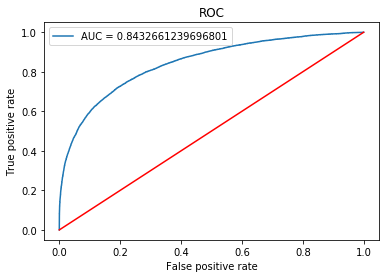

Test:
The model accuracy is 0.8024501225061254
The model f1 is 0.21654636313159353
The model p is 0.657672849915683
The model recall is 0.1296111665004985
The model KS is 0.3212029985484011
The confusion matrix is:
 [[11073   203]
 [ 2619   390]]


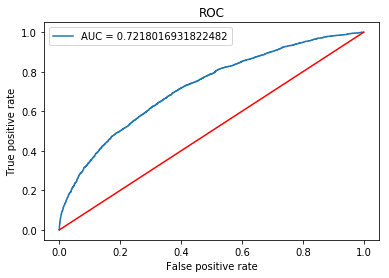

In [80]:
# 训练集
pre_train0 = model_cb0.predict(x_train)
pro_train0 = model_cb0.predict_proba(x_train)[:,1]
# 测试集
pre_test0 = model_cb0.predict(x_test)
pro_test0 = model_cb0.predict_proba(x_test)[:,1]

fpr, tpr, _ = model_performance(y_train, pre_train0, pro_train0, y_test, pre_test0, pro_test0)

<Container object of 10 artists>

[Text(0,0,'MONTH'),
 Text(0,0,'DAY'),
 Text(0,0,'DAY_OF_WEEK'),
 Text(0,0,'AIRLINE'),
 Text(0,0,'FLIGHT_NUMBER'),
 Text(0,0,'DESTINATION_AIRPORT'),
 Text(0,0,'ORIGIN_AIRPORT'),
 Text(0,0,'AIR_TIME'),
 Text(0,0,'DEPARTURE_TIME'),
 Text(0,0,'DISTANCE')]

Text(0.5,1,'CatBoost:Feature Importance')

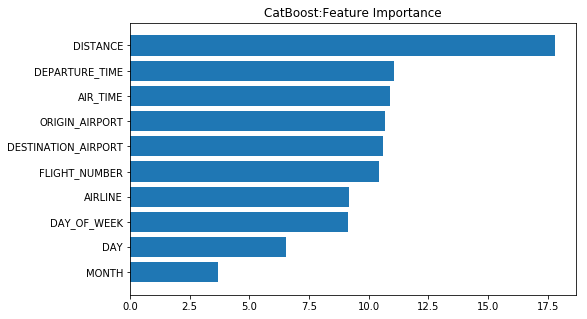

In [83]:
# 特征重要性
fimp_v = model_cb0.get_feature_importance()
fimp_n = model_cb0.feature_names_
fimp_vs = pd.Series(fimp_v).to_frame().rename(columns={0:'f_score'})
fimp_ns = pd.Series(fimp_n).to_frame().rename(columns={0:'f_name'})
fimp_result = pd.concat([fimp_ns, fimp_vs], axis=1)
fimp_result = fimp_result.sort_values(by='f_score')

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
ax.barh(range(len(fimp_result['f_score'])),fimp_result['f_score'])
ax.set_yticks(range(len(fimp_result['f_name'])))
ax.set_yticklabels(fimp_n)
plt.title('CatBoost:Feature Importance')
plt.show()

In [102]:
from catboost import Pool
import shap

# shap value
categorical_features_indices = [0,1,2,3,4,5,6]
shap_values = model_cb0.get_feature_importance(Pool(x_test, label=y_test, cat_features=categorical_features_indices),type="ShapValues")
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

shap.initjs()
shap.force_plot(expected_value, shap_values[0,:], x_test.iloc[0,:])